In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model

## Loading Data

In [3]:
def load_data():
    #first we load the MNIST dataset
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    #one hot vectorizing the labels
    Y_train_oneHot = tf.one_hot(Y_train, 10)
    Y_test_oneHot = tf.one_hot(Y_test, 10)
    
    #adding channel to the samples
    X_train_channeled = np.reshape(X_train, (X_train.shape[0], 
                                             X_train.shape[1], 
                                             X_train.shape[2], 1))
    X_test_channeled = np.reshape(X_test, (X_test.shape[0], 
                                            X_test.shape[1], 
                                            X_test.shape[2], 1))
    return X_train_channeled, X_test_channeled, Y_train_oneHot, Y_test_oneHot

## Generative Model Using Deep Convolutional Architecture

In [4]:
def generative_model():

    depth = 256
    generator_input = keras.Input(shape = (100), name = "Noise_Input")
    x = layers.Dense(7*7*256, name = "FullyConnected_Network_1")(generator_input)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_1")(x)
    x = layers.Activation("relu", name = "Relu_Activation_1")(x)

    x = layers.Reshape((7, 7, depth), name = "Reshaping_2")(x)
    x = layers.Dropout(0.4, name = "Inverse_Dropout_Regularizer_2")(x)

    
    x = layers.UpSampling2D(name = "Upsampling_3")(x)
    x = layers.Conv2DTranspose(int(depth/2), 5, padding = "same", name = "Conv_Layer_3")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_3")(x)
    x = layers.Activation("relu", name = "Relu_Activation_3")(x)

    
    x = layers.UpSampling2D(name = "UpSampling_4")(x)
    x = layers.Conv2DTranspose(int(depth/4), 5, padding = "same", name = "Conv_Layer_4")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_4")(x)
    x = layers.Activation("relu", name = "Relu_Activation_4")(x)

    
    x = layers.Conv2DTranspose(int(depth/8), 5, padding = "same", name = "Conv_Layer_5")(x)
    x = layers.BatchNormalization(momentum = 0.9, name = "Batch_Normalizing_5")(x)
    x = layers.Activation("relu", name = "Relu_Activation_5")(x)
    
    x = layers.Conv2DTranspose(1, 5, padding = "same", name = "1_Node_Output_6")(x)
    generator_output = layers.Activation("sigmoid", name = "Sigmoid_Activation_6")(x)
#     model.summary()
    
    return keras.Model(generator_input, generator_output, name = "Generator_Model")

Testing The Generator Function

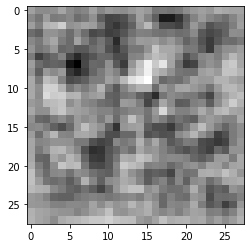

In [6]:
def generator_test():
    generator = generative_model()
    noise_input = np.random.normal(size = [1, 100])
    test_image = generator(noise_input, training=False)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test_image = sess.run(test_image)
    plt.imshow(test_image[0, :, :, 0], cmap='gray')

generator_test()

## Discriminative Model Using Deep Convolutional Architecture

In [7]:
def discriminative_model():
    depth = 64
    dropout = 0.4
    
#     input_shape = input_image_shape #it should be 28*28*1
    discriminator_input = keras.Input(shape = (28, 28, 1), name = "Image_Input")
    x = Conv2D(depth * 1, 5, strides = 2, padding = "same", name = "Conv_Layer_1")(discriminator_input)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_1")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_1")(x)

    x = layers.Conv2D(depth * 2, 5, strides = 2, padding = "same", name = "Conv_Layer_2")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_2")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_2")(x)

    x = layers.Conv2D(depth * 4, 5, strides = 2, padding = "same", name = "Conv_Layer_3")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_3")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_3")(x)

    x = layers.Conv2D(depth * 8, 5, strides = 1, padding = "same", name = "Conv_Layer_4")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_4")(x)
    x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_4")(x)    

    x = layers.Flatten(name = "FullyConnected_Network_5")(x)
    x = layers.Dense(1, name = "1_Node_Output_5")(x)
    discriminator_output = layers.Activation("sigmoid", name = "Sigmoid_Activation_5")(x)

    return keras.Model(discriminator_input, discriminator_output, name = "Discriminator_Model")

In [8]:
def discriminator_test():
    generator = generative_model()
    noise_input = np.random.normal(size = [1, 100])
    test_image = generator(noise_input, training=False)
    discriminator = discriminative_model()
    output_class = discriminator(test_image, training=False)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        test_image = sess.run(test_image)
        output_class = sess.run(output_class)
    print(output_class)

discriminator_test()

[[0.5001882]]


## Adding Discriminator and Adversarial Loss 

In [14]:
def discriminator_loss():
    discriminator_model = discriminative_model()
    discriminator = keras.models.Sequential()
    discriminator.add(discriminator_model)
    discriminator_model.summary()
    print("\n\n\n")
    discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0002, 
                                                       decay=6e-8)
    
    discriminator.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                          optimizer = discriminator_optimizer, 
                          metrics = ["accuracy"])
    return discriminator, discriminator_model

def generator_loss(discriminator):
    generator_model = generative_model()
    generator_model.summary()
    print("\n\n\n")
    
    generator_input = keras.Input(shape = (100), name = "Noise_Input")
    generator_to_discriminator = generator_model(generator_input)
    attaching_discriminator = discriminator(generator_to_discriminator)
    attached_model = keras.Model(generator_input, attaching_discriminator, name = "Adversarial_Model")
    attached_model.summary()
    print("\n\n\n")
    generator_optimizer = keras.optimizers.RMSprop(lr=0.0002,
                                                   decay=3e-8)

    attached_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                           optimizer = generator_optimizer, 
                           metrics = ["accuracy"])
    return attached_model, generator_model

## Preparing The Models

In [15]:
discriminator_compilation, discriminator_model = discriminator_loss()
generator_compilation, generator_model = generator_loss(discriminator_model)

Model: "Discriminator_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_Input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_Layer_1 (Conv2D)        (None, 14, 14, 64)        1664      
_________________________________________________________________
LeakyRelu_Activation_1 (Leak (None, 14, 14, 64)        0         
_________________________________________________________________
Inverse_Dropout_Regularizer_ (None, 14, 14, 64)        0         
_________________________________________________________________
Conv_Layer_2 (Conv2D)        (None, 7, 7, 128)         204928    
_________________________________________________________________
LeakyRelu_Activation_2 (Leak (None, 7, 7, 128)         0         
_________________________________________________________________
Inverse_Dropout_Regularizer_ (None, 7, 7, 128) 

## The Discriminator Model

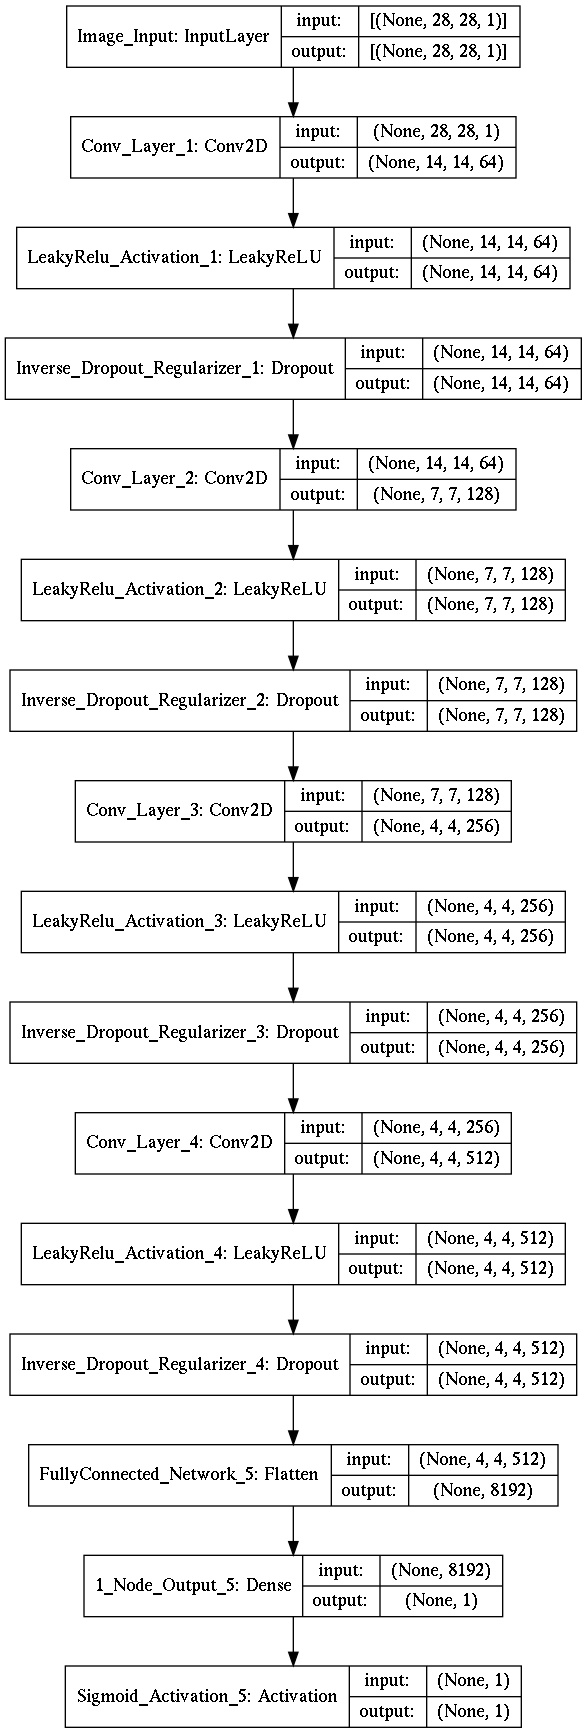

In [12]:
keras.utils.plot_model(discriminator_model, show_shapes=True)

## The Generator Model 

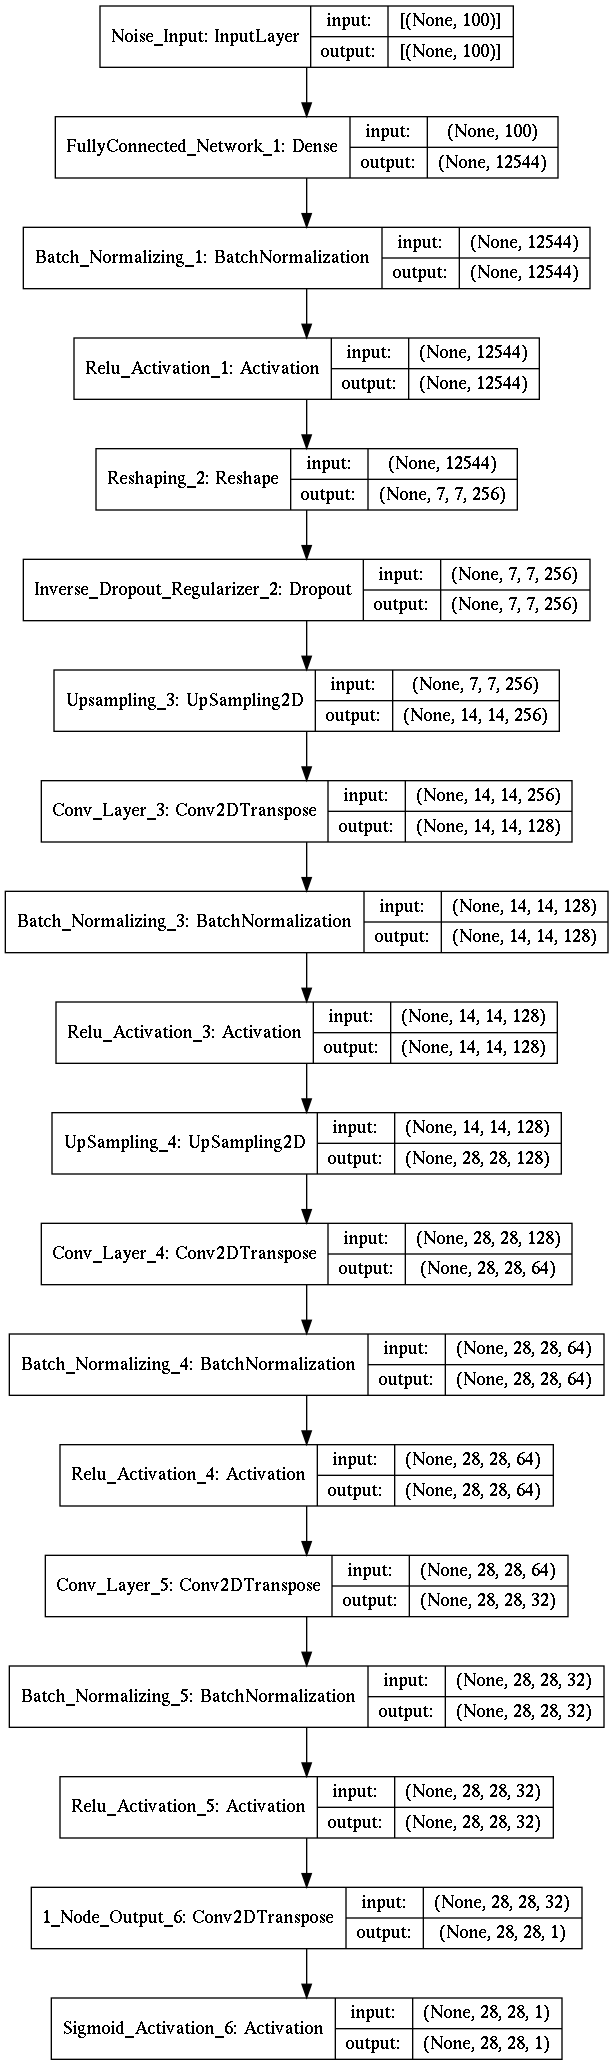

In [13]:
keras.utils.plot_model(generator_model, show_shapes=True)

## The Adversarial Model 

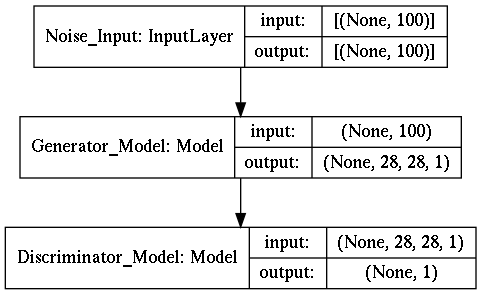

In [16]:
keras.utils.plot_model(generator_compilation, show_shapes=True)

## Running The Optimization

We run discriminator optimization 5 times more as it is the upper bound of the adversarial optimization (GAN paper for more information). In DCGAN paper it was not mandatory, but in this experiment based on used hyperparameters the discriminator was limitting the adversarial network optimization.

'epoch:  0 ' [discriminator loss:  2.0494578  and acc:  0.41992188 ] [generator loss:  0.40555966  and acc:  1.0 ]


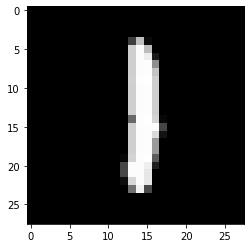

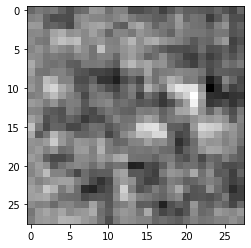

'epoch:  1 ' [discriminator loss:  3.3749008  and acc:  0.5 ] [generator loss:  0.05748543  and acc:  1.0 ]
'epoch:  2 ' [discriminator loss:  2.6195552  and acc:  0.5 ] [generator loss:  0.012863504  and acc:  1.0 ]
'epoch:  3 ' [discriminator loss:  1.7152789  and acc:  0.5 ] [generator loss:  0.017046714  and acc:  1.0 ]
'epoch:  4 ' [discriminator loss:  1.5457103  and acc:  0.5 ] [generator loss:  0.010878293  and acc:  1.0 ]
'epoch:  5 ' [discriminator loss:  1.2517089  and acc:  0.5 ] [generator loss:  0.008434978  and acc:  1.0 ]
'epoch:  6 ' [discriminator loss:  1.0267277  and acc:  0.5 ] [generator loss:  0.0055370126  and acc:  1.0 ]
'epoch:  7 ' [discriminator loss:  0.83215964  and acc:  0.5 ] [generator loss:  0.0040417034  and acc:  1.0 ]
'epoch:  8 ' [discriminator loss:  0.7006602  and acc:  0.5 ] [generator loss:  0.0027156933  and acc:  1.0 ]
'epoch:  9 ' [discriminator loss:  0.59960127  and acc:  0.5 ] [generator loss:  0.0022752932  and acc:  1.0 ]
'epoch:  10 ' 

'epoch:  75 ' [discriminator loss:  2.8005438  and acc:  0.5 ] [generator loss:  0.06883289  and acc:  1.0 ]
'epoch:  76 ' [discriminator loss:  2.8138733  and acc:  0.5 ] [generator loss:  0.06448058  and acc:  1.0 ]
'epoch:  77 ' [discriminator loss:  2.7004547  and acc:  0.5 ] [generator loss:  0.0673757  and acc:  1.0 ]
'epoch:  78 ' [discriminator loss:  2.70725  and acc:  0.5 ] [generator loss:  0.063858114  and acc:  1.0 ]
'epoch:  79 ' [discriminator loss:  2.6337638  and acc:  0.5 ] [generator loss:  0.06704298  and acc:  1.0 ]
'epoch:  80 ' [discriminator loss:  2.636951  and acc:  0.5 ] [generator loss:  0.06523967  and acc:  1.0 ]
'epoch:  81 ' [discriminator loss:  2.556241  and acc:  0.5 ] [generator loss:  0.06256973  and acc:  1.0 ]
'epoch:  82 ' [discriminator loss:  2.5062985  and acc:  0.5 ] [generator loss:  0.066279545  and acc:  1.0 ]
'epoch:  83 ' [discriminator loss:  2.5125823  and acc:  0.5 ] [generator loss:  0.062469594  and acc:  1.0 ]
'epoch:  84 ' [discri

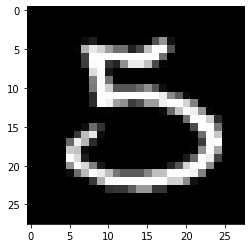

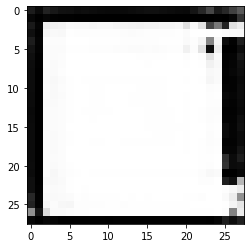

'epoch:  101 ' [discriminator loss:  2.1390233  and acc:  0.5 ] [generator loss:  0.059439864  and acc:  1.0 ]
'epoch:  102 ' [discriminator loss:  2.1174338  and acc:  0.5 ] [generator loss:  0.0578116  and acc:  1.0 ]
'epoch:  103 ' [discriminator loss:  2.099517  and acc:  0.5 ] [generator loss:  0.05928188  and acc:  1.0 ]
'epoch:  104 ' [discriminator loss:  2.1096025  and acc:  0.5 ] [generator loss:  0.05757142  and acc:  1.0 ]
'epoch:  105 ' [discriminator loss:  2.0990167  and acc:  0.5 ] [generator loss:  0.05834834  and acc:  1.0 ]
'epoch:  106 ' [discriminator loss:  2.0690572  and acc:  0.5 ] [generator loss:  0.057916097  and acc:  1.0 ]
'epoch:  107 ' [discriminator loss:  2.0788777  and acc:  0.5 ] [generator loss:  0.059641454  and acc:  1.0 ]
'epoch:  108 ' [discriminator loss:  2.0992785  and acc:  0.5 ] [generator loss:  0.057624012  and acc:  1.0 ]
'epoch:  109 ' [discriminator loss:  2.0767004  and acc:  0.5 ] [generator loss:  0.05793412  and acc:  1.0 ]
'epoch: 

'epoch:  175 ' [discriminator loss:  1.917337  and acc:  0.5 ] [generator loss:  0.055363327  and acc:  1.0 ]
'epoch:  176 ' [discriminator loss:  1.9165636  and acc:  0.5 ] [generator loss:  0.056357533  and acc:  1.0 ]
'epoch:  177 ' [discriminator loss:  1.9133055  and acc:  0.5 ] [generator loss:  0.05518354  and acc:  1.0 ]
'epoch:  178 ' [discriminator loss:  1.9104939  and acc:  0.5 ] [generator loss:  0.05753696  and acc:  1.0 ]
'epoch:  179 ' [discriminator loss:  1.9143267  and acc:  0.5 ] [generator loss:  0.055935778  and acc:  1.0 ]
'epoch:  180 ' [discriminator loss:  1.9231722  and acc:  0.5 ] [generator loss:  0.056586266  and acc:  1.0 ]
'epoch:  181 ' [discriminator loss:  1.9123633  and acc:  0.5 ] [generator loss:  0.05506864  and acc:  1.0 ]
'epoch:  182 ' [discriminator loss:  1.9117031  and acc:  0.5 ] [generator loss:  0.056213506  and acc:  1.0 ]
'epoch:  183 ' [discriminator loss:  1.9160225  and acc:  0.5 ] [generator loss:  0.056868307  and acc:  1.0 ]
'epoc

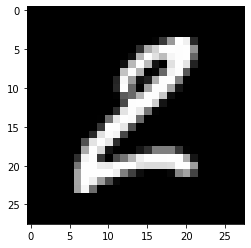

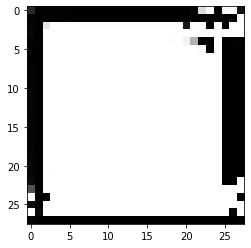

'epoch:  201 ' [discriminator loss:  1.9139376  and acc:  0.5 ] [generator loss:  0.05532554  and acc:  1.0 ]
'epoch:  202 ' [discriminator loss:  1.9130898  and acc:  0.5 ] [generator loss:  0.055997778  and acc:  1.0 ]
'epoch:  203 ' [discriminator loss:  1.919364  and acc:  0.49804688 ] [generator loss:  0.051253498  and acc:  1.0 ]
'epoch:  204 ' [discriminator loss:  1.9208575  and acc:  0.5 ] [generator loss:  0.051864937  and acc:  1.0 ]
'epoch:  205 ' [discriminator loss:  1.9116163  and acc:  0.5 ] [generator loss:  0.053091064  and acc:  1.0 ]
'epoch:  206 ' [discriminator loss:  1.9001611  and acc:  0.5 ] [generator loss:  0.053092934  and acc:  1.0 ]
'epoch:  207 ' [discriminator loss:  1.9174845  and acc:  0.5 ] [generator loss:  0.052372415  and acc:  1.0 ]
'epoch:  208 ' [discriminator loss:  1.906158  and acc:  0.5 ] [generator loss:  0.05313459  and acc:  1.0 ]
'epoch:  209 ' [discriminator loss:  1.9027622  and acc:  0.5 ] [generator loss:  0.05337701  and acc:  1.0 ]

'epoch:  275 ' [discriminator loss:  2.0084176  and acc:  0.5 ] [generator loss:  0.041472435  and acc:  1.0 ]
'epoch:  276 ' [discriminator loss:  2.0142152  and acc:  0.5 ] [generator loss:  0.04154648  and acc:  1.0 ]
'epoch:  277 ' [discriminator loss:  2.0086133  and acc:  0.5 ] [generator loss:  0.041337013  and acc:  1.0 ]
'epoch:  278 ' [discriminator loss:  2.0252519  and acc:  0.49804688 ] [generator loss:  0.040174834  and acc:  1.0 ]
'epoch:  279 ' [discriminator loss:  2.0488887  and acc:  0.5 ] [generator loss:  0.039363075  and acc:  1.0 ]
'epoch:  280 ' [discriminator loss:  2.0329008  and acc:  0.5 ] [generator loss:  0.040506892  and acc:  1.0 ]
'epoch:  281 ' [discriminator loss:  2.0299897  and acc:  0.5 ] [generator loss:  0.040404573  and acc:  1.0 ]
'epoch:  282 ' [discriminator loss:  2.0387206  and acc:  0.5 ] [generator loss:  0.041137315  and acc:  1.0 ]
'epoch:  283 ' [discriminator loss:  2.0702019  and acc:  0.49804688 ] [generator loss:  0.036771566  and 

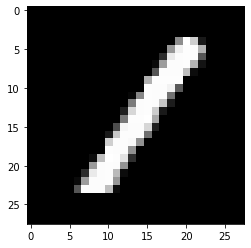

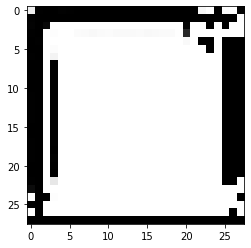

'epoch:  301 ' [discriminator loss:  2.0896873  and acc:  0.5 ] [generator loss:  0.035215005  and acc:  1.0 ]
'epoch:  302 ' [discriminator loss:  2.0950532  and acc:  0.5 ] [generator loss:  0.03560356  and acc:  1.0 ]
'epoch:  303 ' [discriminator loss:  2.1009483  and acc:  0.5 ] [generator loss:  0.035646312  and acc:  1.0 ]
'epoch:  304 ' [discriminator loss:  2.0999377  and acc:  0.5 ] [generator loss:  0.03737637  and acc:  1.0 ]
'epoch:  305 ' [discriminator loss:  2.1050937  and acc:  0.5 ] [generator loss:  0.03566681  and acc:  1.0 ]
'epoch:  306 ' [discriminator loss:  2.127231  and acc:  0.5 ] [generator loss:  0.035498902  and acc:  1.0 ]
'epoch:  307 ' [discriminator loss:  2.1151104  and acc:  0.49804688 ] [generator loss:  0.033204056  and acc:  1.0 ]
'epoch:  308 ' [discriminator loss:  2.1274338  and acc:  0.5 ] [generator loss:  0.034154885  and acc:  1.0 ]
'epoch:  309 ' [discriminator loss:  2.1248956  and acc:  0.5 ] [generator loss:  0.03469235  and acc:  1.0 ]

'epoch:  375 ' [discriminator loss:  2.157078  and acc:  0.5 ] [generator loss:  0.030888826  and acc:  1.0 ]
'epoch:  376 ' [discriminator loss:  2.1703858  and acc:  0.5 ] [generator loss:  0.030906525  and acc:  1.0 ]
'epoch:  377 ' [discriminator loss:  2.1515648  and acc:  0.5 ] [generator loss:  0.030718142  and acc:  1.0 ]
'epoch:  378 ' [discriminator loss:  2.2284486  and acc:  0.49804688 ] [generator loss:  0.028811414  and acc:  1.0 ]
'epoch:  379 ' [discriminator loss:  2.189277  and acc:  0.5 ] [generator loss:  0.028440014  and acc:  1.0 ]
'epoch:  380 ' [discriminator loss:  2.1797457  and acc:  0.5 ] [generator loss:  0.02941628  and acc:  1.0 ]
'epoch:  381 ' [discriminator loss:  2.1754055  and acc:  0.5 ] [generator loss:  0.029103978  and acc:  1.0 ]
'epoch:  382 ' [discriminator loss:  2.1766512  and acc:  0.5 ] [generator loss:  0.030179508  and acc:  1.0 ]
'epoch:  383 ' [discriminator loss:  2.1807468  and acc:  0.5 ] [generator loss:  0.02943863  and acc:  1.0 

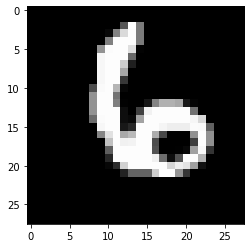

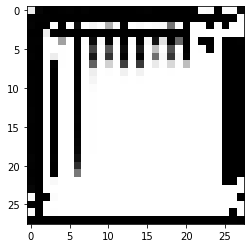

'epoch:  401 ' [discriminator loss:  2.206575  and acc:  0.5 ] [generator loss:  0.028529271  and acc:  1.0 ]
'epoch:  402 ' [discriminator loss:  2.2041554  and acc:  0.5 ] [generator loss:  0.02832266  and acc:  1.0 ]
'epoch:  403 ' [discriminator loss:  2.2021399  and acc:  0.5 ] [generator loss:  0.028184295  and acc:  1.0 ]
'epoch:  404 ' [discriminator loss:  2.2148497  and acc:  0.5 ] [generator loss:  0.028083172  and acc:  1.0 ]
'epoch:  405 ' [discriminator loss:  2.2000022  and acc:  0.5 ] [generator loss:  0.028507091  and acc:  1.0 ]
'epoch:  406 ' [discriminator loss:  2.19904  and acc:  0.5 ] [generator loss:  0.028466195  and acc:  1.0 ]
'epoch:  407 ' [discriminator loss:  2.188912  and acc:  0.5 ] [generator loss:  0.028499689  and acc:  1.0 ]
'epoch:  408 ' [discriminator loss:  2.2034206  and acc:  0.49804688 ] [generator loss:  0.027496647  and acc:  1.0 ]
'epoch:  409 ' [discriminator loss:  2.2188668  and acc:  0.5 ] [generator loss:  0.028176408  and acc:  1.0 ]

'epoch:  475 ' [discriminator loss:  2.3078141  and acc:  0.5 ] [generator loss:  0.023625785  and acc:  1.0 ]
'epoch:  476 ' [discriminator loss:  2.3006458  and acc:  0.5 ] [generator loss:  0.023650423  and acc:  1.0 ]
'epoch:  477 ' [discriminator loss:  2.2942266  and acc:  0.5 ] [generator loss:  0.02362476  and acc:  1.0 ]
'epoch:  478 ' [discriminator loss:  2.300705  and acc:  0.5 ] [generator loss:  0.023477042  and acc:  1.0 ]
'epoch:  479 ' [discriminator loss:  2.289926  and acc:  0.5 ] [generator loss:  0.02333277  and acc:  1.0 ]
'epoch:  480 ' [discriminator loss:  2.30294  and acc:  0.5 ] [generator loss:  0.023603022  and acc:  1.0 ]
'epoch:  481 ' [discriminator loss:  2.3164175  and acc:  0.49804688 ] [generator loss:  0.022982303  and acc:  1.0 ]
'epoch:  482 ' [discriminator loss:  2.318674  and acc:  0.5 ] [generator loss:  0.023444597  and acc:  1.0 ]
'epoch:  483 ' [discriminator loss:  2.3139868  and acc:  0.5 ] [generator loss:  0.022822466  and acc:  1.0 ]
'

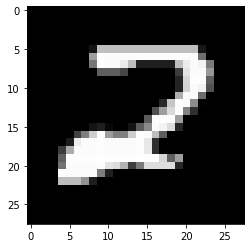

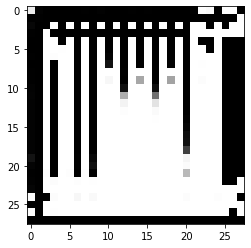

'epoch:  501 ' [discriminator loss:  2.3174078  and acc:  0.5 ] [generator loss:  0.02272005  and acc:  1.0 ]
'epoch:  502 ' [discriminator loss:  2.332419  and acc:  0.5 ] [generator loss:  0.022989994  and acc:  1.0 ]
'epoch:  503 ' [discriminator loss:  2.3387115  and acc:  0.5 ] [generator loss:  0.022676706  and acc:  1.0 ]
'epoch:  504 ' [discriminator loss:  2.3370967  and acc:  0.5 ] [generator loss:  0.021910647  and acc:  1.0 ]
'epoch:  505 ' [discriminator loss:  2.3236208  and acc:  0.5 ] [generator loss:  0.022548404  and acc:  1.0 ]
'epoch:  506 ' [discriminator loss:  2.324965  and acc:  0.5 ] [generator loss:  0.022496607  and acc:  1.0 ]
'epoch:  507 ' [discriminator loss:  2.3294249  and acc:  0.5 ] [generator loss:  0.022631874  and acc:  1.0 ]
'epoch:  508 ' [discriminator loss:  2.3146846  and acc:  0.5 ] [generator loss:  0.022804959  and acc:  1.0 ]
'epoch:  509 ' [discriminator loss:  2.3294802  and acc:  0.5 ] [generator loss:  0.021931292  and acc:  1.0 ]
'epo

'epoch:  575 ' [discriminator loss:  2.395331  and acc:  0.5 ] [generator loss:  0.01993897  and acc:  1.0 ]
'epoch:  576 ' [discriminator loss:  2.373151  and acc:  0.5 ] [generator loss:  0.019687735  and acc:  1.0 ]
'epoch:  577 ' [discriminator loss:  2.377931  and acc:  0.5 ] [generator loss:  0.019585215  and acc:  1.0 ]
'epoch:  578 ' [discriminator loss:  2.37691  and acc:  0.5 ] [generator loss:  0.019853875  and acc:  1.0 ]
'epoch:  579 ' [discriminator loss:  2.3757164  and acc:  0.5 ] [generator loss:  0.019744009  and acc:  1.0 ]
'epoch:  580 ' [discriminator loss:  2.3817594  and acc:  0.5 ] [generator loss:  0.019851279  and acc:  1.0 ]
'epoch:  581 ' [discriminator loss:  2.394226  and acc:  0.5 ] [generator loss:  0.019484261  and acc:  1.0 ]
'epoch:  582 ' [discriminator loss:  2.3841264  and acc:  0.49804688 ] [generator loss:  0.019319223  and acc:  1.0 ]
'epoch:  583 ' [discriminator loss:  2.3959913  and acc:  0.5 ] [generator loss:  0.019584227  and acc:  1.0 ]
'

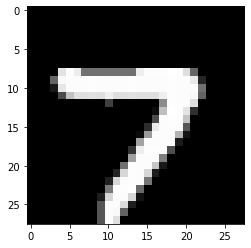

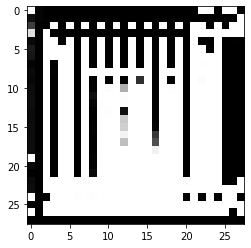

'epoch:  601 ' [discriminator loss:  2.4209611  and acc:  0.5 ] [generator loss:  0.018298667  and acc:  1.0 ]
'epoch:  602 ' [discriminator loss:  2.4221349  and acc:  0.5 ] [generator loss:  0.018352102  and acc:  1.0 ]
'epoch:  603 ' [discriminator loss:  2.422472  and acc:  0.5 ] [generator loss:  0.018613521  and acc:  1.0 ]
'epoch:  604 ' [discriminator loss:  2.4255304  and acc:  0.5 ] [generator loss:  0.018208638  and acc:  1.0 ]
'epoch:  605 ' [discriminator loss:  2.4138973  and acc:  0.5 ] [generator loss:  0.018416315  and acc:  1.0 ]
'epoch:  606 ' [discriminator loss:  2.4274907  and acc:  0.5 ] [generator loss:  0.018365826  and acc:  1.0 ]
'epoch:  607 ' [discriminator loss:  2.4133816  and acc:  0.5 ] [generator loss:  0.018094724  and acc:  1.0 ]
'epoch:  608 ' [discriminator loss:  2.4261394  and acc:  0.5 ] [generator loss:  0.018222563  and acc:  1.0 ]
'epoch:  609 ' [discriminator loss:  2.4181218  and acc:  0.5 ] [generator loss:  0.018074185  and acc:  1.0 ]
'e

'epoch:  675 ' [discriminator loss:  2.485135  and acc:  0.5 ] [generator loss:  0.015829787  and acc:  1.0 ]
'epoch:  676 ' [discriminator loss:  2.5003796  and acc:  0.5 ] [generator loss:  0.015898354  and acc:  1.0 ]
'epoch:  677 ' [discriminator loss:  2.4872174  and acc:  0.5 ] [generator loss:  0.016113356  and acc:  1.0 ]
'epoch:  678 ' [discriminator loss:  2.5101879  and acc:  0.5 ] [generator loss:  0.01583033  and acc:  1.0 ]
'epoch:  679 ' [discriminator loss:  2.4979403  and acc:  0.5 ] [generator loss:  0.015804198  and acc:  1.0 ]
'epoch:  680 ' [discriminator loss:  2.4983344  and acc:  0.5 ] [generator loss:  0.015927946  and acc:  1.0 ]
'epoch:  681 ' [discriminator loss:  2.5026293  and acc:  0.5 ] [generator loss:  0.015917769  and acc:  1.0 ]
'epoch:  682 ' [discriminator loss:  2.505238  and acc:  0.49804688 ] [generator loss:  0.015218364  and acc:  1.0 ]
'epoch:  683 ' [discriminator loss:  2.5369582  and acc:  0.5 ] [generator loss:  0.01570457  and acc:  1.0 

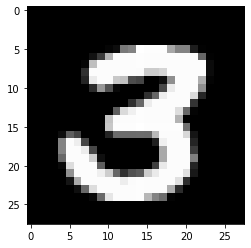

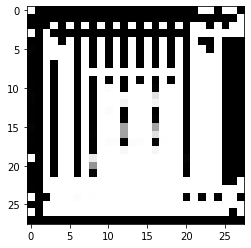

'epoch:  701 ' [discriminator loss:  2.5398393  and acc:  0.5 ] [generator loss:  0.014620348  and acc:  1.0 ]
'epoch:  702 ' [discriminator loss:  2.555192  and acc:  0.5 ] [generator loss:  0.014469599  and acc:  1.0 ]
'epoch:  703 ' [discriminator loss:  2.5458348  and acc:  0.5 ] [generator loss:  0.014524128  and acc:  1.0 ]
'epoch:  704 ' [discriminator loss:  2.5374053  and acc:  0.5 ] [generator loss:  0.014558516  and acc:  1.0 ]
'epoch:  705 ' [discriminator loss:  2.5480409  and acc:  0.5 ] [generator loss:  0.014726353  and acc:  1.0 ]
'epoch:  706 ' [discriminator loss:  2.5420735  and acc:  0.5 ] [generator loss:  0.014143073  and acc:  1.0 ]
'epoch:  707 ' [discriminator loss:  2.5418184  and acc:  0.5 ] [generator loss:  0.014517585  and acc:  1.0 ]
'epoch:  708 ' [discriminator loss:  2.5393138  and acc:  0.5 ] [generator loss:  0.0145794265  and acc:  1.0 ]
'epoch:  709 ' [discriminator loss:  2.5463448  and acc:  0.5 ] [generator loss:  0.014658002  and acc:  1.0 ]
'

'epoch:  775 ' [discriminator loss:  2.6486712  and acc:  0.5 ] [generator loss:  0.012177594  and acc:  1.0 ]
'epoch:  776 ' [discriminator loss:  2.670301  and acc:  0.5 ] [generator loss:  0.01215504  and acc:  1.0 ]
'epoch:  777 ' [discriminator loss:  2.666368  and acc:  0.5 ] [generator loss:  0.011715892  and acc:  1.0 ]
'epoch:  778 ' [discriminator loss:  2.6585703  and acc:  0.5 ] [generator loss:  0.012153745  and acc:  1.0 ]
'epoch:  779 ' [discriminator loss:  2.67857  and acc:  0.5 ] [generator loss:  0.012526718  and acc:  1.0 ]
'epoch:  780 ' [discriminator loss:  2.666502  and acc:  0.5 ] [generator loss:  0.01189878  and acc:  1.0 ]
'epoch:  781 ' [discriminator loss:  2.672748  and acc:  0.5 ] [generator loss:  0.011680676  and acc:  1.0 ]
'epoch:  782 ' [discriminator loss:  2.6795697  and acc:  0.5 ] [generator loss:  0.012452947  and acc:  1.0 ]
'epoch:  783 ' [discriminator loss:  2.6922693  and acc:  0.5 ] [generator loss:  0.011731561  and acc:  1.0 ]
'epoch:  

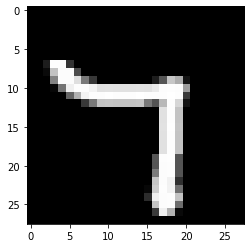

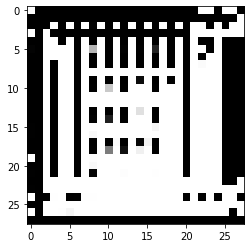

'epoch:  801 ' [discriminator loss:  2.6746657  and acc:  0.5 ] [generator loss:  0.012064798  and acc:  1.0 ]
'epoch:  802 ' [discriminator loss:  2.6641154  and acc:  0.5 ] [generator loss:  0.012049254  and acc:  1.0 ]
'epoch:  803 ' [discriminator loss:  2.6709206  and acc:  0.5 ] [generator loss:  0.012294753  and acc:  1.0 ]
'epoch:  804 ' [discriminator loss:  2.6693573  and acc:  0.5 ] [generator loss:  0.012059923  and acc:  1.0 ]
'epoch:  805 ' [discriminator loss:  2.675393  and acc:  0.49804688 ] [generator loss:  0.011080419  and acc:  1.0 ]
'epoch:  806 ' [discriminator loss:  2.7400367  and acc:  0.5 ] [generator loss:  0.011429335  and acc:  1.0 ]
'epoch:  807 ' [discriminator loss:  2.6822906  and acc:  0.5 ] [generator loss:  0.011140494  and acc:  1.0 ]
'epoch:  808 ' [discriminator loss:  2.6607068  and acc:  0.5 ] [generator loss:  0.011397973  and acc:  1.0 ]
'epoch:  809 ' [discriminator loss:  2.6797686  and acc:  0.5 ] [generator loss:  0.011719185  and acc:  1

'epoch:  875 ' [discriminator loss:  2.7566025  and acc:  0.5 ] [generator loss:  0.009851215  and acc:  1.0 ]
'epoch:  876 ' [discriminator loss:  2.756233  and acc:  0.5 ] [generator loss:  0.00991283  and acc:  1.0 ]
'epoch:  877 ' [discriminator loss:  2.771908  and acc:  0.5 ] [generator loss:  0.009930714  and acc:  1.0 ]
'epoch:  878 ' [discriminator loss:  2.7708025  and acc:  0.5 ] [generator loss:  0.009799622  and acc:  1.0 ]
'epoch:  879 ' [discriminator loss:  2.7777326  and acc:  0.5 ] [generator loss:  0.009862945  and acc:  1.0 ]
'epoch:  880 ' [discriminator loss:  2.7705944  and acc:  0.5 ] [generator loss:  0.0097408425  and acc:  1.0 ]
'epoch:  881 ' [discriminator loss:  2.7591233  and acc:  0.5 ] [generator loss:  0.0098387925  and acc:  1.0 ]
'epoch:  882 ' [discriminator loss:  2.7718534  and acc:  0.5 ] [generator loss:  0.00984981  and acc:  1.0 ]
'epoch:  883 ' [discriminator loss:  2.771575  and acc:  0.5 ] [generator loss:  0.010023352  and acc:  1.0 ]
'epo

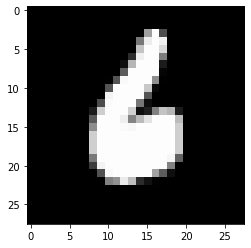

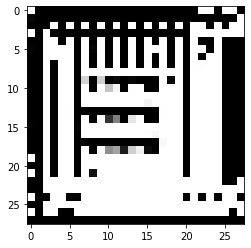

'epoch:  901 ' [discriminator loss:  2.799374  and acc:  0.5 ] [generator loss:  0.009640401  and acc:  1.0 ]
'epoch:  902 ' [discriminator loss:  2.7879157  and acc:  0.5 ] [generator loss:  0.0094817495  and acc:  1.0 ]
'epoch:  903 ' [discriminator loss:  2.7946403  and acc:  0.5 ] [generator loss:  0.00960679  and acc:  1.0 ]
'epoch:  904 ' [discriminator loss:  2.7895236  and acc:  0.5 ] [generator loss:  0.009681525  and acc:  1.0 ]
'epoch:  905 ' [discriminator loss:  2.7897892  and acc:  0.5 ] [generator loss:  0.009309299  and acc:  1.0 ]
'epoch:  906 ' [discriminator loss:  2.7850332  and acc:  0.5 ] [generator loss:  0.009492973  and acc:  1.0 ]
'epoch:  907 ' [discriminator loss:  2.7914362  and acc:  0.5 ] [generator loss:  0.00937124  and acc:  1.0 ]
'epoch:  908 ' [discriminator loss:  2.7771583  and acc:  0.5 ] [generator loss:  0.009579547  and acc:  1.0 ]
'epoch:  909 ' [discriminator loss:  2.7862768  and acc:  0.5 ] [generator loss:  0.009771576  and acc:  1.0 ]
'ep

'epoch:  975 ' [discriminator loss:  2.9297886  and acc:  0.5 ] [generator loss:  0.0076149767  and acc:  1.0 ]
'epoch:  976 ' [discriminator loss:  2.921419  and acc:  0.5 ] [generator loss:  0.007597737  and acc:  1.0 ]
'epoch:  977 ' [discriminator loss:  2.926587  and acc:  0.5 ] [generator loss:  0.007774408  and acc:  1.0 ]
'epoch:  978 ' [discriminator loss:  2.9159963  and acc:  0.5 ] [generator loss:  0.0074617304  and acc:  1.0 ]
'epoch:  979 ' [discriminator loss:  2.9159427  and acc:  0.5 ] [generator loss:  0.0077834195  and acc:  1.0 ]
'epoch:  980 ' [discriminator loss:  2.9278398  and acc:  0.5 ] [generator loss:  0.0076166736  and acc:  1.0 ]
'epoch:  981 ' [discriminator loss:  2.9371102  and acc:  0.49804688 ] [generator loss:  0.006801758  and acc:  1.0 ]
'epoch:  982 ' [discriminator loss:  3.0123174  and acc:  0.5 ] [generator loss:  0.0074404813  and acc:  1.0 ]
'epoch:  983 ' [discriminator loss:  2.949792  and acc:  0.5 ] [generator loss:  0.0070573655  and acc

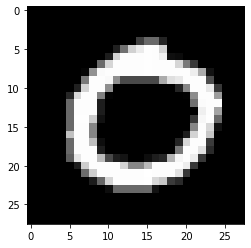

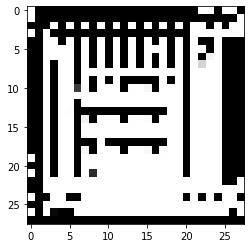

'epoch:  1001 ' [discriminator loss:  2.9704094  and acc:  0.5 ] [generator loss:  0.0070660473  and acc:  1.0 ]
'epoch:  1002 ' [discriminator loss:  2.955168  and acc:  0.5 ] [generator loss:  0.0070818113  and acc:  1.0 ]
'epoch:  1003 ' [discriminator loss:  2.944607  and acc:  0.5 ] [generator loss:  0.007366648  and acc:  1.0 ]
'epoch:  1004 ' [discriminator loss:  2.9603457  and acc:  0.5 ] [generator loss:  0.007010228  and acc:  1.0 ]
'epoch:  1005 ' [discriminator loss:  2.9392042  and acc:  0.5 ] [generator loss:  0.0072888536  and acc:  1.0 ]
'epoch:  1006 ' [discriminator loss:  2.9658442  and acc:  0.5 ] [generator loss:  0.007145449  and acc:  1.0 ]
'epoch:  1007 ' [discriminator loss:  2.9734406  and acc:  0.5 ] [generator loss:  0.007091463  and acc:  1.0 ]
'epoch:  1008 ' [discriminator loss:  2.9692268  and acc:  0.5 ] [generator loss:  0.0071092276  and acc:  1.0 ]
'epoch:  1009 ' [discriminator loss:  2.966311  and acc:  0.5 ] [generator loss:  0.0071955  and acc: 

'epoch:  1074 ' [discriminator loss:  3.0393157  and acc:  0.5 ] [generator loss:  0.005933302  and acc:  1.0 ]
'epoch:  1075 ' [discriminator loss:  3.0414667  and acc:  0.5 ] [generator loss:  0.0059809545  and acc:  1.0 ]
'epoch:  1076 ' [discriminator loss:  3.0386178  and acc:  0.5 ] [generator loss:  0.0063110986  and acc:  1.0 ]
'epoch:  1077 ' [discriminator loss:  3.0711021  and acc:  0.5 ] [generator loss:  0.0059809936  and acc:  1.0 ]
'epoch:  1078 ' [discriminator loss:  3.0460882  and acc:  0.5 ] [generator loss:  0.0059668394  and acc:  1.0 ]
'epoch:  1079 ' [discriminator loss:  3.0437193  and acc:  0.5 ] [generator loss:  0.0060978318  and acc:  1.0 ]
'epoch:  1080 ' [discriminator loss:  3.0480404  and acc:  0.5 ] [generator loss:  0.0062022135  and acc:  1.0 ]
'epoch:  1081 ' [discriminator loss:  3.0520515  and acc:  0.5 ] [generator loss:  0.006166289  and acc:  1.0 ]
'epoch:  1082 ' [discriminator loss:  3.0892167  and acc:  0.5 ] [generator loss:  0.005826415  an

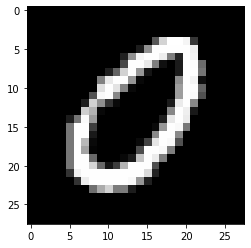

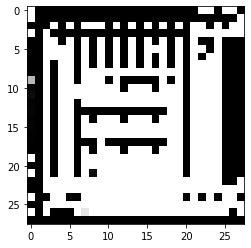

'epoch:  1101 ' [discriminator loss:  3.0895305  and acc:  0.5 ] [generator loss:  0.0057124365  and acc:  1.0 ]
'epoch:  1102 ' [discriminator loss:  3.1090183  and acc:  0.5 ] [generator loss:  0.005622426  and acc:  1.0 ]
'epoch:  1103 ' [discriminator loss:  3.1062846  and acc:  0.5 ] [generator loss:  0.0054427455  and acc:  1.0 ]
'epoch:  1104 ' [discriminator loss:  3.1060517  and acc:  0.5 ] [generator loss:  0.0055834786  and acc:  1.0 ]
'epoch:  1105 ' [discriminator loss:  3.1611786  and acc:  0.49804688 ] [generator loss:  0.0047509316  and acc:  1.0 ]
'epoch:  1106 ' [discriminator loss:  3.2051797  and acc:  0.5 ] [generator loss:  0.005266846  and acc:  1.0 ]
'epoch:  1107 ' [discriminator loss:  3.12908  and acc:  0.5 ] [generator loss:  0.0051984806  and acc:  1.0 ]
'epoch:  1108 ' [discriminator loss:  3.1219711  and acc:  0.5 ] [generator loss:  0.0051889694  and acc:  1.0 ]
'epoch:  1109 ' [discriminator loss:  3.106998  and acc:  0.5 ] [generator loss:  0.005294586

'epoch:  1174 ' [discriminator loss:  3.1747465  and acc:  0.5 ] [generator loss:  0.004911096  and acc:  1.0 ]
'epoch:  1175 ' [discriminator loss:  3.3075569  and acc:  0.49804688 ] [generator loss:  0.0039436556  and acc:  1.0 ]
'epoch:  1176 ' [discriminator loss:  3.2890654  and acc:  0.5 ] [generator loss:  0.004384292  and acc:  1.0 ]
'epoch:  1177 ' [discriminator loss:  3.2128239  and acc:  0.5 ] [generator loss:  0.0045451866  and acc:  1.0 ]
'epoch:  1178 ' [discriminator loss:  3.215621  and acc:  0.5 ] [generator loss:  0.004259092  and acc:  1.0 ]
'epoch:  1179 ' [discriminator loss:  3.185544  and acc:  0.5 ] [generator loss:  0.004487691  and acc:  1.0 ]
'epoch:  1180 ' [discriminator loss:  3.2060323  and acc:  0.5 ] [generator loss:  0.004327532  and acc:  1.0 ]
'epoch:  1181 ' [discriminator loss:  3.2024574  and acc:  0.5 ] [generator loss:  0.0045736115  and acc:  1.0 ]
'epoch:  1182 ' [discriminator loss:  3.2199507  and acc:  0.5 ] [generator loss:  0.0042428263 

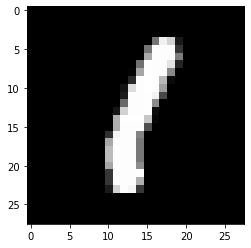

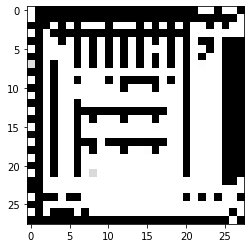

'epoch:  1201 ' [discriminator loss:  3.2498941  and acc:  0.5 ] [generator loss:  0.003908192  and acc:  1.0 ]
'epoch:  1202 ' [discriminator loss:  3.2542381  and acc:  0.5 ] [generator loss:  0.0039702514  and acc:  1.0 ]
'epoch:  1203 ' [discriminator loss:  3.2670565  and acc:  0.5 ] [generator loss:  0.0038238626  and acc:  1.0 ]
'epoch:  1204 ' [discriminator loss:  3.265831  and acc:  0.5 ] [generator loss:  0.00400982  and acc:  1.0 ]
'epoch:  1205 ' [discriminator loss:  3.290719  and acc:  0.5 ] [generator loss:  0.003723932  and acc:  1.0 ]
'epoch:  1206 ' [discriminator loss:  3.2939067  and acc:  0.5 ] [generator loss:  0.00415422  and acc:  1.0 ]
'epoch:  1207 ' [discriminator loss:  3.2862496  and acc:  0.5 ] [generator loss:  0.003833386  and acc:  1.0 ]
'epoch:  1208 ' [discriminator loss:  3.2887099  and acc:  0.5 ] [generator loss:  0.003804596  and acc:  1.0 ]
'epoch:  1209 ' [discriminator loss:  3.2982543  and acc:  0.5 ] [generator loss:  0.0038153199  and acc: 

'epoch:  1274 ' [discriminator loss:  3.4030087  and acc:  0.5 ] [generator loss:  0.003144621  and acc:  1.0 ]
'epoch:  1275 ' [discriminator loss:  3.4162426  and acc:  0.5 ] [generator loss:  0.0031378502  and acc:  1.0 ]
'epoch:  1276 ' [discriminator loss:  3.5423088  and acc:  0.49804688 ] [generator loss:  0.0023245509  and acc:  1.0 ]
'epoch:  1277 ' [discriminator loss:  3.5906281  and acc:  0.5 ] [generator loss:  0.002848743  and acc:  1.0 ]
'epoch:  1278 ' [discriminator loss:  3.5205684  and acc:  0.5 ] [generator loss:  0.0028742044  and acc:  1.0 ]
'epoch:  1279 ' [discriminator loss:  3.4896998  and acc:  0.5 ] [generator loss:  0.003018109  and acc:  1.0 ]
'epoch:  1280 ' [discriminator loss:  3.4824111  and acc:  0.5 ] [generator loss:  0.002738176  and acc:  1.0 ]
'epoch:  1281 ' [discriminator loss:  3.48259  and acc:  0.5 ] [generator loss:  0.0028686882  and acc:  1.0 ]
'epoch:  1282 ' [discriminator loss:  3.4600527  and acc:  0.5 ] [generator loss:  0.0028577216

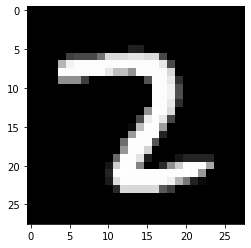

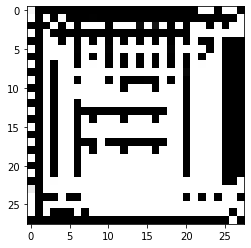

'epoch:  1301 ' [discriminator loss:  3.561887  and acc:  0.5 ] [generator loss:  0.0024460903  and acc:  1.0 ]
'epoch:  1302 ' [discriminator loss:  3.5339627  and acc:  0.5 ] [generator loss:  0.00269408  and acc:  1.0 ]
'epoch:  1303 ' [discriminator loss:  3.589952  and acc:  0.5 ] [generator loss:  0.0025803447  and acc:  1.0 ]
'epoch:  1304 ' [discriminator loss:  3.5700321  and acc:  0.5 ] [generator loss:  0.002513139  and acc:  1.0 ]
'epoch:  1305 ' [discriminator loss:  3.5773978  and acc:  0.5 ] [generator loss:  0.0026134383  and acc:  1.0 ]
'epoch:  1306 ' [discriminator loss:  3.5535443  and acc:  0.5 ] [generator loss:  0.0025713865  and acc:  1.0 ]
'epoch:  1307 ' [discriminator loss:  3.572022  and acc:  0.5 ] [generator loss:  0.002664104  and acc:  1.0 ]
'epoch:  1308 ' [discriminator loss:  3.5921185  and acc:  0.5 ] [generator loss:  0.002371788  and acc:  1.0 ]
'epoch:  1309 ' [discriminator loss:  3.5848336  and acc:  0.5 ] [generator loss:  0.0026461836  and acc

'epoch:  1374 ' [discriminator loss:  3.7450094  and acc:  0.5 ] [generator loss:  0.0019755592  and acc:  1.0 ]
'epoch:  1375 ' [discriminator loss:  3.7742705  and acc:  0.5 ] [generator loss:  0.0019303282  and acc:  1.0 ]
'epoch:  1376 ' [discriminator loss:  3.7852373  and acc:  0.5 ] [generator loss:  0.001921302  and acc:  1.0 ]
'epoch:  1377 ' [discriminator loss:  3.7522998  and acc:  0.5 ] [generator loss:  0.0019013148  and acc:  1.0 ]
'epoch:  1378 ' [discriminator loss:  3.7607355  and acc:  0.5 ] [generator loss:  0.0018924272  and acc:  1.0 ]
'epoch:  1379 ' [discriminator loss:  3.7377386  and acc:  0.5 ] [generator loss:  0.002007314  and acc:  1.0 ]
'epoch:  1380 ' [discriminator loss:  3.7768896  and acc:  0.5 ] [generator loss:  0.0018582728  and acc:  1.0 ]
'epoch:  1381 ' [discriminator loss:  3.7629826  and acc:  0.5 ] [generator loss:  0.002022312  and acc:  1.0 ]
'epoch:  1382 ' [discriminator loss:  3.793869  and acc:  0.5 ] [generator loss:  0.0018896465  and

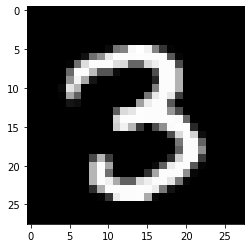

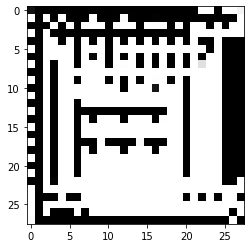

'epoch:  1401 ' [discriminator loss:  3.7973788  and acc:  0.5 ] [generator loss:  0.0018823226  and acc:  1.0 ]
'epoch:  1402 ' [discriminator loss:  3.82699  and acc:  0.5 ] [generator loss:  0.001710086  and acc:  1.0 ]
'epoch:  1403 ' [discriminator loss:  3.8546462  and acc:  0.5 ] [generator loss:  0.0017073585  and acc:  1.0 ]
'epoch:  1404 ' [discriminator loss:  3.8436525  and acc:  0.5 ] [generator loss:  0.0019045566  and acc:  1.0 ]
'epoch:  1405 ' [discriminator loss:  3.855929  and acc:  0.5 ] [generator loss:  0.0017420158  and acc:  1.0 ]
'epoch:  1406 ' [discriminator loss:  3.8470092  and acc:  0.49804688 ] [generator loss:  0.0012596068  and acc:  1.0 ]
'epoch:  1407 ' [discriminator loss:  3.9327798  and acc:  0.5 ] [generator loss:  0.0016899258  and acc:  1.0 ]
'epoch:  1408 ' [discriminator loss:  3.8599873  and acc:  0.5 ] [generator loss:  0.0016009063  and acc:  1.0 ]
'epoch:  1409 ' [discriminator loss:  3.8711586  and acc:  0.5 ] [generator loss:  0.00160514

'epoch:  1474 ' [discriminator loss:  4.10982  and acc:  0.5 ] [generator loss:  0.0012147416  and acc:  1.0 ]
'epoch:  1475 ' [discriminator loss:  4.0800576  and acc:  0.5 ] [generator loss:  0.0011982804  and acc:  1.0 ]
'epoch:  1476 ' [discriminator loss:  4.097376  and acc:  0.5 ] [generator loss:  0.0012149543  and acc:  1.0 ]
'epoch:  1477 ' [discriminator loss:  4.089695  and acc:  0.5 ] [generator loss:  0.0012870987  and acc:  1.0 ]
'epoch:  1478 ' [discriminator loss:  4.1526546  and acc:  0.5 ] [generator loss:  0.0011954303  and acc:  1.0 ]
'epoch:  1479 ' [discriminator loss:  4.1386805  and acc:  0.5 ] [generator loss:  0.0013085202  and acc:  1.0 ]
'epoch:  1480 ' [discriminator loss:  4.1456776  and acc:  0.5 ] [generator loss:  0.0011946473  and acc:  1.0 ]
'epoch:  1481 ' [discriminator loss:  4.1452417  and acc:  0.5 ] [generator loss:  0.00116416  and acc:  1.0 ]
'epoch:  1482 ' [discriminator loss:  4.108587  and acc:  0.5 ] [generator loss:  0.0012357036  and ac

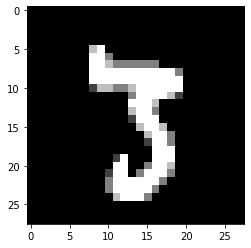

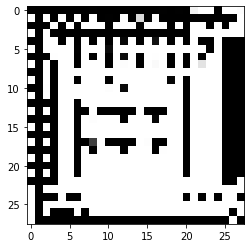

'epoch:  1501 ' [discriminator loss:  4.1591654  and acc:  0.5 ] [generator loss:  0.0011851217  and acc:  1.0 ]
'epoch:  1502 ' [discriminator loss:  4.169767  and acc:  0.5 ] [generator loss:  0.0011314284  and acc:  1.0 ]
'epoch:  1503 ' [discriminator loss:  4.1472497  and acc:  0.5 ] [generator loss:  0.0011713  and acc:  1.0 ]
'epoch:  1504 ' [discriminator loss:  4.3587418  and acc:  0.49804688 ] [generator loss:  0.00077179685  and acc:  1.0 ]
'epoch:  1505 ' [discriminator loss:  4.2957225  and acc:  0.5 ] [generator loss:  0.0011234108  and acc:  1.0 ]
'epoch:  1506 ' [discriminator loss:  4.203142  and acc:  0.5 ] [generator loss:  0.0010072812  and acc:  1.0 ]
'epoch:  1507 ' [discriminator loss:  4.17138  and acc:  0.5 ] [generator loss:  0.0010991142  and acc:  1.0 ]
'epoch:  1508 ' [discriminator loss:  4.205281  and acc:  0.5 ] [generator loss:  0.001053532  and acc:  1.0 ]
'epoch:  1509 ' [discriminator loss:  4.1427093  and acc:  0.5 ] [generator loss:  0.0010393095  

'epoch:  1574 ' [discriminator loss:  4.638983  and acc:  0.5 ] [generator loss:  0.000746381  and acc:  1.0 ]
'epoch:  1575 ' [discriminator loss:  4.6370173  and acc:  0.5 ] [generator loss:  0.00061619707  and acc:  1.0 ]
'epoch:  1576 ' [discriminator loss:  4.480069  and acc:  0.5 ] [generator loss:  0.000713334  and acc:  1.0 ]
'epoch:  1577 ' [discriminator loss:  4.487895  and acc:  0.5 ] [generator loss:  0.0006865321  and acc:  1.0 ]
'epoch:  1578 ' [discriminator loss:  4.5349817  and acc:  0.5 ] [generator loss:  0.0006976401  and acc:  1.0 ]
'epoch:  1579 ' [discriminator loss:  4.528949  and acc:  0.5 ] [generator loss:  0.00066777243  and acc:  1.0 ]
'epoch:  1580 ' [discriminator loss:  4.4802933  and acc:  0.5 ] [generator loss:  0.00071923406  and acc:  1.0 ]
'epoch:  1581 ' [discriminator loss:  4.545825  and acc:  0.5 ] [generator loss:  0.0006358653  and acc:  1.0 ]
'epoch:  1582 ' [discriminator loss:  4.525295  and acc:  0.5 ] [generator loss:  0.00076995615  and

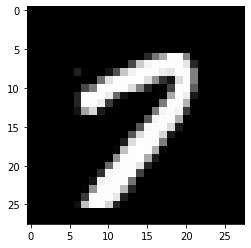

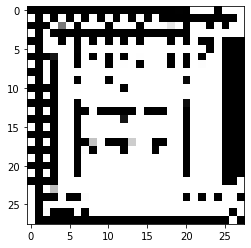

'epoch:  1601 ' [discriminator loss:  4.59235  and acc:  0.5 ] [generator loss:  0.00065443397  and acc:  1.0 ]
'epoch:  1602 ' [discriminator loss:  4.5995913  and acc:  0.49804688 ] [generator loss:  0.00045894025  and acc:  1.0 ]
'epoch:  1603 ' [discriminator loss:  4.6702366  and acc:  0.5 ] [generator loss:  0.0006825703  and acc:  1.0 ]
'epoch:  1604 ' [discriminator loss:  4.6624756  and acc:  0.5 ] [generator loss:  0.0006313725  and acc:  1.0 ]
'epoch:  1605 ' [discriminator loss:  4.662439  and acc:  0.5 ] [generator loss:  0.00056317623  and acc:  1.0 ]
'epoch:  1606 ' [discriminator loss:  4.576009  and acc:  0.5 ] [generator loss:  0.00069083134  and acc:  1.0 ]
'epoch:  1607 ' [discriminator loss:  4.685289  and acc:  0.5 ] [generator loss:  0.0005852203  and acc:  1.0 ]
'epoch:  1608 ' [discriminator loss:  4.6236525  and acc:  0.5 ] [generator loss:  0.0006361434  and acc:  1.0 ]
'epoch:  1609 ' [discriminator loss:  4.716238  and acc:  0.5 ] [generator loss:  0.000599

'epoch:  1674 ' [discriminator loss:  4.8728685  and acc:  0.5 ] [generator loss:  0.00048227812  and acc:  1.0 ]
'epoch:  1675 ' [discriminator loss:  4.890701  and acc:  0.5 ] [generator loss:  0.00052304904  and acc:  1.0 ]
'epoch:  1676 ' [discriminator loss:  4.9512796  and acc:  0.5 ] [generator loss:  0.00044941806  and acc:  1.0 ]
'epoch:  1677 ' [discriminator loss:  4.902857  and acc:  0.5 ] [generator loss:  0.0005117256  and acc:  1.0 ]
'epoch:  1678 ' [discriminator loss:  4.851842  and acc:  0.5 ] [generator loss:  0.00043661377  and acc:  1.0 ]
'epoch:  1679 ' [discriminator loss:  4.8010135  and acc:  0.5 ] [generator loss:  0.0005327251  and acc:  1.0 ]
'epoch:  1680 ' [discriminator loss:  4.854002  and acc:  0.49804688 ] [generator loss:  0.00039726018  and acc:  1.0 ]
'epoch:  1681 ' [discriminator loss:  4.905651  and acc:  0.5 ] [generator loss:  0.0005010826  and acc:  1.0 ]
'epoch:  1682 ' [discriminator loss:  4.956506  and acc:  0.5 ] [generator loss:  0.00046

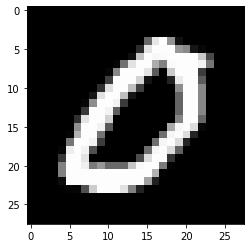

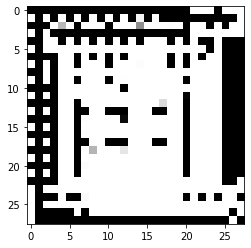

'epoch:  1701 ' [discriminator loss:  5.096063  and acc:  0.5 ] [generator loss:  0.00040582084  and acc:  1.0 ]
'epoch:  1702 ' [discriminator loss:  5.041811  and acc:  0.5 ] [generator loss:  0.00042893208  and acc:  1.0 ]
'epoch:  1703 ' [discriminator loss:  5.092491  and acc:  0.5 ] [generator loss:  0.00035012426  and acc:  1.0 ]
'epoch:  1704 ' [discriminator loss:  4.8994603  and acc:  0.5 ] [generator loss:  0.00047929515  and acc:  1.0 ]
'epoch:  1705 ' [discriminator loss:  5.1314597  and acc:  0.5 ] [generator loss:  0.000362232  and acc:  1.0 ]
'epoch:  1706 ' [discriminator loss:  4.9713116  and acc:  0.5 ] [generator loss:  0.00045901106  and acc:  1.0 ]
'epoch:  1707 ' [discriminator loss:  5.0826073  and acc:  0.5 ] [generator loss:  0.0003984257  and acc:  1.0 ]
'epoch:  1708 ' [discriminator loss:  4.978113  and acc:  0.5 ] [generator loss:  0.00042378035  and acc:  1.0 ]
'epoch:  1709 ' [discriminator loss:  5.0595126  and acc:  0.5 ] [generator loss:  0.0003679667

'epoch:  1774 ' [discriminator loss:  5.305873  and acc:  0.5 ] [generator loss:  0.00038271467  and acc:  1.0 ]
'epoch:  1775 ' [discriminator loss:  5.330593  and acc:  0.5 ] [generator loss:  0.00024702674  and acc:  1.0 ]
'epoch:  1776 ' [discriminator loss:  5.130143  and acc:  0.5 ] [generator loss:  0.00040676584  and acc:  1.0 ]
'epoch:  1777 ' [discriminator loss:  5.38352  and acc:  0.5 ] [generator loss:  0.00026825938  and acc:  1.0 ]
'epoch:  1778 ' [discriminator loss:  5.1425524  and acc:  0.5 ] [generator loss:  0.0003565823  and acc:  1.0 ]
'epoch:  1779 ' [discriminator loss:  5.335349  and acc:  0.5 ] [generator loss:  0.0003134744  and acc:  1.0 ]
'epoch:  1780 ' [discriminator loss:  5.2627296  and acc:  0.5 ] [generator loss:  0.00034873647  and acc:  1.0 ]
'epoch:  1781 ' [discriminator loss:  5.3305993  and acc:  0.5 ] [generator loss:  0.00028263766  and acc:  1.0 ]
'epoch:  1782 ' [discriminator loss:  5.1834493  and acc:  0.5 ] [generator loss:  0.0004165051 

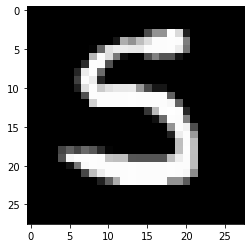

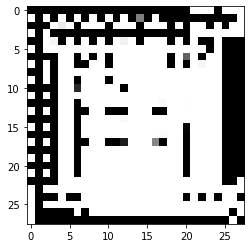

'epoch:  1801 ' [discriminator loss:  5.3448763  and acc:  0.5 ] [generator loss:  0.00026738996  and acc:  1.0 ]
'epoch:  1802 ' [discriminator loss:  5.2576017  and acc:  0.5 ] [generator loss:  0.00035689725  and acc:  1.0 ]
'epoch:  1803 ' [discriminator loss:  5.478258  and acc:  0.5 ] [generator loss:  0.00025877185  and acc:  1.0 ]
'epoch:  1804 ' [discriminator loss:  5.320117  and acc:  0.5 ] [generator loss:  0.00033617753  and acc:  1.0 ]
'epoch:  1805 ' [discriminator loss:  5.413101  and acc:  0.5 ] [generator loss:  0.00028410205  and acc:  1.0 ]
'epoch:  1806 ' [discriminator loss:  5.3424263  and acc:  0.5 ] [generator loss:  0.00031808607  and acc:  1.0 ]
'epoch:  1807 ' [discriminator loss:  5.3295465  and acc:  0.5 ] [generator loss:  0.00027858166  and acc:  1.0 ]
'epoch:  1808 ' [discriminator loss:  5.3535643  and acc:  0.5 ] [generator loss:  0.00034578284  and acc:  1.0 ]
'epoch:  1809 ' [discriminator loss:  5.434121  and acc:  0.5 ] [generator loss:  0.0002954

'epoch:  1873 ' [discriminator loss:  5.7432437  and acc:  0.5 ] [generator loss:  0.0002153655  and acc:  1.0 ]
'epoch:  1874 ' [discriminator loss:  5.676036  and acc:  0.5 ] [generator loss:  0.00015147914  and acc:  1.0 ]
'epoch:  1875 ' [discriminator loss:  5.357272  and acc:  0.5 ] [generator loss:  0.00031204656  and acc:  1.0 ]
'epoch:  1876 ' [discriminator loss:  5.879141  and acc:  0.49804688 ] [generator loss:  0.00012919825  and acc:  1.0 ]
'epoch:  1877 ' [discriminator loss:  5.4654217  and acc:  0.5 ] [generator loss:  0.00026551847  and acc:  1.0 ]
'epoch:  1878 ' [discriminator loss:  5.6497974  and acc:  0.5 ] [generator loss:  0.0001740421  and acc:  1.0 ]
'epoch:  1879 ' [discriminator loss:  5.3526845  and acc:  0.5 ] [generator loss:  0.00022617151  and acc:  1.0 ]
'epoch:  1880 ' [discriminator loss:  5.420065  and acc:  0.5 ] [generator loss:  0.00023335271  and acc:  1.0 ]
'epoch:  1881 ' [discriminator loss:  5.558346  and acc:  0.5 ] [generator loss:  0.000

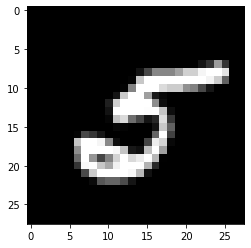

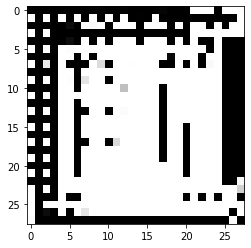

'epoch:  1901 ' [discriminator loss:  5.7095795  and acc:  0.5 ] [generator loss:  0.00026325948  and acc:  1.0 ]
'epoch:  1902 ' [discriminator loss:  5.852058  and acc:  0.5 ] [generator loss:  0.00031694086  and acc:  1.0 ]
'epoch:  1903 ' [discriminator loss:  6.7240524  and acc:  0.49804688 ] [generator loss:  5.18647e-05  and acc:  1.0 ]
'epoch:  1904 ' [discriminator loss:  5.607518  and acc:  0.5 ] [generator loss:  0.0003324687  and acc:  1.0 ]
'epoch:  1905 ' [discriminator loss:  6.038889  and acc:  0.5 ] [generator loss:  0.0001299419  and acc:  1.0 ]
'epoch:  1906 ' [discriminator loss:  5.3652873  and acc:  0.5 ] [generator loss:  0.00037657333  and acc:  1.0 ]
'epoch:  1907 ' [discriminator loss:  6.121804  and acc:  0.5 ] [generator loss:  0.00012206366  and acc:  1.0 ]
'epoch:  1908 ' [discriminator loss:  5.44375  and acc:  0.5 ] [generator loss:  0.0003117811  and acc:  1.0 ]
'epoch:  1909 ' [discriminator loss:  5.7379875  and acc:  0.5 ] [generator loss:  0.0001743

'epoch:  1974 ' [discriminator loss:  5.1902266  and acc:  0.5 ] [generator loss:  0.00052691624  and acc:  1.0 ]
'epoch:  1975 ' [discriminator loss:  5.7070303  and acc:  0.5 ] [generator loss:  0.0002588391  and acc:  1.0 ]
'epoch:  1976 ' [discriminator loss:  5.2299623  and acc:  0.5 ] [generator loss:  0.00053320325  and acc:  1.0 ]
'epoch:  1977 ' [discriminator loss:  5.611938  and acc:  0.5 ] [generator loss:  0.00027731725  and acc:  1.0 ]
'epoch:  1978 ' [discriminator loss:  5.2070236  and acc:  0.5 ] [generator loss:  0.0005145865  and acc:  1.0 ]
'epoch:  1979 ' [discriminator loss:  5.598895  and acc:  0.5 ] [generator loss:  0.00029750977  and acc:  1.0 ]
'epoch:  1980 ' [discriminator loss:  5.263814  and acc:  0.5 ] [generator loss:  0.00048914715  and acc:  1.0 ]
'epoch:  1981 ' [discriminator loss:  5.5200334  and acc:  0.5 ] [generator loss:  0.00034938665  and acc:  1.0 ]
'epoch:  1982 ' [discriminator loss:  5.3492775  and acc:  0.49804688 ] [generator loss:  0.0

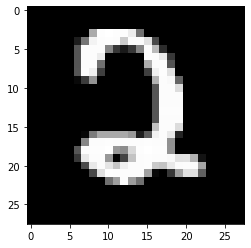

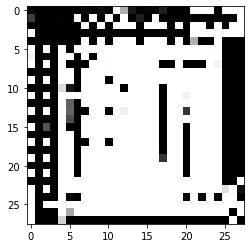

'epoch:  2001 ' [discriminator loss:  5.6674604  and acc:  0.5 ] [generator loss:  0.00021646931  and acc:  1.0 ]
'epoch:  2002 ' [discriminator loss:  5.1675406  and acc:  0.5 ] [generator loss:  0.00051142613  and acc:  1.0 ]
'epoch:  2003 ' [discriminator loss:  5.749362  and acc:  0.49804688 ] [generator loss:  0.00020546858  and acc:  1.0 ]
'epoch:  2004 ' [discriminator loss:  5.487074  and acc:  0.5 ] [generator loss:  0.0003357115  and acc:  1.0 ]
'epoch:  2005 ' [discriminator loss:  5.4292326  and acc:  0.5 ] [generator loss:  0.0003936654  and acc:  1.0 ]
'epoch:  2006 ' [discriminator loss:  5.6619368  and acc:  0.5 ] [generator loss:  0.00027585772  and acc:  1.0 ]
'epoch:  2007 ' [discriminator loss:  5.3472624  and acc:  0.5 ] [generator loss:  0.00036028645  and acc:  1.0 ]
'epoch:  2008 ' [discriminator loss:  5.400681  and acc:  0.5 ] [generator loss:  0.00033080962  and acc:  1.0 ]
'epoch:  2009 ' [discriminator loss:  5.335704  and acc:  0.5 ] [generator loss:  0.00

'epoch:  2074 ' [discriminator loss:  5.593049  and acc:  0.5 ] [generator loss:  0.00036820446  and acc:  1.0 ]
'epoch:  2075 ' [discriminator loss:  5.2360744  and acc:  0.5 ] [generator loss:  0.0005865537  and acc:  1.0 ]
'epoch:  2076 ' [discriminator loss:  5.5052404  and acc:  0.5 ] [generator loss:  0.00043670667  and acc:  1.0 ]
'epoch:  2077 ' [discriminator loss:  5.3392997  and acc:  0.5 ] [generator loss:  0.00053612754  and acc:  1.0 ]
'epoch:  2078 ' [discriminator loss:  5.4453425  and acc:  0.5 ] [generator loss:  0.0005684284  and acc:  1.0 ]
'epoch:  2079 ' [discriminator loss:  5.706435  and acc:  0.49804688 ] [generator loss:  0.0001650856  and acc:  1.0 ]
'epoch:  2080 ' [discriminator loss:  5.155552  and acc:  0.5 ] [generator loss:  0.0009172666  and acc:  1.0 ]
'epoch:  2081 ' [discriminator loss:  6.025378  and acc:  0.5 ] [generator loss:  0.00020221132  and acc:  1.0 ]
'epoch:  2082 ' [discriminator loss:  5.4233065  and acc:  0.49804688 ] [generator loss: 

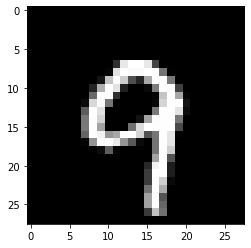

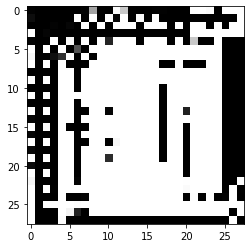

'epoch:  2101 ' [discriminator loss:  5.0755086  and acc:  0.5 ] [generator loss:  0.0008144733  and acc:  1.0 ]
'epoch:  2102 ' [discriminator loss:  5.561781  and acc:  0.5 ] [generator loss:  0.0003838928  and acc:  1.0 ]
'epoch:  2103 ' [discriminator loss:  5.1817846  and acc:  0.5 ] [generator loss:  0.0006266245  and acc:  1.0 ]
'epoch:  2104 ' [discriminator loss:  5.2159424  and acc:  0.5 ] [generator loss:  0.00057309086  and acc:  1.0 ]
'epoch:  2105 ' [discriminator loss:  5.2188225  and acc:  0.5 ] [generator loss:  0.00072727614  and acc:  1.0 ]
'epoch:  2106 ' [discriminator loss:  5.4534273  and acc:  0.5 ] [generator loss:  0.00043312216  and acc:  1.0 ]
'epoch:  2107 ' [discriminator loss:  5.0866423  and acc:  0.5 ] [generator loss:  0.00077869033  and acc:  1.0 ]
'epoch:  2108 ' [discriminator loss:  5.537181  and acc:  0.5 ] [generator loss:  0.00047770466  and acc:  1.0 ]
'epoch:  2109 ' [discriminator loss:  5.151285  and acc:  0.49804688 ] [generator loss:  0.00

'epoch:  2174 ' [discriminator loss:  5.212221  and acc:  0.5 ] [generator loss:  0.00062695297  and acc:  1.0 ]
'epoch:  2175 ' [discriminator loss:  5.155793  and acc:  0.5 ] [generator loss:  0.0006440879  and acc:  1.0 ]
'epoch:  2176 ' [discriminator loss:  5.2344575  and acc:  0.5 ] [generator loss:  0.0005973705  and acc:  1.0 ]
'epoch:  2177 ' [discriminator loss:  5.226082  and acc:  0.5 ] [generator loss:  0.0006505068  and acc:  1.0 ]
'epoch:  2178 ' [discriminator loss:  5.3294945  and acc:  0.5 ] [generator loss:  0.000598392  and acc:  1.0 ]
'epoch:  2179 ' [discriminator loss:  5.336022  and acc:  0.5 ] [generator loss:  0.00060805515  and acc:  1.0 ]
'epoch:  2180 ' [discriminator loss:  5.287017  and acc:  0.5 ] [generator loss:  0.00062391965  and acc:  1.0 ]
'epoch:  2181 ' [discriminator loss:  5.2408657  and acc:  0.5 ] [generator loss:  0.0006042387  and acc:  1.0 ]
'epoch:  2182 ' [discriminator loss:  5.31271  and acc:  0.5 ] [generator loss:  0.0006572421  and 

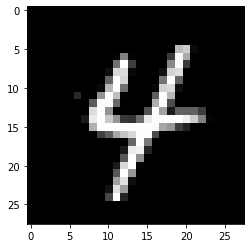

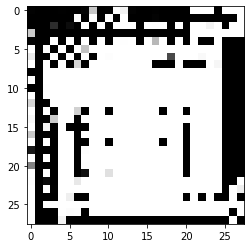

'epoch:  2201 ' [discriminator loss:  5.82111  and acc:  0.5 ] [generator loss:  0.00023581332  and acc:  1.0 ]
'epoch:  2202 ' [discriminator loss:  4.936631  and acc:  0.5 ] [generator loss:  0.00112013  and acc:  1.0 ]
'epoch:  2203 ' [discriminator loss:  5.8437223  and acc:  0.5 ] [generator loss:  0.00026015096  and acc:  1.0 ]
'epoch:  2204 ' [discriminator loss:  4.88027  and acc:  0.5 ] [generator loss:  0.0011502316  and acc:  1.0 ]
'epoch:  2205 ' [discriminator loss:  5.7512197  and acc:  0.5 ] [generator loss:  0.0003127713  and acc:  1.0 ]
'epoch:  2206 ' [discriminator loss:  4.9303017  and acc:  0.5 ] [generator loss:  0.0011959631  and acc:  1.0 ]
'epoch:  2207 ' [discriminator loss:  5.7756953  and acc:  0.5 ] [generator loss:  0.00032234268  and acc:  1.0 ]
'epoch:  2208 ' [discriminator loss:  4.8769636  and acc:  0.5 ] [generator loss:  0.001138703  and acc:  1.0 ]
'epoch:  2209 ' [discriminator loss:  5.5397305  and acc:  0.5 ] [generator loss:  0.0004142463  and 

'epoch:  2274 ' [discriminator loss:  5.3383646  and acc:  0.5 ] [generator loss:  0.0006613892  and acc:  1.0 ]
'epoch:  2275 ' [discriminator loss:  4.7232437  and acc:  0.5 ] [generator loss:  0.0015680704  and acc:  1.0 ]
'epoch:  2276 ' [discriminator loss:  5.2987995  and acc:  0.5 ] [generator loss:  0.0007967504  and acc:  1.0 ]
'epoch:  2277 ' [discriminator loss:  4.7598066  and acc:  0.5 ] [generator loss:  0.0014245817  and acc:  1.0 ]
'epoch:  2278 ' [discriminator loss:  5.1181726  and acc:  0.5 ] [generator loss:  0.0009772262  and acc:  1.0 ]
'epoch:  2279 ' [discriminator loss:  6.024132  and acc:  0.49609375 ] [generator loss:  0.00043456355  and acc:  1.0 ]
'epoch:  2280 ' [discriminator loss:  5.0186467  and acc:  0.5 ] [generator loss:  0.0022562952  and acc:  1.0 ]
'epoch:  2281 ' [discriminator loss:  6.211564  and acc:  0.5 ] [generator loss:  0.0002467077  and acc:  1.0 ]
'epoch:  2282 ' [discriminator loss:  4.8223715  and acc:  0.5 ] [generator loss:  0.00152

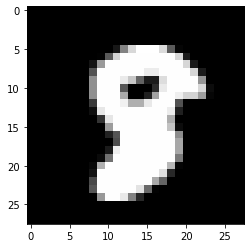

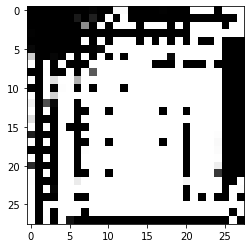

'epoch:  2301 ' [discriminator loss:  4.69249  and acc:  0.5 ] [generator loss:  0.0018159589  and acc:  1.0 ]
'epoch:  2302 ' [discriminator loss:  5.2966523  and acc:  0.5 ] [generator loss:  0.00065075187  and acc:  1.0 ]
'epoch:  2303 ' [discriminator loss:  4.644315  and acc:  0.5 ] [generator loss:  0.0022442641  and acc:  1.0 ]
'epoch:  2304 ' [discriminator loss:  5.5999603  and acc:  0.5 ] [generator loss:  0.0005459768  and acc:  1.0 ]
'epoch:  2305 ' [discriminator loss:  4.652571  and acc:  0.5 ] [generator loss:  0.0017332153  and acc:  1.0 ]
'epoch:  2306 ' [discriminator loss:  5.1953816  and acc:  0.5 ] [generator loss:  0.0010908953  and acc:  1.0 ]
'epoch:  2307 ' [discriminator loss:  4.8402863  and acc:  0.5 ] [generator loss:  0.0015538981  and acc:  1.0 ]
'epoch:  2308 ' [discriminator loss:  5.129901  and acc:  0.5 ] [generator loss:  0.00117564  and acc:  1.0 ]
'epoch:  2309 ' [discriminator loss:  4.9346156  and acc:  0.5 ] [generator loss:  0.0014717211  and a

'epoch:  2374 ' [discriminator loss:  4.6341815  and acc:  0.5 ] [generator loss:  0.0023704825  and acc:  1.0 ]
'epoch:  2375 ' [discriminator loss:  5.485133  and acc:  0.5 ] [generator loss:  0.0006219851  and acc:  1.0 ]
'epoch:  2376 ' [discriminator loss:  4.5685654  and acc:  0.5 ] [generator loss:  0.0026883138  and acc:  1.0 ]
'epoch:  2377 ' [discriminator loss:  5.620467  and acc:  0.5 ] [generator loss:  0.0004696711  and acc:  1.0 ]
'epoch:  2378 ' [discriminator loss:  4.4888315  and acc:  0.5 ] [generator loss:  0.0026984299  and acc:  1.0 ]
'epoch:  2379 ' [discriminator loss:  5.453162  and acc:  0.5 ] [generator loss:  0.0006444465  and acc:  1.0 ]
'epoch:  2380 ' [discriminator loss:  4.552558  and acc:  0.5 ] [generator loss:  0.0026769345  and acc:  1.0 ]
'epoch:  2381 ' [discriminator loss:  5.381464  and acc:  0.5 ] [generator loss:  0.0007893933  and acc:  1.0 ]
'epoch:  2382 ' [discriminator loss:  4.681002  and acc:  0.5 ] [generator loss:  0.0027999128  and a

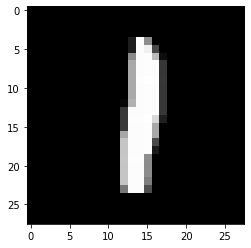

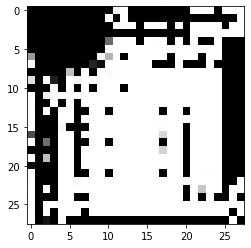

'epoch:  2401 ' [discriminator loss:  4.561906  and acc:  0.5 ] [generator loss:  0.0023060788  and acc:  1.0 ]
'epoch:  2402 ' [discriminator loss:  4.7836385  and acc:  0.5 ] [generator loss:  0.0015679367  and acc:  1.0 ]
'epoch:  2403 ' [discriminator loss:  4.603521  and acc:  0.5 ] [generator loss:  0.0023209709  and acc:  1.0 ]
'epoch:  2404 ' [discriminator loss:  4.8392153  and acc:  0.5 ] [generator loss:  0.0017704067  and acc:  1.0 ]
'epoch:  2405 ' [discriminator loss:  4.684982  and acc:  0.5 ] [generator loss:  0.0018541792  and acc:  1.0 ]
'epoch:  2406 ' [discriminator loss:  4.653944  and acc:  0.5 ] [generator loss:  0.0021943538  and acc:  1.0 ]
'epoch:  2407 ' [discriminator loss:  4.818289  and acc:  0.5 ] [generator loss:  0.0014863843  and acc:  1.0 ]
'epoch:  2408 ' [discriminator loss:  4.5160503  and acc:  0.5 ] [generator loss:  0.0023908832  and acc:  1.0 ]
'epoch:  2409 ' [discriminator loss:  4.8529468  and acc:  0.5 ] [generator loss:  0.0014782617  and 

'epoch:  2474 ' [discriminator loss:  4.6412883  and acc:  0.5 ] [generator loss:  0.0027026027  and acc:  1.0 ]
'epoch:  2475 ' [discriminator loss:  4.708836  and acc:  0.5 ] [generator loss:  0.0020118845  and acc:  1.0 ]
'epoch:  2476 ' [discriminator loss:  4.4602585  and acc:  0.5 ] [generator loss:  0.003235551  and acc:  1.0 ]
'epoch:  2477 ' [discriminator loss:  4.9628243  and acc:  0.5 ] [generator loss:  0.0015129748  and acc:  1.0 ]
'epoch:  2478 ' [discriminator loss:  4.3453503  and acc:  0.5 ] [generator loss:  0.0032737167  and acc:  1.0 ]
'epoch:  2479 ' [discriminator loss:  4.9133987  and acc:  0.5 ] [generator loss:  0.001617973  and acc:  1.0 ]
'epoch:  2480 ' [discriminator loss:  4.4090605  and acc:  0.5 ] [generator loss:  0.0034850067  and acc:  1.0 ]
'epoch:  2481 ' [discriminator loss:  4.9917574  and acc:  0.5 ] [generator loss:  0.0015983329  and acc:  1.0 ]
'epoch:  2482 ' [discriminator loss:  4.3996  and acc:  0.5 ] [generator loss:  0.0032103118  and a

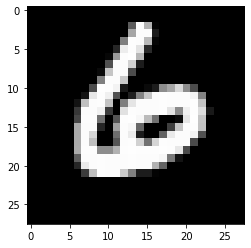

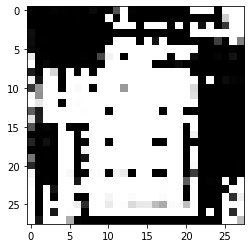

'epoch:  2501 ' [discriminator loss:  4.199536  and acc:  0.5 ] [generator loss:  0.0035153823  and acc:  1.0 ]
'epoch:  2502 ' [discriminator loss:  4.717959  and acc:  0.5 ] [generator loss:  0.0018989155  and acc:  1.0 ]
'epoch:  2503 ' [discriminator loss:  4.308431  and acc:  0.5 ] [generator loss:  0.0031467977  and acc:  1.0 ]
'epoch:  2504 ' [discriminator loss:  4.667067  and acc:  0.5 ] [generator loss:  0.0020096893  and acc:  1.0 ]
'epoch:  2505 ' [discriminator loss:  4.407743  and acc:  0.5 ] [generator loss:  0.0033421328  and acc:  1.0 ]
'epoch:  2506 ' [discriminator loss:  4.800371  and acc:  0.5 ] [generator loss:  0.0018723196  and acc:  1.0 ]
'epoch:  2507 ' [discriminator loss:  4.335536  and acc:  0.5 ] [generator loss:  0.003349407  and acc:  1.0 ]
'epoch:  2508 ' [discriminator loss:  4.7433624  and acc:  0.5 ] [generator loss:  0.0018394574  and acc:  1.0 ]
'epoch:  2509 ' [discriminator loss:  4.3508186  and acc:  0.5 ] [generator loss:  0.0034122996  and acc

'epoch:  2574 ' [discriminator loss:  4.105303  and acc:  0.5 ] [generator loss:  0.0048781796  and acc:  1.0 ]
'epoch:  2575 ' [discriminator loss:  4.808135  and acc:  0.5 ] [generator loss:  0.0013932723  and acc:  1.0 ]
'epoch:  2576 ' [discriminator loss:  4.0452604  and acc:  0.5 ] [generator loss:  0.0060075875  and acc:  1.0 ]
'epoch:  2577 ' [discriminator loss:  5.069849  and acc:  0.5 ] [generator loss:  0.0011522787  and acc:  1.0 ]
'epoch:  2578 ' [discriminator loss:  4.57064  and acc:  0.49804688 ] [generator loss:  0.0017510309  and acc:  1.0 ]
'epoch:  2579 ' [discriminator loss:  4.5099235  and acc:  0.5 ] [generator loss:  0.005886644  and acc:  1.0 ]
'epoch:  2580 ' [discriminator loss:  5.3111267  and acc:  0.5 ] [generator loss:  0.0010197796  and acc:  1.0 ]
'epoch:  2581 ' [discriminator loss:  4.2310996  and acc:  0.5 ] [generator loss:  0.0042404747  and acc:  1.0 ]
'epoch:  2582 ' [discriminator loss:  4.712782  and acc:  0.5 ] [generator loss:  0.0021624418 

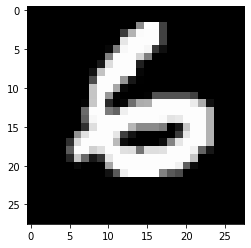

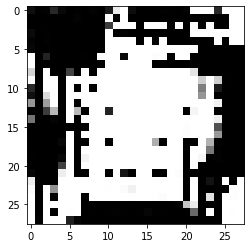

'epoch:  2601 ' [discriminator loss:  4.126761  and acc:  0.5 ] [generator loss:  0.0060941707  and acc:  1.0 ]
'epoch:  2602 ' [discriminator loss:  4.8977017  and acc:  0.5 ] [generator loss:  0.001664788  and acc:  1.0 ]
'epoch:  2603 ' [discriminator loss:  4.0587044  and acc:  0.5 ] [generator loss:  0.005609923  and acc:  1.0 ]
'epoch:  2604 ' [discriminator loss:  4.674177  and acc:  0.5 ] [generator loss:  0.0022634547  and acc:  1.0 ]
'epoch:  2605 ' [discriminator loss:  4.1144185  and acc:  0.5 ] [generator loss:  0.0061050598  and acc:  1.0 ]
'epoch:  2606 ' [discriminator loss:  4.762783  and acc:  0.5 ] [generator loss:  0.0020419084  and acc:  1.0 ]
'epoch:  2607 ' [discriminator loss:  4.0977564  and acc:  0.5 ] [generator loss:  0.006002642  and acc:  1.0 ]
'epoch:  2608 ' [discriminator loss:  4.65026  and acc:  0.5 ] [generator loss:  0.0021437607  and acc:  1.0 ]
'epoch:  2609 ' [discriminator loss:  3.9913626  and acc:  0.5 ] [generator loss:  0.0059782034  and acc

'epoch:  2674 ' [discriminator loss:  3.944518  and acc:  0.5 ] [generator loss:  0.008076805  and acc:  1.0 ]
'epoch:  2675 ' [discriminator loss:  4.897649  and acc:  0.5 ] [generator loss:  0.001588631  and acc:  1.0 ]
'epoch:  2676 ' [discriminator loss:  3.8834758  and acc:  0.5 ] [generator loss:  0.007963469  and acc:  1.0 ]
'epoch:  2677 ' [discriminator loss:  4.6383986  and acc:  0.5 ] [generator loss:  0.0025244935  and acc:  1.0 ]
'epoch:  2678 ' [discriminator loss:  3.9508958  and acc:  0.5 ] [generator loss:  0.0072147595  and acc:  1.0 ]
'epoch:  2679 ' [discriminator loss:  4.492592  and acc:  0.5 ] [generator loss:  0.0029984892  and acc:  1.0 ]
'epoch:  2680 ' [discriminator loss:  3.8924983  and acc:  0.5 ] [generator loss:  0.007570212  and acc:  1.0 ]
'epoch:  2681 ' [discriminator loss:  4.542238  and acc:  0.5 ] [generator loss:  0.0028012139  and acc:  1.0 ]
'epoch:  2682 ' [discriminator loss:  3.9109836  and acc:  0.5 ] [generator loss:  0.0077366526  and acc

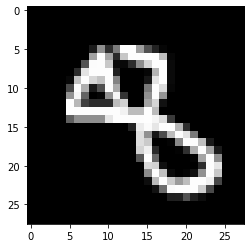

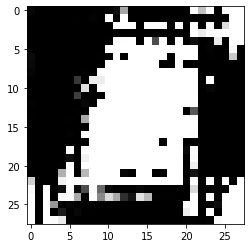

'epoch:  2701 ' [discriminator loss:  4.2816463  and acc:  0.5 ] [generator loss:  0.0034322466  and acc:  1.0 ]
'epoch:  2702 ' [discriminator loss:  3.7106323  and acc:  0.5 ] [generator loss:  0.007896574  and acc:  1.0 ]
'epoch:  2703 ' [discriminator loss:  4.108287  and acc:  0.5 ] [generator loss:  0.004459832  and acc:  1.0 ]
'epoch:  2704 ' [discriminator loss:  3.773917  and acc:  0.5 ] [generator loss:  0.0072662532  and acc:  1.0 ]
'epoch:  2705 ' [discriminator loss:  4.0705924  and acc:  0.5 ] [generator loss:  0.005161481  and acc:  1.0 ]
'epoch:  2706 ' [discriminator loss:  3.870783  and acc:  0.5 ] [generator loss:  0.0068693627  and acc:  1.0 ]
'epoch:  2707 ' [discriminator loss:  4.085697  and acc:  0.5 ] [generator loss:  0.0052341092  and acc:  1.0 ]
'epoch:  2708 ' [discriminator loss:  3.8296762  and acc:  0.5 ] [generator loss:  0.006786543  and acc:  1.0 ]
'epoch:  2709 ' [discriminator loss:  4.0494547  and acc:  0.5 ] [generator loss:  0.005414759  and acc:

'epoch:  2774 ' [discriminator loss:  4.2104354  and acc:  0.5 ] [generator loss:  0.0035664313  and acc:  1.0 ]
'epoch:  2775 ' [discriminator loss:  3.904686  and acc:  0.5 ] [generator loss:  0.0067040185  and acc:  1.0 ]
'epoch:  2776 ' [discriminator loss:  4.2541456  and acc:  0.5 ] [generator loss:  0.0037400366  and acc:  1.0 ]
'epoch:  2777 ' [discriminator loss:  3.9441485  and acc:  0.5 ] [generator loss:  0.006871948  and acc:  1.0 ]
'epoch:  2778 ' [discriminator loss:  4.425292  and acc:  0.5 ] [generator loss:  0.0034289286  and acc:  1.0 ]
'epoch:  2779 ' [discriminator loss:  3.9671845  and acc:  0.5 ] [generator loss:  0.00725217  and acc:  1.0 ]
'epoch:  2780 ' [discriminator loss:  4.525358  and acc:  0.5 ] [generator loss:  0.002858262  and acc:  1.0 ]
'epoch:  2781 ' [discriminator loss:  3.962772  and acc:  0.5 ] [generator loss:  0.009850915  and acc:  1.0 ]
'epoch:  2782 ' [discriminator loss:  4.8703203  and acc:  0.5 ] [generator loss:  0.0022497834  and acc:

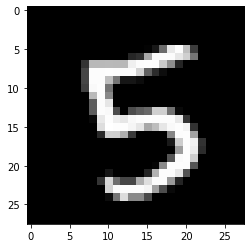

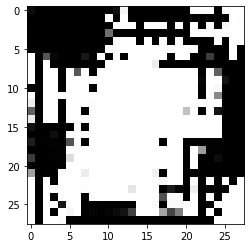

'epoch:  2801 ' [discriminator loss:  3.9772053  and acc:  0.5 ] [generator loss:  0.0065726996  and acc:  1.0 ]
'epoch:  2802 ' [discriminator loss:  4.393408  and acc:  0.5 ] [generator loss:  0.003787167  and acc:  1.0 ]
'epoch:  2803 ' [discriminator loss:  4.0155287  and acc:  0.5 ] [generator loss:  0.0070736064  and acc:  1.0 ]
'epoch:  2804 ' [discriminator loss:  4.7840037  and acc:  0.5 ] [generator loss:  0.003096519  and acc:  1.0 ]
'epoch:  2805 ' [discriminator loss:  4.252856  and acc:  0.5 ] [generator loss:  0.0086606555  and acc:  1.0 ]
'epoch:  2806 ' [discriminator loss:  4.7533674  and acc:  0.5 ] [generator loss:  0.0024294944  and acc:  1.0 ]
'epoch:  2807 ' [discriminator loss:  3.866589  and acc:  0.5 ] [generator loss:  0.008042101  and acc:  1.0 ]
'epoch:  2808 ' [discriminator loss:  4.713146  and acc:  0.49804688 ] [generator loss:  0.0019087476  and acc:  1.0 ]
'epoch:  2809 ' [discriminator loss:  4.0474005  and acc:  0.5 ] [generator loss:  0.0076485905 

'epoch:  2874 ' [discriminator loss:  4.342926  and acc:  0.5 ] [generator loss:  0.0038316725  and acc:  1.0 ]
'epoch:  2875 ' [discriminator loss:  3.786746  and acc:  0.5 ] [generator loss:  0.010364443  and acc:  1.0 ]
'epoch:  2876 ' [discriminator loss:  4.562708  and acc:  0.5 ] [generator loss:  0.0033825622  and acc:  1.0 ]
'epoch:  2877 ' [discriminator loss:  3.8742516  and acc:  0.5 ] [generator loss:  0.012891656  and acc:  1.0 ]
'epoch:  2878 ' [discriminator loss:  4.7282505  and acc:  0.5 ] [generator loss:  0.0020013608  and acc:  1.0 ]
'epoch:  2879 ' [discriminator loss:  3.6220214  and acc:  0.5 ] [generator loss:  0.013234388  and acc:  1.0 ]
'epoch:  2880 ' [discriminator loss:  4.5859904  and acc:  0.5 ] [generator loss:  0.0028558816  and acc:  1.0 ]
'epoch:  2881 ' [discriminator loss:  3.6991942  and acc:  0.5 ] [generator loss:  0.0115124695  and acc:  1.0 ]
'epoch:  2882 ' [discriminator loss:  4.571974  and acc:  0.5 ] [generator loss:  0.003820905  and acc

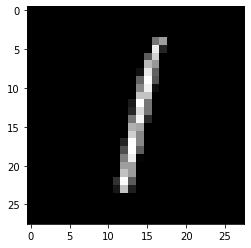

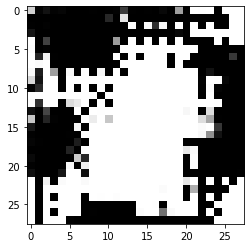

'epoch:  2901 ' [discriminator loss:  3.7605934  and acc:  0.5 ] [generator loss:  0.013264567  and acc:  1.0 ]
'epoch:  2902 ' [discriminator loss:  4.413356  and acc:  0.5 ] [generator loss:  0.0036560288  and acc:  1.0 ]
'epoch:  2903 ' [discriminator loss:  3.6247318  and acc:  0.5 ] [generator loss:  0.013729266  and acc:  1.0 ]
'epoch:  2904 ' [discriminator loss:  4.464425  and acc:  0.5 ] [generator loss:  0.0035510226  and acc:  1.0 ]
'epoch:  2905 ' [discriminator loss:  3.661462  and acc:  0.5 ] [generator loss:  0.012416523  and acc:  1.0 ]
'epoch:  2906 ' [discriminator loss:  4.3175564  and acc:  0.5 ] [generator loss:  0.0044754483  and acc:  1.0 ]
'epoch:  2907 ' [discriminator loss:  3.75313  and acc:  0.49804688 ] [generator loss:  0.008767077  and acc:  1.0 ]
'epoch:  2908 ' [discriminator loss:  4.149386  and acc:  0.5 ] [generator loss:  0.007776987  and acc:  1.0 ]
'epoch:  2909 ' [discriminator loss:  3.9293966  and acc:  0.5 ] [generator loss:  0.007688997  and 

'epoch:  2974 ' [discriminator loss:  5.4512434  and acc:  0.49609375 ] [generator loss:  0.0006056906  and acc:  1.0 ]
'epoch:  2975 ' [discriminator loss:  4.069496  and acc:  0.5 ] [generator loss:  0.00949152  and acc:  1.0 ]
'epoch:  2976 ' [discriminator loss:  4.268898  and acc:  0.5 ] [generator loss:  0.00440049  and acc:  1.0 ]
'epoch:  2977 ' [discriminator loss:  3.7672658  and acc:  0.5 ] [generator loss:  0.013360407  and acc:  1.0 ]
'epoch:  2978 ' [discriminator loss:  4.96188  and acc:  0.5 ] [generator loss:  0.0031982462  and acc:  1.0 ]
'epoch:  2979 ' [discriminator loss:  3.8028696  and acc:  0.5 ] [generator loss:  0.012122154  and acc:  1.0 ]
'epoch:  2980 ' [discriminator loss:  4.586361  and acc:  0.5 ] [generator loss:  0.0036210176  and acc:  1.0 ]
'epoch:  2981 ' [discriminator loss:  3.7107432  and acc:  0.5 ] [generator loss:  0.014157002  and acc:  1.0 ]
'epoch:  2982 ' [discriminator loss:  4.980981  and acc:  0.5 ] [generator loss:  0.0032339697  and a

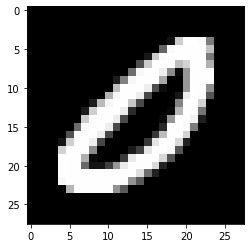

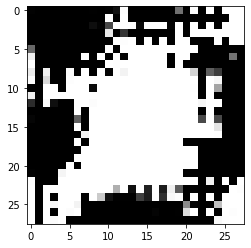

'epoch:  3001 ' [discriminator loss:  3.4722977  and acc:  0.5 ] [generator loss:  0.026118377  and acc:  1.0 ]
'epoch:  3002 ' [discriminator loss:  4.789298  and acc:  0.5 ] [generator loss:  0.0028420498  and acc:  1.0 ]
'epoch:  3003 ' [discriminator loss:  3.466453  and acc:  0.5 ] [generator loss:  0.023458488  and acc:  1.0 ]
'epoch:  3004 ' [discriminator loss:  4.2271404  and acc:  0.5 ] [generator loss:  0.0066689774  and acc:  1.0 ]
'epoch:  3005 ' [discriminator loss:  3.4134536  and acc:  0.5 ] [generator loss:  0.022126347  and acc:  1.0 ]
'epoch:  3006 ' [discriminator loss:  4.7077756  and acc:  0.49804688 ] [generator loss:  0.004495942  and acc:  1.0 ]
'epoch:  3007 ' [discriminator loss:  3.4095688  and acc:  0.5 ] [generator loss:  0.020620923  and acc:  1.0 ]
'epoch:  3008 ' [discriminator loss:  4.154267  and acc:  0.5 ] [generator loss:  0.0058240136  and acc:  1.0 ]
'epoch:  3009 ' [discriminator loss:  3.3803017  and acc:  0.5 ] [generator loss:  0.020620817  a

'epoch:  3075 ' [discriminator loss:  3.859786  and acc:  0.5 ] [generator loss:  0.0103724  and acc:  1.0 ]
'epoch:  3076 ' [discriminator loss:  3.2220178  and acc:  0.5 ] [generator loss:  0.028711788  and acc:  1.0 ]
'epoch:  3077 ' [discriminator loss:  3.9895694  and acc:  0.49804688 ] [generator loss:  0.00516616  and acc:  1.0 ]
'epoch:  3078 ' [discriminator loss:  3.252616  and acc:  0.5 ] [generator loss:  0.030018538  and acc:  1.0 ]
'epoch:  3079 ' [discriminator loss:  4.030306  and acc:  0.5 ] [generator loss:  0.007947126  and acc:  1.0 ]
'epoch:  3080 ' [discriminator loss:  3.2846084  and acc:  0.5 ] [generator loss:  0.028726496  and acc:  1.0 ]
'epoch:  3081 ' [discriminator loss:  3.975317  and acc:  0.5 ] [generator loss:  0.009285851  and acc:  1.0 ]
'epoch:  3082 ' [discriminator loss:  3.2525225  and acc:  0.5 ] [generator loss:  0.0364258  and acc:  1.0 ]
'epoch:  3083 ' [discriminator loss:  4.0942106  and acc:  0.5 ] [generator loss:  0.007031807  and acc:  

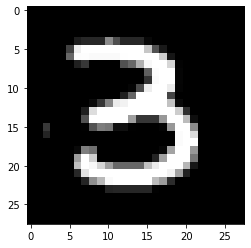

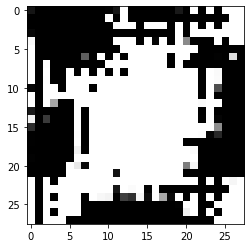

'epoch:  3101 ' [discriminator loss:  4.0454583  and acc:  0.5 ] [generator loss:  0.008752879  and acc:  1.0 ]
'epoch:  3102 ' [discriminator loss:  3.3181224  and acc:  0.5 ] [generator loss:  0.03741911  and acc:  1.0 ]
'epoch:  3103 ' [discriminator loss:  4.0742617  and acc:  0.5 ] [generator loss:  0.007831374  and acc:  1.0 ]
'epoch:  3104 ' [discriminator loss:  3.227204  and acc:  0.5 ] [generator loss:  0.024085095  and acc:  1.0 ]
'epoch:  3105 ' [discriminator loss:  3.5011744  and acc:  0.5 ] [generator loss:  0.017348446  and acc:  1.0 ]
'epoch:  3106 ' [discriminator loss:  3.4181309  and acc:  0.49804688 ] [generator loss:  0.010063119  and acc:  1.0 ]
'epoch:  3107 ' [discriminator loss:  3.2866488  and acc:  0.5 ] [generator loss:  0.02508821  and acc:  1.0 ]
'epoch:  3108 ' [discriminator loss:  3.925849  and acc:  0.49804688 ] [generator loss:  0.0059036743  and acc:  1.0 ]
'epoch:  3109 ' [discriminator loss:  3.3071785  and acc:  0.5 ] [generator loss:  0.02325157

'epoch:  3174 ' [discriminator loss:  3.1086175  and acc:  0.5 ] [generator loss:  0.027923062  and acc:  1.0 ]
'epoch:  3175 ' [discriminator loss:  3.7924273  and acc:  0.5 ] [generator loss:  0.010563852  and acc:  1.0 ]
'epoch:  3176 ' [discriminator loss:  3.2100272  and acc:  0.5 ] [generator loss:  0.027261946  and acc:  1.0 ]
'epoch:  3177 ' [discriminator loss:  3.7939763  and acc:  0.49804688 ] [generator loss:  0.0045386543  and acc:  1.0 ]
'epoch:  3178 ' [discriminator loss:  3.1850667  and acc:  0.5 ] [generator loss:  0.025966873  and acc:  1.0 ]
'epoch:  3179 ' [discriminator loss:  3.7006395  and acc:  0.5 ] [generator loss:  0.011861594  and acc:  1.0 ]
'epoch:  3180 ' [discriminator loss:  3.2237577  and acc:  0.5 ] [generator loss:  0.023589998  and acc:  1.0 ]
'epoch:  3181 ' [discriminator loss:  3.6463447  and acc:  0.5 ] [generator loss:  0.012790881  and acc:  1.0 ]
'epoch:  3182 ' [discriminator loss:  3.2577076  and acc:  0.5 ] [generator loss:  0.027477095  

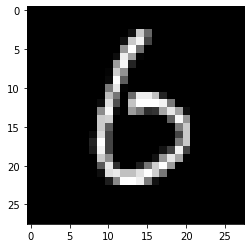

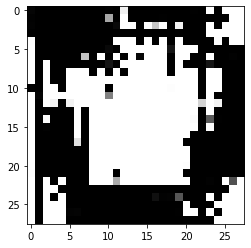

'epoch:  3201 ' [discriminator loss:  3.2983637  and acc:  0.5 ] [generator loss:  0.018959312  and acc:  1.0 ]
'epoch:  3202 ' [discriminator loss:  3.1920667  and acc:  0.5 ] [generator loss:  0.019635767  and acc:  1.0 ]
'epoch:  3203 ' [discriminator loss:  3.1719618  and acc:  0.5 ] [generator loss:  0.022155194  and acc:  1.0 ]
'epoch:  3204 ' [discriminator loss:  3.2853284  and acc:  0.5 ] [generator loss:  0.017689569  and acc:  1.0 ]
'epoch:  3205 ' [discriminator loss:  3.1408567  and acc:  0.5 ] [generator loss:  0.022315936  and acc:  1.0 ]
'epoch:  3206 ' [discriminator loss:  3.2606988  and acc:  0.5 ] [generator loss:  0.017959075  and acc:  1.0 ]
'epoch:  3207 ' [discriminator loss:  3.1331353  and acc:  0.5 ] [generator loss:  0.023554463  and acc:  1.0 ]
'epoch:  3208 ' [discriminator loss:  3.3306036  and acc:  0.5 ] [generator loss:  0.01697432  and acc:  1.0 ]
'epoch:  3209 ' [discriminator loss:  3.1245487  and acc:  0.5 ] [generator loss:  0.023146171  and acc: 

'epoch:  3275 ' [discriminator loss:  3.1704109  and acc:  0.5 ] [generator loss:  0.015367425  and acc:  1.0 ]
'epoch:  3276 ' [discriminator loss:  3.065516  and acc:  0.5 ] [generator loss:  0.017002173  and acc:  1.0 ]
'epoch:  3277 ' [discriminator loss:  3.199307  and acc:  0.5 ] [generator loss:  0.016105289  and acc:  1.0 ]
'epoch:  3278 ' [discriminator loss:  3.1692395  and acc:  0.5 ] [generator loss:  0.015057528  and acc:  1.0 ]
'epoch:  3279 ' [discriminator loss:  3.171962  and acc:  0.5 ] [generator loss:  0.016245252  and acc:  1.0 ]
'epoch:  3280 ' [discriminator loss:  3.2529068  and acc:  0.5 ] [generator loss:  0.016894381  and acc:  1.0 ]
'epoch:  3281 ' [discriminator loss:  3.196855  and acc:  0.5 ] [generator loss:  0.016580177  and acc:  1.0 ]
'epoch:  3282 ' [discriminator loss:  3.2593632  and acc:  0.5 ] [generator loss:  0.014218046  and acc:  1.0 ]
'epoch:  3283 ' [discriminator loss:  3.2406535  and acc:  0.5 ] [generator loss:  0.017500933  and acc:  1.

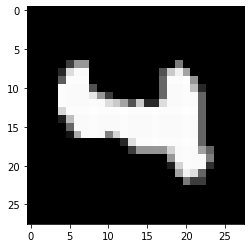

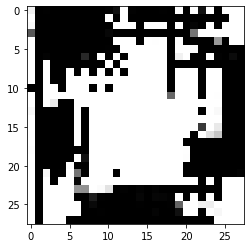

'epoch:  3301 ' [discriminator loss:  3.0898032  and acc:  0.5 ] [generator loss:  0.018698864  and acc:  1.0 ]
'epoch:  3302 ' [discriminator loss:  3.6276736  and acc:  0.49414062 ] [generator loss:  0.004832518  and acc:  1.0 ]
'epoch:  3303 ' [discriminator loss:  3.2134213  and acc:  0.5 ] [generator loss:  0.015230887  and acc:  1.0 ]
'epoch:  3304 ' [discriminator loss:  3.3327587  and acc:  0.5 ] [generator loss:  0.010171423  and acc:  1.0 ]
'epoch:  3305 ' [discriminator loss:  3.1414864  and acc:  0.5 ] [generator loss:  0.012496889  and acc:  1.0 ]
'epoch:  3306 ' [discriminator loss:  3.1422455  and acc:  0.5 ] [generator loss:  0.013143709  and acc:  1.0 ]
'epoch:  3307 ' [discriminator loss:  3.2538188  and acc:  0.5 ] [generator loss:  0.01218901  and acc:  1.0 ]
'epoch:  3308 ' [discriminator loss:  3.2291903  and acc:  0.5 ] [generator loss:  0.011802709  and acc:  1.0 ]
'epoch:  3309 ' [discriminator loss:  3.2171576  and acc:  0.5 ] [generator loss:  0.012836542  an

'epoch:  3375 ' [discriminator loss:  3.536183  and acc:  0.5 ] [generator loss:  0.0078941565  and acc:  1.0 ]
'epoch:  3376 ' [discriminator loss:  3.6029353  and acc:  0.5 ] [generator loss:  0.007602163  and acc:  1.0 ]
'epoch:  3377 ' [discriminator loss:  3.682304  and acc:  0.5 ] [generator loss:  0.006846423  and acc:  1.0 ]
'epoch:  3378 ' [discriminator loss:  3.5616689  and acc:  0.5 ] [generator loss:  0.008371197  and acc:  1.0 ]
'epoch:  3379 ' [discriminator loss:  3.659964  and acc:  0.5 ] [generator loss:  0.0067603868  and acc:  1.0 ]
'epoch:  3380 ' [discriminator loss:  3.57025  and acc:  0.5 ] [generator loss:  0.00893189  and acc:  1.0 ]
'epoch:  3381 ' [discriminator loss:  3.778335  and acc:  0.5 ] [generator loss:  0.006315399  and acc:  1.0 ]
'epoch:  3382 ' [discriminator loss:  3.591701  and acc:  0.5 ] [generator loss:  0.0081989765  and acc:  1.0 ]
'epoch:  3383 ' [discriminator loss:  3.760446  and acc:  0.49804688 ] [generator loss:  0.004020664  and acc

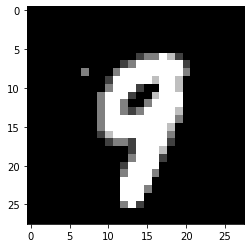

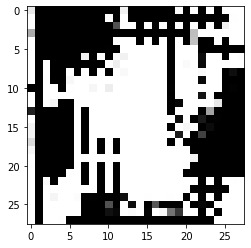

'epoch:  3401 ' [discriminator loss:  3.67773  and acc:  0.5 ] [generator loss:  0.0067005474  and acc:  1.0 ]
'epoch:  3402 ' [discriminator loss:  3.6791863  and acc:  0.5 ] [generator loss:  0.007202681  and acc:  1.0 ]
'epoch:  3403 ' [discriminator loss:  3.7482123  and acc:  0.5 ] [generator loss:  0.0063156984  and acc:  1.0 ]
'epoch:  3404 ' [discriminator loss:  3.7339487  and acc:  0.5 ] [generator loss:  0.0076068398  and acc:  1.0 ]
'epoch:  3405 ' [discriminator loss:  3.837854  and acc:  0.5 ] [generator loss:  0.005862615  and acc:  1.0 ]
'epoch:  3406 ' [discriminator loss:  3.7124655  and acc:  0.5 ] [generator loss:  0.0074584926  and acc:  1.0 ]
'epoch:  3407 ' [discriminator loss:  3.7322712  and acc:  0.5 ] [generator loss:  0.00672858  and acc:  1.0 ]
'epoch:  3408 ' [discriminator loss:  3.735846  and acc:  0.5 ] [generator loss:  0.006183643  and acc:  1.0 ]
'epoch:  3409 ' [discriminator loss:  3.6162364  and acc:  0.5 ] [generator loss:  0.0066916794  and acc:

'epoch:  3474 ' [discriminator loss:  3.861312  and acc:  0.5 ] [generator loss:  0.004725395  and acc:  1.0 ]
'epoch:  3475 ' [discriminator loss:  3.7204888  and acc:  0.5 ] [generator loss:  0.0054220688  and acc:  1.0 ]
'epoch:  3476 ' [discriminator loss:  3.805016  and acc:  0.5 ] [generator loss:  0.0051914398  and acc:  1.0 ]
'epoch:  3477 ' [discriminator loss:  3.7926025  and acc:  0.5 ] [generator loss:  0.005344325  and acc:  1.0 ]
'epoch:  3478 ' [discriminator loss:  3.8900914  and acc:  0.5 ] [generator loss:  0.00552902  and acc:  1.0 ]
'epoch:  3479 ' [discriminator loss:  4.003806  and acc:  0.5 ] [generator loss:  0.0050782943  and acc:  1.0 ]
'epoch:  3480 ' [discriminator loss:  3.785162  and acc:  0.5 ] [generator loss:  0.005444523  and acc:  1.0 ]
'epoch:  3481 ' [discriminator loss:  3.8464499  and acc:  0.5 ] [generator loss:  0.0047533866  and acc:  1.0 ]
'epoch:  3482 ' [discriminator loss:  3.778096  and acc:  0.5 ] [generator loss:  0.005809995  and acc:  

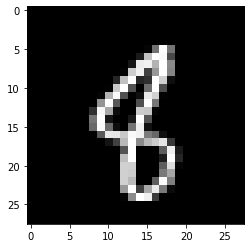

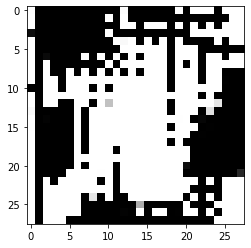

'epoch:  3501 ' [discriminator loss:  3.806316  and acc:  0.5 ] [generator loss:  0.004809522  and acc:  1.0 ]
'epoch:  3502 ' [discriminator loss:  3.894701  and acc:  0.5 ] [generator loss:  0.0058025224  and acc:  1.0 ]
'epoch:  3503 ' [discriminator loss:  3.837267  and acc:  0.5 ] [generator loss:  0.004885867  and acc:  1.0 ]
'epoch:  3504 ' [discriminator loss:  3.7436712  and acc:  0.5 ] [generator loss:  0.005228175  and acc:  1.0 ]
'epoch:  3505 ' [discriminator loss:  3.7557268  and acc:  0.5 ] [generator loss:  0.0049007977  and acc:  1.0 ]
'epoch:  3506 ' [discriminator loss:  3.700092  and acc:  0.5 ] [generator loss:  0.0054366845  and acc:  1.0 ]
'epoch:  3507 ' [discriminator loss:  3.809526  and acc:  0.5 ] [generator loss:  0.0047695544  and acc:  1.0 ]
'epoch:  3508 ' [discriminator loss:  3.809093  and acc:  0.5 ] [generator loss:  0.00605034  and acc:  1.0 ]
'epoch:  3509 ' [discriminator loss:  3.8962698  and acc:  0.5 ] [generator loss:  0.0044511603  and acc:  

'epoch:  3574 ' [discriminator loss:  3.7466626  and acc:  0.5 ] [generator loss:  0.004551013  and acc:  1.0 ]
'epoch:  3575 ' [discriminator loss:  3.8376548  and acc:  0.5 ] [generator loss:  0.0038546603  and acc:  1.0 ]
'epoch:  3576 ' [discriminator loss:  3.7972221  and acc:  0.5 ] [generator loss:  0.004217335  and acc:  1.0 ]
'epoch:  3577 ' [discriminator loss:  3.809545  and acc:  0.5 ] [generator loss:  0.004238275  and acc:  1.0 ]
'epoch:  3578 ' [discriminator loss:  3.8215027  and acc:  0.5 ] [generator loss:  0.003871916  and acc:  1.0 ]
'epoch:  3579 ' [discriminator loss:  3.780198  and acc:  0.5 ] [generator loss:  0.004377519  and acc:  1.0 ]
'epoch:  3580 ' [discriminator loss:  3.834866  and acc:  0.5 ] [generator loss:  0.004126109  and acc:  1.0 ]
'epoch:  3581 ' [discriminator loss:  3.887436  and acc:  0.5 ] [generator loss:  0.004039033  and acc:  1.0 ]
'epoch:  3582 ' [discriminator loss:  3.84727  and acc:  0.5 ] [generator loss:  0.0040688002  and acc:  1.

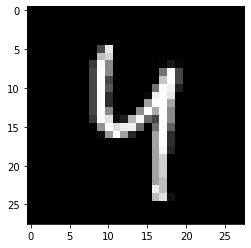

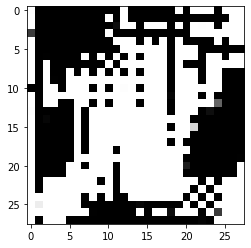

'epoch:  3601 ' [discriminator loss:  3.9381378  and acc:  0.5 ] [generator loss:  0.004011179  and acc:  1.0 ]
'epoch:  3602 ' [discriminator loss:  4.037635  and acc:  0.5 ] [generator loss:  0.0042517004  and acc:  1.0 ]
'epoch:  3603 ' [discriminator loss:  3.9366894  and acc:  0.5 ] [generator loss:  0.0037901576  and acc:  1.0 ]
'epoch:  3604 ' [discriminator loss:  3.9168575  and acc:  0.5 ] [generator loss:  0.003946232  and acc:  1.0 ]
'epoch:  3605 ' [discriminator loss:  3.9285555  and acc:  0.5 ] [generator loss:  0.004218841  and acc:  1.0 ]
'epoch:  3606 ' [discriminator loss:  3.9380198  and acc:  0.5 ] [generator loss:  0.0040075164  and acc:  1.0 ]
'epoch:  3607 ' [discriminator loss:  3.9336452  and acc:  0.5 ] [generator loss:  0.0038293432  and acc:  1.0 ]
'epoch:  3608 ' [discriminator loss:  3.909837  and acc:  0.5 ] [generator loss:  0.0037780686  and acc:  1.0 ]
'epoch:  3609 ' [discriminator loss:  3.8818638  and acc:  0.5 ] [generator loss:  0.0042824843  and 

'epoch:  3674 ' [discriminator loss:  3.996726  and acc:  0.5 ] [generator loss:  0.0033264766  and acc:  1.0 ]
'epoch:  3675 ' [discriminator loss:  4.114103  and acc:  0.5 ] [generator loss:  0.0026265318  and acc:  1.0 ]
'epoch:  3676 ' [discriminator loss:  3.9501514  and acc:  0.5 ] [generator loss:  0.0031533076  and acc:  1.0 ]
'epoch:  3677 ' [discriminator loss:  4.064488  and acc:  0.5 ] [generator loss:  0.0028776065  and acc:  1.0 ]
'epoch:  3678 ' [discriminator loss:  4.016821  and acc:  0.5 ] [generator loss:  0.0030456944  and acc:  1.0 ]
'epoch:  3679 ' [discriminator loss:  4.0895195  and acc:  0.5 ] [generator loss:  0.003036485  and acc:  1.0 ]
'epoch:  3680 ' [discriminator loss:  4.1551185  and acc:  0.5 ] [generator loss:  0.0026612047  and acc:  1.0 ]
'epoch:  3681 ' [discriminator loss:  4.053481  and acc:  0.5 ] [generator loss:  0.003179356  and acc:  1.0 ]
'epoch:  3682 ' [discriminator loss:  4.169736  and acc:  0.5 ] [generator loss:  0.002551958  and acc:

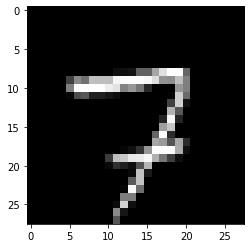

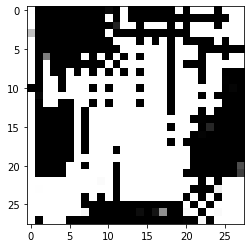

'epoch:  3701 ' [discriminator loss:  4.1367087  and acc:  0.5 ] [generator loss:  0.0030222752  and acc:  1.0 ]
'epoch:  3702 ' [discriminator loss:  4.286601  and acc:  0.5 ] [generator loss:  0.002317336  and acc:  1.0 ]
'epoch:  3703 ' [discriminator loss:  4.1199546  and acc:  0.5 ] [generator loss:  0.0033257066  and acc:  1.0 ]
'epoch:  3704 ' [discriminator loss:  4.3462076  and acc:  0.5 ] [generator loss:  0.002117374  and acc:  1.0 ]
'epoch:  3705 ' [discriminator loss:  4.089159  and acc:  0.5 ] [generator loss:  0.0031011105  and acc:  1.0 ]
'epoch:  3706 ' [discriminator loss:  4.3421803  and acc:  0.5 ] [generator loss:  0.0024183707  and acc:  1.0 ]
'epoch:  3707 ' [discriminator loss:  4.2319107  and acc:  0.5 ] [generator loss:  0.0029257974  and acc:  1.0 ]
'epoch:  3708 ' [discriminator loss:  4.2913446  and acc:  0.5 ] [generator loss:  0.002483108  and acc:  1.0 ]
'epoch:  3709 ' [discriminator loss:  4.142064  and acc:  0.5 ] [generator loss:  0.0027100963  and a

'epoch:  3775 ' [discriminator loss:  4.2574034  and acc:  0.5 ] [generator loss:  0.0023900466  and acc:  1.0 ]
'epoch:  3776 ' [discriminator loss:  4.1517467  and acc:  0.5 ] [generator loss:  0.0029176562  and acc:  1.0 ]
'epoch:  3777 ' [discriminator loss:  4.2401776  and acc:  0.5 ] [generator loss:  0.00250028  and acc:  1.0 ]
'epoch:  3778 ' [discriminator loss:  4.1121426  and acc:  0.5 ] [generator loss:  0.0029266998  and acc:  1.0 ]
'epoch:  3779 ' [discriminator loss:  4.2433014  and acc:  0.5 ] [generator loss:  0.0025729109  and acc:  1.0 ]
'epoch:  3780 ' [discriminator loss:  4.187395  and acc:  0.5 ] [generator loss:  0.0029593229  and acc:  1.0 ]
'epoch:  3781 ' [discriminator loss:  4.282892  and acc:  0.5 ] [generator loss:  0.0025918386  and acc:  1.0 ]
'epoch:  3782 ' [discriminator loss:  4.132795  and acc:  0.5 ] [generator loss:  0.0026354834  and acc:  1.0 ]
'epoch:  3783 ' [discriminator loss:  4.101062  and acc:  0.5 ] [generator loss:  0.0029305147  and a

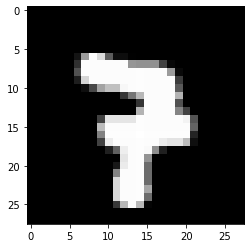

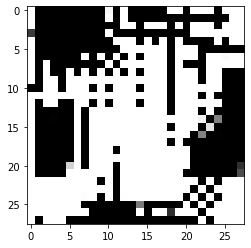

'epoch:  3801 ' [discriminator loss:  4.440014  and acc:  0.5 ] [generator loss:  0.0019697319  and acc:  1.0 ]
'epoch:  3802 ' [discriminator loss:  4.1578093  and acc:  0.5 ] [generator loss:  0.0028037669  and acc:  1.0 ]
'epoch:  3803 ' [discriminator loss:  4.1898527  and acc:  0.5 ] [generator loss:  0.0023955745  and acc:  1.0 ]
'epoch:  3804 ' [discriminator loss:  4.1178646  and acc:  0.5 ] [generator loss:  0.0025317834  and acc:  1.0 ]
'epoch:  3805 ' [discriminator loss:  4.1012135  and acc:  0.5 ] [generator loss:  0.002848969  and acc:  1.0 ]
'epoch:  3806 ' [discriminator loss:  4.3555717  and acc:  0.5 ] [generator loss:  0.00224164  and acc:  1.0 ]
'epoch:  3807 ' [discriminator loss:  4.218863  and acc:  0.5 ] [generator loss:  0.0029711276  and acc:  1.0 ]
'epoch:  3808 ' [discriminator loss:  4.311289  and acc:  0.5 ] [generator loss:  0.0021112962  and acc:  1.0 ]
'epoch:  3809 ' [discriminator loss:  4.1190667  and acc:  0.5 ] [generator loss:  0.002815445  and ac

'epoch:  3874 ' [discriminator loss:  4.2787175  and acc:  0.5 ] [generator loss:  0.0024926024  and acc:  1.0 ]
'epoch:  3875 ' [discriminator loss:  4.272312  and acc:  0.5 ] [generator loss:  0.0022962252  and acc:  1.0 ]
'epoch:  3876 ' [discriminator loss:  4.2301297  and acc:  0.5 ] [generator loss:  0.0024727457  and acc:  1.0 ]
'epoch:  3877 ' [discriminator loss:  4.317465  and acc:  0.5 ] [generator loss:  0.0021443656  and acc:  1.0 ]
'epoch:  3878 ' [discriminator loss:  4.2538986  and acc:  0.5 ] [generator loss:  0.0026159198  and acc:  1.0 ]
'epoch:  3879 ' [discriminator loss:  4.272359  and acc:  0.5 ] [generator loss:  0.0020719501  and acc:  1.0 ]
'epoch:  3880 ' [discriminator loss:  4.150159  and acc:  0.5 ] [generator loss:  0.002859747  and acc:  1.0 ]
'epoch:  3881 ' [discriminator loss:  4.3669987  and acc:  0.5 ] [generator loss:  0.0018774839  and acc:  1.0 ]
'epoch:  3882 ' [discriminator loss:  4.1455326  and acc:  0.5 ] [generator loss:  0.0029584144  and 

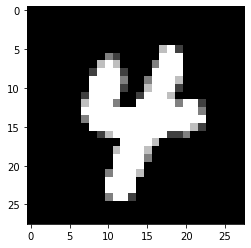

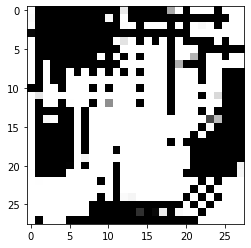

'epoch:  3901 ' [discriminator loss:  4.4007792  and acc:  0.5 ] [generator loss:  0.0019472904  and acc:  1.0 ]
'epoch:  3902 ' [discriminator loss:  4.387454  and acc:  0.5 ] [generator loss:  0.0020884383  and acc:  1.0 ]
'epoch:  3903 ' [discriminator loss:  4.447221  and acc:  0.5 ] [generator loss:  0.0019112673  and acc:  1.0 ]
'epoch:  3904 ' [discriminator loss:  4.3357115  and acc:  0.5 ] [generator loss:  0.0020058057  and acc:  1.0 ]
'epoch:  3905 ' [discriminator loss:  4.385706  and acc:  0.5 ] [generator loss:  0.0018391113  and acc:  1.0 ]
'epoch:  3906 ' [discriminator loss:  4.341053  and acc:  0.5 ] [generator loss:  0.0022264419  and acc:  1.0 ]
'epoch:  3907 ' [discriminator loss:  4.515156  and acc:  0.5 ] [generator loss:  0.001809398  and acc:  1.0 ]
'epoch:  3908 ' [discriminator loss:  4.386309  and acc:  0.5 ] [generator loss:  0.0021052659  and acc:  1.0 ]
'epoch:  3909 ' [discriminator loss:  4.514471  and acc:  0.49804688 ] [generator loss:  0.0012589269  

'epoch:  3974 ' [discriminator loss:  4.471936  and acc:  0.5 ] [generator loss:  0.0017737063  and acc:  1.0 ]
'epoch:  3975 ' [discriminator loss:  4.357522  and acc:  0.5 ] [generator loss:  0.00227146  and acc:  1.0 ]
'epoch:  3976 ' [discriminator loss:  4.437276  and acc:  0.5 ] [generator loss:  0.0020696737  and acc:  1.0 ]
'epoch:  3977 ' [discriminator loss:  4.398046  and acc:  0.5 ] [generator loss:  0.0019420739  and acc:  1.0 ]
'epoch:  3978 ' [discriminator loss:  4.326702  and acc:  0.5 ] [generator loss:  0.0020729862  and acc:  1.0 ]
'epoch:  3979 ' [discriminator loss:  4.374982  and acc:  0.5 ] [generator loss:  0.0022752215  and acc:  1.0 ]
'epoch:  3980 ' [discriminator loss:  4.506549  and acc:  0.5 ] [generator loss:  0.0017756198  and acc:  1.0 ]
'epoch:  3981 ' [discriminator loss:  4.4185133  and acc:  0.5 ] [generator loss:  0.0024871356  and acc:  1.0 ]
'epoch:  3982 ' [discriminator loss:  4.4181843  and acc:  0.5 ] [generator loss:  0.0017082426  and acc:

In [17]:
noise_dim = 1
epoch_num = 4000
batch_size = 256
X_train, X_test, Y_train, Y_test = load_data()

d_loss_tracker = []
g_loss_tracker = []
d_acc_tracker = []
g_acc_tracker = []

for epoch in range(epoch_num):
    noise_input = np.random.uniform(-1, 1, size = [batch_size, 100])
    fake_images = generator_model.predict(noise_input)

    for discriminator_epochs in range(1):
        genuine_images = X_train[np.random.randint(
            0, X_train.shape[0], size = batch_size), :, :, :]
        
        X_input = np.concatenate((genuine_images, fake_images))
        Y_label = np.ones([2 * batch_size, 1])
        Y_label[batch_size : , : ] = 0 

        d_loss = discriminator_compilation.train_on_batch(X_input, Y_label)
    
    Y_label = np.ones([batch_size, 1])
    g_loss = generator_compilation.train_on_batch(noise_input, Y_label)
    print("\'epoch: ", epoch,"\' [discriminator loss: ", d_loss[0], " and acc: ", d_loss[1],"] [generator loss: ",
          g_loss[0]," and acc: ", g_loss[1],"]")

    d_loss_tracker.append(d_loss[0])
    g_loss_tracker.append(g_loss[0])
    d_acc_tracker.append(d_loss[1])
    g_acc_tracker.append(g_loss[1])
    
    if epoch % 100 == 0:
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(genuine_images[0, :, :, 0], cmap='gray')
        plt.show()
        plt.imshow(fake_images[0, :, :, 0], cmap='gray')
        plt.show()

'epoch:  0 ' [discriminator loss:  0.2120057  and acc:  0.9980469 ] [generator loss:  1.6273742  and acc:  0.0 ]


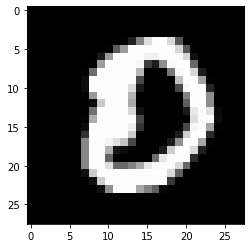

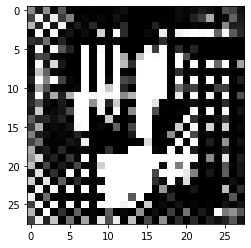

'epoch:  1 ' [discriminator loss:  0.2588336  and acc:  0.9667969 ] [generator loss:  1.5793582  and acc:  0.0 ]
'epoch:  2 ' [discriminator loss:  0.26327544  and acc:  0.9589844 ] [generator loss:  1.57215  and acc:  0.0 ]
'epoch:  3 ' [discriminator loss:  0.2925654  and acc:  0.90625 ] [generator loss:  1.5528827  and acc:  0.0 ]
'epoch:  4 ' [discriminator loss:  0.28343117  and acc:  0.9296875 ] [generator loss:  1.593097  and acc:  0.0 ]
'epoch:  5 ' [discriminator loss:  0.29431558  and acc:  0.9082031 ] [generator loss:  1.578248  and acc:  0.0 ]
'epoch:  6 ' [discriminator loss:  0.29046166  and acc:  0.8984375 ] [generator loss:  1.5035853  and acc:  0.0 ]
'epoch:  7 ' [discriminator loss:  0.29488748  and acc:  0.8847656 ] [generator loss:  1.4992485  and acc:  0.0 ]
'epoch:  8 ' [discriminator loss:  0.30573505  and acc:  0.890625 ] [generator loss:  1.5299814  and acc:  0.0 ]
'epoch:  9 ' [discriminator loss:  0.3107816  and acc:  0.8574219 ] [generator loss:  1.4789019  

'epoch:  72 ' [discriminator loss:  0.46838805  and acc:  0.51953125 ] [generator loss:  0.9434171  and acc:  0.046875 ]
'epoch:  73 ' [discriminator loss:  0.45311582  and acc:  0.5214844 ] [generator loss:  0.9371585  and acc:  0.03125 ]
'epoch:  74 ' [discriminator loss:  0.48296785  and acc:  0.51171875 ] [generator loss:  0.93730295  and acc:  0.0390625 ]
'epoch:  75 ' [discriminator loss:  0.48426414  and acc:  0.51171875 ] [generator loss:  0.90423036  and acc:  0.0546875 ]
'epoch:  76 ' [discriminator loss:  0.50350904  and acc:  0.5058594 ] [generator loss:  0.91599035  and acc:  0.0390625 ]
'epoch:  77 ' [discriminator loss:  0.5080831  and acc:  0.5058594 ] [generator loss:  0.92715126  and acc:  0.0390625 ]
'epoch:  78 ' [discriminator loss:  0.51254755  and acc:  0.5058594 ] [generator loss:  0.92233837  and acc:  0.04296875 ]
'epoch:  79 ' [discriminator loss:  0.5077534  and acc:  0.5078125 ] [generator loss:  0.91644126  and acc:  0.05859375 ]
'epoch:  80 ' [discriminat

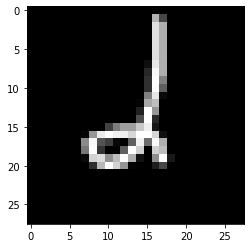

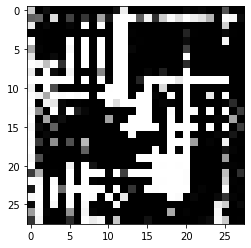

'epoch:  101 ' [discriminator loss:  0.51594585  and acc:  0.5019531 ] [generator loss:  0.8214194  and acc:  0.1484375 ]
'epoch:  102 ' [discriminator loss:  0.51446265  and acc:  0.5058594 ] [generator loss:  0.83084655  and acc:  0.1171875 ]
'epoch:  103 ' [discriminator loss:  0.52022624  and acc:  0.5019531 ] [generator loss:  0.818092  and acc:  0.11328125 ]
'epoch:  104 ' [discriminator loss:  0.51697797  and acc:  0.5 ] [generator loss:  0.8013984  and acc:  0.171875 ]
'epoch:  105 ' [discriminator loss:  0.517138  and acc:  0.5 ] [generator loss:  0.81131154  and acc:  0.1484375 ]
'epoch:  106 ' [discriminator loss:  0.5081544  and acc:  0.5019531 ] [generator loss:  0.80072266  and acc:  0.1328125 ]
'epoch:  107 ' [discriminator loss:  0.51171386  and acc:  0.5019531 ] [generator loss:  0.8031943  and acc:  0.140625 ]
'epoch:  108 ' [discriminator loss:  0.5120586  and acc:  0.5 ] [generator loss:  0.7943655  and acc:  0.171875 ]
'epoch:  109 ' [discriminator loss:  0.5202099

'epoch:  172 ' [discriminator loss:  0.84013754  and acc:  0.5 ] [generator loss:  0.4180153  and acc:  1.0 ]
'epoch:  173 ' [discriminator loss:  0.8390736  and acc:  0.5 ] [generator loss:  0.41659394  and acc:  1.0 ]
'epoch:  174 ' [discriminator loss:  0.8390555  and acc:  0.5 ] [generator loss:  0.4182951  and acc:  1.0 ]
'epoch:  175 ' [discriminator loss:  0.84442526  and acc:  0.5 ] [generator loss:  0.40998918  and acc:  1.0 ]
'epoch:  176 ' [discriminator loss:  0.8473731  and acc:  0.5 ] [generator loss:  0.40420106  and acc:  1.0 ]
'epoch:  177 ' [discriminator loss:  0.8521911  and acc:  0.5 ] [generator loss:  0.41188675  and acc:  1.0 ]
'epoch:  178 ' [discriminator loss:  0.85682815  and acc:  0.5 ] [generator loss:  0.41467243  and acc:  1.0 ]
'epoch:  179 ' [discriminator loss:  0.8590685  and acc:  0.5 ] [generator loss:  0.41222712  and acc:  1.0 ]
'epoch:  180 ' [discriminator loss:  0.94816  and acc:  0.49804688 ] [generator loss:  0.35601705  and acc:  1.0 ]
'epo

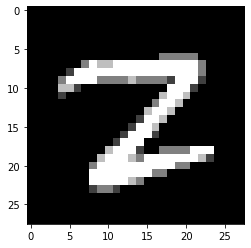

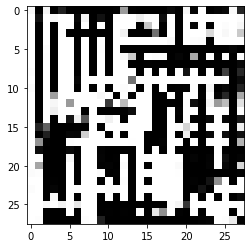

'epoch:  201 ' [discriminator loss:  1.0432998  and acc:  0.5 ] [generator loss:  0.29653418  and acc:  1.0 ]
'epoch:  202 ' [discriminator loss:  1.0251751  and acc:  0.5 ] [generator loss:  0.29264534  and acc:  1.0 ]
'epoch:  203 ' [discriminator loss:  1.0699406  and acc:  0.5 ] [generator loss:  0.29675645  and acc:  1.0 ]
'epoch:  204 ' [discriminator loss:  1.0549233  and acc:  0.5 ] [generator loss:  0.28958005  and acc:  1.0 ]
'epoch:  205 ' [discriminator loss:  1.0578517  and acc:  0.5 ] [generator loss:  0.28968504  and acc:  1.0 ]
'epoch:  206 ' [discriminator loss:  1.0417037  and acc:  0.5 ] [generator loss:  0.28478548  and acc:  1.0 ]
'epoch:  207 ' [discriminator loss:  1.0600982  and acc:  0.5 ] [generator loss:  0.2888784  and acc:  1.0 ]
'epoch:  208 ' [discriminator loss:  1.0509428  and acc:  0.5 ] [generator loss:  0.2873752  and acc:  1.0 ]
'epoch:  209 ' [discriminator loss:  1.0528703  and acc:  0.5 ] [generator loss:  0.28466025  and acc:  1.0 ]
'epoch:  210

'epoch:  276 ' [discriminator loss:  1.3440199  and acc:  0.5 ] [generator loss:  0.17184341  and acc:  1.0 ]
'epoch:  277 ' [discriminator loss:  1.3430889  and acc:  0.5 ] [generator loss:  0.16603906  and acc:  1.0 ]
'epoch:  278 ' [discriminator loss:  1.3306617  and acc:  0.5 ] [generator loss:  0.17297728  and acc:  1.0 ]
'epoch:  279 ' [discriminator loss:  1.3424332  and acc:  0.5 ] [generator loss:  0.16441005  and acc:  1.0 ]
'epoch:  280 ' [discriminator loss:  1.3351059  and acc:  0.5 ] [generator loss:  0.16642264  and acc:  1.0 ]
'epoch:  281 ' [discriminator loss:  1.3632042  and acc:  0.5 ] [generator loss:  0.16871294  and acc:  1.0 ]
'epoch:  282 ' [discriminator loss:  1.3686291  and acc:  0.5 ] [generator loss:  0.16682653  and acc:  1.0 ]
'epoch:  283 ' [discriminator loss:  1.386842  and acc:  0.5 ] [generator loss:  0.16799936  and acc:  1.0 ]
'epoch:  284 ' [discriminator loss:  1.3531566  and acc:  0.5 ] [generator loss:  0.16447407  and acc:  1.0 ]
'epoch:  28

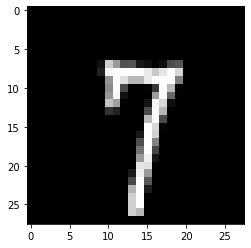

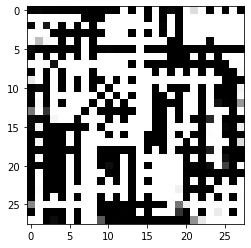

'epoch:  301 ' [discriminator loss:  1.412749  and acc:  0.5 ] [generator loss:  0.1577404  and acc:  1.0 ]
'epoch:  302 ' [discriminator loss:  1.4063766  and acc:  0.5 ] [generator loss:  0.15688327  and acc:  1.0 ]
'epoch:  303 ' [discriminator loss:  1.3745033  and acc:  0.5 ] [generator loss:  0.15320066  and acc:  1.0 ]
'epoch:  304 ' [discriminator loss:  1.3824168  and acc:  0.5 ] [generator loss:  0.15843251  and acc:  1.0 ]
'epoch:  305 ' [discriminator loss:  1.3897337  and acc:  0.5 ] [generator loss:  0.15098877  and acc:  1.0 ]
'epoch:  306 ' [discriminator loss:  1.3773715  and acc:  0.5 ] [generator loss:  0.15659058  and acc:  1.0 ]
'epoch:  307 ' [discriminator loss:  1.369657  and acc:  0.5 ] [generator loss:  0.15346308  and acc:  1.0 ]
'epoch:  308 ' [discriminator loss:  1.4120142  and acc:  0.5 ] [generator loss:  0.15592341  and acc:  1.0 ]
'epoch:  309 ' [discriminator loss:  1.4096575  and acc:  0.5 ] [generator loss:  0.15419573  and acc:  1.0 ]
'epoch:  310 

'epoch:  376 ' [discriminator loss:  1.6531656  and acc:  0.5 ] [generator loss:  0.099154934  and acc:  1.0 ]
'epoch:  377 ' [discriminator loss:  1.6668231  and acc:  0.5 ] [generator loss:  0.10237016  and acc:  1.0 ]
'epoch:  378 ' [discriminator loss:  1.6717098  and acc:  0.5 ] [generator loss:  0.10033642  and acc:  1.0 ]
'epoch:  379 ' [discriminator loss:  1.6851485  and acc:  0.5 ] [generator loss:  0.0983742  and acc:  1.0 ]
'epoch:  380 ' [discriminator loss:  1.6750742  and acc:  0.5 ] [generator loss:  0.09848626  and acc:  1.0 ]
'epoch:  381 ' [discriminator loss:  1.6561772  and acc:  0.5 ] [generator loss:  0.09400717  and acc:  1.0 ]
'epoch:  382 ' [discriminator loss:  1.6701189  and acc:  0.5 ] [generator loss:  0.098992795  and acc:  1.0 ]
'epoch:  383 ' [discriminator loss:  1.6657885  and acc:  0.5 ] [generator loss:  0.09776135  and acc:  1.0 ]
'epoch:  384 ' [discriminator loss:  1.7139938  and acc:  0.49804688 ] [generator loss:  0.08061719  and acc:  1.0 ]
'e

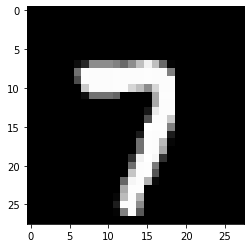

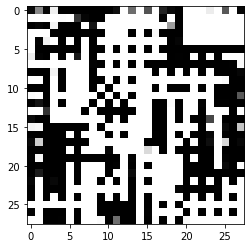

'epoch:  401 ' [discriminator loss:  1.7424282  and acc:  0.5 ] [generator loss:  0.08758422  and acc:  1.0 ]
'epoch:  402 ' [discriminator loss:  1.7625928  and acc:  0.5 ] [generator loss:  0.08411187  and acc:  1.0 ]
'epoch:  403 ' [discriminator loss:  1.7901689  and acc:  0.5 ] [generator loss:  0.084686  and acc:  1.0 ]
'epoch:  404 ' [discriminator loss:  1.7901734  and acc:  0.5 ] [generator loss:  0.08590426  and acc:  1.0 ]
'epoch:  405 ' [discriminator loss:  1.7872196  and acc:  0.5 ] [generator loss:  0.084120825  and acc:  1.0 ]
'epoch:  406 ' [discriminator loss:  1.7821267  and acc:  0.5 ] [generator loss:  0.08118114  and acc:  1.0 ]
'epoch:  407 ' [discriminator loss:  1.7421106  and acc:  0.5 ] [generator loss:  0.084004536  and acc:  1.0 ]
'epoch:  408 ' [discriminator loss:  1.7275815  and acc:  0.5 ] [generator loss:  0.08217771  and acc:  1.0 ]
'epoch:  409 ' [discriminator loss:  1.7593155  and acc:  0.5 ] [generator loss:  0.084299095  and acc:  1.0 ]
'epoch:  

'epoch:  476 ' [discriminator loss:  1.9382763  and acc:  0.5 ] [generator loss:  0.060332675  and acc:  1.0 ]
'epoch:  477 ' [discriminator loss:  1.9333065  and acc:  0.5 ] [generator loss:  0.060872726  and acc:  1.0 ]
'epoch:  478 ' [discriminator loss:  1.9104414  and acc:  0.5 ] [generator loss:  0.062813714  and acc:  1.0 ]
'epoch:  479 ' [discriminator loss:  1.9435055  and acc:  0.5 ] [generator loss:  0.060528934  and acc:  1.0 ]
'epoch:  480 ' [discriminator loss:  1.935365  and acc:  0.5 ] [generator loss:  0.06277249  and acc:  1.0 ]
'epoch:  481 ' [discriminator loss:  1.9785194  and acc:  0.5 ] [generator loss:  0.059896335  and acc:  1.0 ]
'epoch:  482 ' [discriminator loss:  1.9190536  and acc:  0.5 ] [generator loss:  0.06311239  and acc:  1.0 ]
'epoch:  483 ' [discriminator loss:  1.9416211  and acc:  0.5 ] [generator loss:  0.06097012  and acc:  1.0 ]
'epoch:  484 ' [discriminator loss:  1.9365004  and acc:  0.5 ] [generator loss:  0.059344597  and acc:  1.0 ]
'epoc

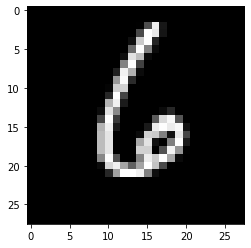

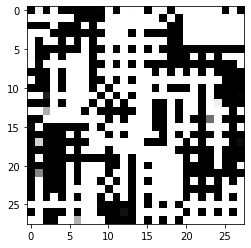

'epoch:  501 ' [discriminator loss:  1.9814548  and acc:  0.5 ] [generator loss:  0.054676086  and acc:  1.0 ]
'epoch:  502 ' [discriminator loss:  1.9865551  and acc:  0.5 ] [generator loss:  0.053390108  and acc:  1.0 ]
'epoch:  503 ' [discriminator loss:  1.9822565  and acc:  0.5 ] [generator loss:  0.054524515  and acc:  1.0 ]
'epoch:  504 ' [discriminator loss:  2.0027893  and acc:  0.5 ] [generator loss:  0.05288507  and acc:  1.0 ]
'epoch:  505 ' [discriminator loss:  1.9956865  and acc:  0.5 ] [generator loss:  0.053436406  and acc:  1.0 ]
'epoch:  506 ' [discriminator loss:  2.001483  and acc:  0.5 ] [generator loss:  0.054927804  and acc:  1.0 ]
'epoch:  507 ' [discriminator loss:  2.0137389  and acc:  0.5 ] [generator loss:  0.053302985  and acc:  1.0 ]
'epoch:  508 ' [discriminator loss:  2.0179238  and acc:  0.5 ] [generator loss:  0.053224824  and acc:  1.0 ]
'epoch:  509 ' [discriminator loss:  2.0295353  and acc:  0.5 ] [generator loss:  0.052201547  and acc:  1.0 ]
'ep

'epoch:  576 ' [discriminator loss:  2.238791  and acc:  0.5 ] [generator loss:  0.03927786  and acc:  1.0 ]
'epoch:  577 ' [discriminator loss:  2.2376835  and acc:  0.5 ] [generator loss:  0.039386004  and acc:  1.0 ]
'epoch:  578 ' [discriminator loss:  2.326501  and acc:  0.5 ] [generator loss:  0.037073035  and acc:  1.0 ]
'epoch:  579 ' [discriminator loss:  2.2478976  and acc:  0.5 ] [generator loss:  0.037823707  and acc:  1.0 ]
'epoch:  580 ' [discriminator loss:  2.2233934  and acc:  0.5 ] [generator loss:  0.03815872  and acc:  1.0 ]
'epoch:  581 ' [discriminator loss:  2.215848  and acc:  0.5 ] [generator loss:  0.03850556  and acc:  1.0 ]
'epoch:  582 ' [discriminator loss:  2.2861872  and acc:  0.5 ] [generator loss:  0.038121074  and acc:  1.0 ]
'epoch:  583 ' [discriminator loss:  2.307798  and acc:  0.5 ] [generator loss:  0.038333476  and acc:  1.0 ]
'epoch:  584 ' [discriminator loss:  2.2501407  and acc:  0.5 ] [generator loss:  0.038315736  and acc:  1.0 ]
'epoch: 

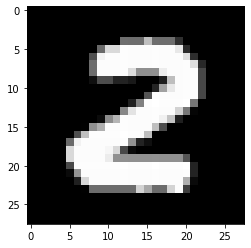

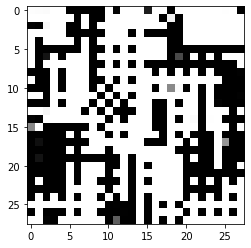

'epoch:  601 ' [discriminator loss:  2.321583  and acc:  0.5 ] [generator loss:  0.03384859  and acc:  1.0 ]
'epoch:  602 ' [discriminator loss:  2.3733668  and acc:  0.5 ] [generator loss:  0.032121383  and acc:  1.0 ]
'epoch:  603 ' [discriminator loss:  2.369989  and acc:  0.5 ] [generator loss:  0.034085732  and acc:  1.0 ]
'epoch:  604 ' [discriminator loss:  2.3697991  and acc:  0.5 ] [generator loss:  0.031986438  and acc:  1.0 ]
'epoch:  605 ' [discriminator loss:  2.3614337  and acc:  0.5 ] [generator loss:  0.03223201  and acc:  1.0 ]
'epoch:  606 ' [discriminator loss:  2.3198798  and acc:  0.5 ] [generator loss:  0.032077983  and acc:  1.0 ]
'epoch:  607 ' [discriminator loss:  2.3539975  and acc:  0.5 ] [generator loss:  0.03224895  and acc:  1.0 ]
'epoch:  608 ' [discriminator loss:  2.3705583  and acc:  0.5 ] [generator loss:  0.033636123  and acc:  1.0 ]
'epoch:  609 ' [discriminator loss:  2.4294257  and acc:  0.5 ] [generator loss:  0.032209795  and acc:  1.0 ]
'epoch

'epoch:  676 ' [discriminator loss:  2.5661206  and acc:  0.5 ] [generator loss:  0.026496876  and acc:  1.0 ]
'epoch:  677 ' [discriminator loss:  2.5083885  and acc:  0.5 ] [generator loss:  0.024785679  and acc:  1.0 ]
'epoch:  678 ' [discriminator loss:  2.5192645  and acc:  0.5 ] [generator loss:  0.026839215  and acc:  1.0 ]
'epoch:  679 ' [discriminator loss:  2.5280483  and acc:  0.5 ] [generator loss:  0.02519935  and acc:  1.0 ]
'epoch:  680 ' [discriminator loss:  2.4894161  and acc:  0.5 ] [generator loss:  0.025482329  and acc:  1.0 ]
'epoch:  681 ' [discriminator loss:  2.5310142  and acc:  0.5 ] [generator loss:  0.026242593  and acc:  1.0 ]
'epoch:  682 ' [discriminator loss:  2.549902  and acc:  0.5 ] [generator loss:  0.025208201  and acc:  1.0 ]
'epoch:  683 ' [discriminator loss:  2.5415432  and acc:  0.5 ] [generator loss:  0.02543483  and acc:  1.0 ]
'epoch:  684 ' [discriminator loss:  2.5479043  and acc:  0.5 ] [generator loss:  0.025530126  and acc:  1.0 ]
'epo

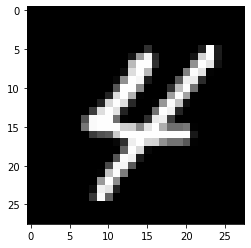

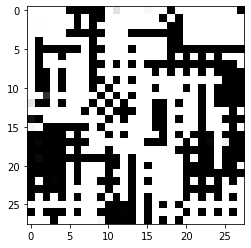

'epoch:  701 ' [discriminator loss:  2.6067123  and acc:  0.5 ] [generator loss:  0.02131953  and acc:  1.0 ]
'epoch:  702 ' [discriminator loss:  2.6147678  and acc:  0.5 ] [generator loss:  0.02279364  and acc:  1.0 ]
'epoch:  703 ' [discriminator loss:  2.6280277  and acc:  0.5 ] [generator loss:  0.022341233  and acc:  1.0 ]
'epoch:  704 ' [discriminator loss:  2.5987961  and acc:  0.5 ] [generator loss:  0.021670435  and acc:  1.0 ]
'epoch:  705 ' [discriminator loss:  2.6063235  and acc:  0.5 ] [generator loss:  0.021002399  and acc:  1.0 ]
'epoch:  706 ' [discriminator loss:  2.5658998  and acc:  0.5 ] [generator loss:  0.022199016  and acc:  1.0 ]
'epoch:  707 ' [discriminator loss:  2.60013  and acc:  0.5 ] [generator loss:  0.022238528  and acc:  1.0 ]
'epoch:  708 ' [discriminator loss:  2.631523  and acc:  0.5 ] [generator loss:  0.021756507  and acc:  1.0 ]
'epoch:  709 ' [discriminator loss:  2.6488004  and acc:  0.5 ] [generator loss:  0.021720832  and acc:  1.0 ]
'epoch

'epoch:  776 ' [discriminator loss:  2.8643045  and acc:  0.5 ] [generator loss:  0.01468947  and acc:  1.0 ]
'epoch:  777 ' [discriminator loss:  2.865749  and acc:  0.5 ] [generator loss:  0.01615524  and acc:  1.0 ]
'epoch:  778 ' [discriminator loss:  2.9120522  and acc:  0.5 ] [generator loss:  0.015115164  and acc:  1.0 ]
'epoch:  779 ' [discriminator loss:  2.890939  and acc:  0.5 ] [generator loss:  0.015412846  and acc:  1.0 ]
'epoch:  780 ' [discriminator loss:  2.9099548  and acc:  0.5 ] [generator loss:  0.014470441  and acc:  1.0 ]
'epoch:  781 ' [discriminator loss:  2.861246  and acc:  0.5 ] [generator loss:  0.015898693  and acc:  1.0 ]
'epoch:  782 ' [discriminator loss:  2.9060059  and acc:  0.5 ] [generator loss:  0.014764953  and acc:  1.0 ]
'epoch:  783 ' [discriminator loss:  2.8840659  and acc:  0.5 ] [generator loss:  0.015323499  and acc:  1.0 ]
'epoch:  784 ' [discriminator loss:  2.9705138  and acc:  0.5 ] [generator loss:  0.01614632  and acc:  1.0 ]
'epoch:

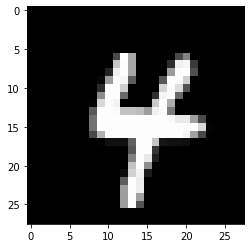

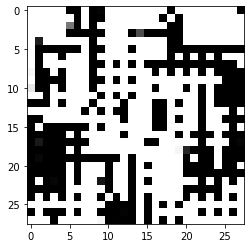

'epoch:  801 ' [discriminator loss:  2.9509492  and acc:  0.5 ] [generator loss:  0.0129056405  and acc:  1.0 ]
'epoch:  802 ' [discriminator loss:  2.947312  and acc:  0.5 ] [generator loss:  0.012723338  and acc:  1.0 ]
'epoch:  803 ' [discriminator loss:  2.9469306  and acc:  0.5 ] [generator loss:  0.014393166  and acc:  1.0 ]
'epoch:  804 ' [discriminator loss:  3.0510473  and acc:  0.5 ] [generator loss:  0.012829959  and acc:  1.0 ]
'epoch:  805 ' [discriminator loss:  3.1179237  and acc:  0.5 ] [generator loss:  0.013485545  and acc:  1.0 ]
'epoch:  806 ' [discriminator loss:  2.9995437  and acc:  0.5 ] [generator loss:  0.012931165  and acc:  1.0 ]
'epoch:  807 ' [discriminator loss:  2.9827175  and acc:  0.5 ] [generator loss:  0.013397315  and acc:  1.0 ]
'epoch:  808 ' [discriminator loss:  3.01304  and acc:  0.5 ] [generator loss:  0.012671929  and acc:  1.0 ]
'epoch:  809 ' [discriminator loss:  2.9784753  and acc:  0.5 ] [generator loss:  0.013336542  and acc:  1.0 ]
'ep

'epoch:  875 ' [discriminator loss:  3.1380112  and acc:  0.5 ] [generator loss:  0.010682432  and acc:  1.0 ]
'epoch:  876 ' [discriminator loss:  3.0883212  and acc:  0.5 ] [generator loss:  0.011359003  and acc:  1.0 ]
'epoch:  877 ' [discriminator loss:  3.147796  and acc:  0.5 ] [generator loss:  0.010091012  and acc:  1.0 ]
'epoch:  878 ' [discriminator loss:  3.1575549  and acc:  0.5 ] [generator loss:  0.010933461  and acc:  1.0 ]
'epoch:  879 ' [discriminator loss:  3.239299  and acc:  0.5 ] [generator loss:  0.01076578  and acc:  1.0 ]
'epoch:  880 ' [discriminator loss:  3.133652  and acc:  0.5 ] [generator loss:  0.0104989335  and acc:  1.0 ]
'epoch:  881 ' [discriminator loss:  3.1332855  and acc:  0.5 ] [generator loss:  0.009997873  and acc:  1.0 ]
'epoch:  882 ' [discriminator loss:  3.1433504  and acc:  0.5 ] [generator loss:  0.011022403  and acc:  1.0 ]
'epoch:  883 ' [discriminator loss:  3.122155  and acc:  0.5 ] [generator loss:  0.010203367  and acc:  1.0 ]
'epoc

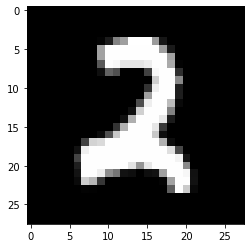

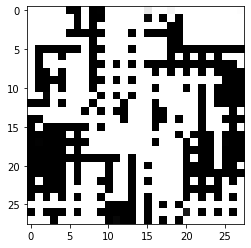

'epoch:  901 ' [discriminator loss:  3.1663547  and acc:  0.5 ] [generator loss:  0.009671658  and acc:  1.0 ]
'epoch:  902 ' [discriminator loss:  3.1081991  and acc:  0.5 ] [generator loss:  0.009981345  and acc:  1.0 ]
'epoch:  903 ' [discriminator loss:  3.1700182  and acc:  0.5 ] [generator loss:  0.009597812  and acc:  1.0 ]
'epoch:  904 ' [discriminator loss:  3.1552634  and acc:  0.5 ] [generator loss:  0.009744677  and acc:  1.0 ]
'epoch:  905 ' [discriminator loss:  3.173548  and acc:  0.5 ] [generator loss:  0.010051361  and acc:  1.0 ]
'epoch:  906 ' [discriminator loss:  3.19973  and acc:  0.5 ] [generator loss:  0.009038235  and acc:  1.0 ]
'epoch:  907 ' [discriminator loss:  3.15658  and acc:  0.5 ] [generator loss:  0.010859293  and acc:  1.0 ]
'epoch:  908 ' [discriminator loss:  3.2833323  and acc:  0.5 ] [generator loss:  0.009055172  and acc:  1.0 ]
'epoch:  909 ' [discriminator loss:  3.1739862  and acc:  0.5 ] [generator loss:  0.009830091  and acc:  1.0 ]
'epoch

'epoch:  976 ' [discriminator loss:  3.3734179  and acc:  0.5 ] [generator loss:  0.007300721  and acc:  1.0 ]
'epoch:  977 ' [discriminator loss:  3.3471413  and acc:  0.5 ] [generator loss:  0.007771924  and acc:  1.0 ]
'epoch:  978 ' [discriminator loss:  3.2816486  and acc:  0.5 ] [generator loss:  0.0073728794  and acc:  1.0 ]
'epoch:  979 ' [discriminator loss:  3.305303  and acc:  0.5 ] [generator loss:  0.0078111547  and acc:  1.0 ]
'epoch:  980 ' [discriminator loss:  3.373508  and acc:  0.5 ] [generator loss:  0.007753888  and acc:  1.0 ]
'epoch:  981 ' [discriminator loss:  3.3898745  and acc:  0.5 ] [generator loss:  0.0073545817  and acc:  1.0 ]
'epoch:  982 ' [discriminator loss:  3.3771238  and acc:  0.5 ] [generator loss:  0.008086235  and acc:  1.0 ]
'epoch:  983 ' [discriminator loss:  3.409591  and acc:  0.5 ] [generator loss:  0.007524439  and acc:  1.0 ]
'epoch:  984 ' [discriminator loss:  3.3814497  and acc:  0.5 ] [generator loss:  0.007863523  and acc:  1.0 ]
'

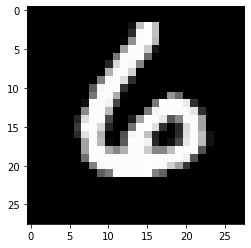

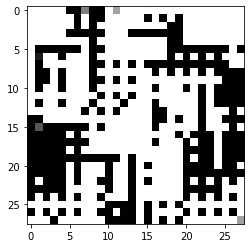

'epoch:  1001 ' [discriminator loss:  3.420717  and acc:  0.5 ] [generator loss:  0.0063252244  and acc:  1.0 ]
'epoch:  1002 ' [discriminator loss:  3.3846426  and acc:  0.5 ] [generator loss:  0.007095269  and acc:  1.0 ]
'epoch:  1003 ' [discriminator loss:  3.4164212  and acc:  0.5 ] [generator loss:  0.0076836776  and acc:  1.0 ]
'epoch:  1004 ' [discriminator loss:  3.5526168  and acc:  0.5 ] [generator loss:  0.0059150266  and acc:  1.0 ]
'epoch:  1005 ' [discriminator loss:  3.5049343  and acc:  0.5 ] [generator loss:  0.0070244987  and acc:  1.0 ]
'epoch:  1006 ' [discriminator loss:  3.4280293  and acc:  0.5 ] [generator loss:  0.006585414  and acc:  1.0 ]
'epoch:  1007 ' [discriminator loss:  3.41332  and acc:  0.5 ] [generator loss:  0.006868962  and acc:  1.0 ]
'epoch:  1008 ' [discriminator loss:  3.4601326  and acc:  0.5 ] [generator loss:  0.0066964068  and acc:  1.0 ]
'epoch:  1009 ' [discriminator loss:  3.4722307  and acc:  0.5 ] [generator loss:  0.006713243  and ac

'epoch:  1074 ' [discriminator loss:  3.4430866  and acc:  0.5 ] [generator loss:  0.00657834  and acc:  1.0 ]
'epoch:  1075 ' [discriminator loss:  3.5370626  and acc:  0.5 ] [generator loss:  0.0055389507  and acc:  1.0 ]
'epoch:  1076 ' [discriminator loss:  3.5198426  and acc:  0.5 ] [generator loss:  0.005772902  and acc:  1.0 ]
'epoch:  1077 ' [discriminator loss:  3.5024397  and acc:  0.5 ] [generator loss:  0.0060995873  and acc:  1.0 ]
'epoch:  1078 ' [discriminator loss:  3.5464313  and acc:  0.5 ] [generator loss:  0.0060305703  and acc:  1.0 ]
'epoch:  1079 ' [discriminator loss:  3.5870085  and acc:  0.5 ] [generator loss:  0.0056410707  and acc:  1.0 ]
'epoch:  1080 ' [discriminator loss:  3.515198  and acc:  0.5 ] [generator loss:  0.0059930966  and acc:  1.0 ]
'epoch:  1081 ' [discriminator loss:  3.5372448  and acc:  0.5 ] [generator loss:  0.0054823407  and acc:  1.0 ]
'epoch:  1082 ' [discriminator loss:  3.4675274  and acc:  0.5 ] [generator loss:  0.00571737  and a

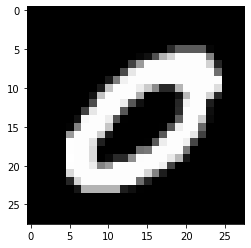

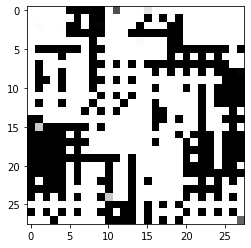

'epoch:  1101 ' [discriminator loss:  3.5675592  and acc:  0.5 ] [generator loss:  0.0053008175  and acc:  1.0 ]
'epoch:  1102 ' [discriminator loss:  3.531777  and acc:  0.5 ] [generator loss:  0.005829945  and acc:  1.0 ]
'epoch:  1103 ' [discriminator loss:  3.6200519  and acc:  0.5 ] [generator loss:  0.004724809  and acc:  1.0 ]
'epoch:  1104 ' [discriminator loss:  3.5466595  and acc:  0.5 ] [generator loss:  0.006271992  and acc:  1.0 ]
'epoch:  1105 ' [discriminator loss:  3.6119123  and acc:  0.5 ] [generator loss:  0.00475481  and acc:  1.0 ]
'epoch:  1106 ' [discriminator loss:  3.5289543  and acc:  0.5 ] [generator loss:  0.005498815  and acc:  1.0 ]
'epoch:  1107 ' [discriminator loss:  3.5219564  and acc:  0.5 ] [generator loss:  0.005611935  and acc:  1.0 ]
'epoch:  1108 ' [discriminator loss:  3.5535476  and acc:  0.5 ] [generator loss:  0.0053578843  and acc:  1.0 ]
'epoch:  1109 ' [discriminator loss:  3.5757928  and acc:  0.5 ] [generator loss:  0.0056557897  and acc

'epoch:  1175 ' [discriminator loss:  3.700499  and acc:  0.5 ] [generator loss:  0.005031395  and acc:  1.0 ]
'epoch:  1176 ' [discriminator loss:  3.7286754  and acc:  0.5 ] [generator loss:  0.0042787227  and acc:  1.0 ]
'epoch:  1177 ' [discriminator loss:  3.648119  and acc:  0.5 ] [generator loss:  0.00449853  and acc:  1.0 ]
'epoch:  1178 ' [discriminator loss:  3.6234996  and acc:  0.5 ] [generator loss:  0.0047226762  and acc:  1.0 ]
'epoch:  1179 ' [discriminator loss:  3.674068  and acc:  0.5 ] [generator loss:  0.0044809096  and acc:  1.0 ]
'epoch:  1180 ' [discriminator loss:  3.6880426  and acc:  0.5 ] [generator loss:  0.00467877  and acc:  1.0 ]
'epoch:  1181 ' [discriminator loss:  3.720712  and acc:  0.5 ] [generator loss:  0.0041049533  and acc:  1.0 ]
'epoch:  1182 ' [discriminator loss:  3.6908572  and acc:  0.5 ] [generator loss:  0.0050517344  and acc:  1.0 ]
'epoch:  1183 ' [discriminator loss:  3.7092113  and acc:  0.5 ] [generator loss:  0.004327419  and acc: 

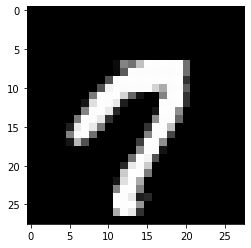

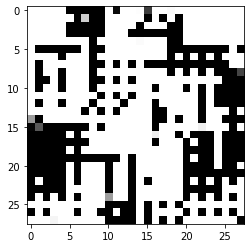

'epoch:  1201 ' [discriminator loss:  3.721059  and acc:  0.5 ] [generator loss:  0.0045205588  and acc:  1.0 ]
'epoch:  1202 ' [discriminator loss:  3.7580447  and acc:  0.5 ] [generator loss:  0.0037486472  and acc:  1.0 ]
'epoch:  1203 ' [discriminator loss:  3.7005072  and acc:  0.5 ] [generator loss:  0.0045881155  and acc:  1.0 ]
'epoch:  1204 ' [discriminator loss:  3.7488267  and acc:  0.5 ] [generator loss:  0.0043653687  and acc:  1.0 ]
'epoch:  1205 ' [discriminator loss:  3.7634664  and acc:  0.5 ] [generator loss:  0.0038732411  and acc:  1.0 ]
'epoch:  1206 ' [discriminator loss:  3.709089  and acc:  0.5 ] [generator loss:  0.0042373748  and acc:  1.0 ]
'epoch:  1207 ' [discriminator loss:  3.7959542  and acc:  0.5 ] [generator loss:  0.0046061054  and acc:  1.0 ]
'epoch:  1208 ' [discriminator loss:  3.7926497  and acc:  0.5 ] [generator loss:  0.0040264563  and acc:  1.0 ]
'epoch:  1209 ' [discriminator loss:  3.7468271  and acc:  0.5 ] [generator loss:  0.0042691072  a

'epoch:  1274 ' [discriminator loss:  3.745491  and acc:  0.5 ] [generator loss:  0.0037725777  and acc:  1.0 ]
'epoch:  1275 ' [discriminator loss:  3.790235  and acc:  0.5 ] [generator loss:  0.003787933  and acc:  1.0 ]
'epoch:  1276 ' [discriminator loss:  3.7362483  and acc:  0.5 ] [generator loss:  0.0040407646  and acc:  1.0 ]
'epoch:  1277 ' [discriminator loss:  3.8246665  and acc:  0.5 ] [generator loss:  0.003574605  and acc:  1.0 ]
'epoch:  1278 ' [discriminator loss:  3.7909994  and acc:  0.5 ] [generator loss:  0.0038392176  and acc:  1.0 ]
'epoch:  1279 ' [discriminator loss:  3.8412633  and acc:  0.5 ] [generator loss:  0.0037294813  and acc:  1.0 ]
'epoch:  1280 ' [discriminator loss:  3.8191843  and acc:  0.5 ] [generator loss:  0.003723133  and acc:  1.0 ]
'epoch:  1281 ' [discriminator loss:  3.8990026  and acc:  0.5 ] [generator loss:  0.004524602  and acc:  1.0 ]
'epoch:  1282 ' [discriminator loss:  3.8570638  and acc:  0.5 ] [generator loss:  0.003195086  and ac

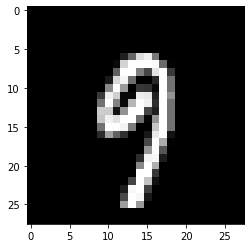

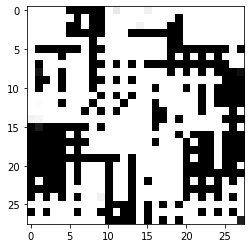

'epoch:  1301 ' [discriminator loss:  3.7923658  and acc:  0.5 ] [generator loss:  0.0037082038  and acc:  1.0 ]
'epoch:  1302 ' [discriminator loss:  3.7910333  and acc:  0.5 ] [generator loss:  0.0039518285  and acc:  1.0 ]
'epoch:  1303 ' [discriminator loss:  3.8544426  and acc:  0.5 ] [generator loss:  0.0038482163  and acc:  1.0 ]
'epoch:  1304 ' [discriminator loss:  3.851629  and acc:  0.5 ] [generator loss:  0.0035616946  and acc:  1.0 ]
'epoch:  1305 ' [discriminator loss:  3.7930028  and acc:  0.5 ] [generator loss:  0.0038878727  and acc:  1.0 ]
'epoch:  1306 ' [discriminator loss:  3.8382232  and acc:  0.5 ] [generator loss:  0.003559962  and acc:  1.0 ]
'epoch:  1307 ' [discriminator loss:  3.8371358  and acc:  0.5 ] [generator loss:  0.0038756002  and acc:  1.0 ]
'epoch:  1308 ' [discriminator loss:  3.802354  and acc:  0.5 ] [generator loss:  0.0037429836  and acc:  1.0 ]
'epoch:  1309 ' [discriminator loss:  3.822042  and acc:  0.5 ] [generator loss:  0.0039299056  and

'epoch:  1374 ' [discriminator loss:  4.0168123  and acc:  0.5 ] [generator loss:  0.0030375167  and acc:  1.0 ]
'epoch:  1375 ' [discriminator loss:  4.0614877  and acc:  0.5 ] [generator loss:  0.002732354  and acc:  1.0 ]
'epoch:  1376 ' [discriminator loss:  4.0226836  and acc:  0.5 ] [generator loss:  0.002849551  and acc:  1.0 ]
'epoch:  1377 ' [discriminator loss:  4.0466223  and acc:  0.5 ] [generator loss:  0.0027907006  and acc:  1.0 ]
'epoch:  1378 ' [discriminator loss:  4.009663  and acc:  0.5 ] [generator loss:  0.0029818325  and acc:  1.0 ]
'epoch:  1379 ' [discriminator loss:  4.113142  and acc:  0.5 ] [generator loss:  0.0027536391  and acc:  1.0 ]
'epoch:  1380 ' [discriminator loss:  4.0594754  and acc:  0.5 ] [generator loss:  0.0027584853  and acc:  1.0 ]
'epoch:  1381 ' [discriminator loss:  4.119885  and acc:  0.5 ] [generator loss:  0.0028112445  and acc:  1.0 ]
'epoch:  1382 ' [discriminator loss:  4.0338964  and acc:  0.5 ] [generator loss:  0.0027422952  and 

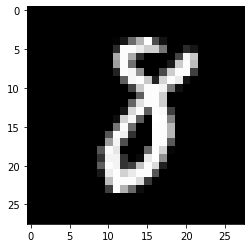

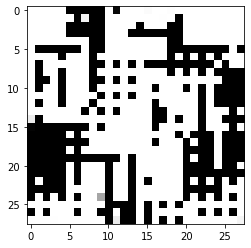

'epoch:  1401 ' [discriminator loss:  4.094607  and acc:  0.5 ] [generator loss:  0.0025970624  and acc:  1.0 ]
'epoch:  1402 ' [discriminator loss:  4.017994  and acc:  0.5 ] [generator loss:  0.0032153334  and acc:  1.0 ]
'epoch:  1403 ' [discriminator loss:  4.212291  and acc:  0.5 ] [generator loss:  0.0024422843  and acc:  1.0 ]
'epoch:  1404 ' [discriminator loss:  4.0684457  and acc:  0.5 ] [generator loss:  0.0027950928  and acc:  1.0 ]
'epoch:  1405 ' [discriminator loss:  3.9692702  and acc:  0.5 ] [generator loss:  0.0024758547  and acc:  1.0 ]
'epoch:  1406 ' [discriminator loss:  3.9493854  and acc:  0.5 ] [generator loss:  0.0030305665  and acc:  1.0 ]
'epoch:  1407 ' [discriminator loss:  4.0336924  and acc:  0.5 ] [generator loss:  0.0025702566  and acc:  1.0 ]
'epoch:  1408 ' [discriminator loss:  4.170149  and acc:  0.49804688 ] [generator loss:  0.0019730218  and acc:  1.0 ]
'epoch:  1409 ' [discriminator loss:  4.103237  and acc:  0.5 ] [generator loss:  0.002811472

'epoch:  1474 ' [discriminator loss:  4.1830053  and acc:  0.5 ] [generator loss:  0.0023798817  and acc:  1.0 ]
'epoch:  1475 ' [discriminator loss:  4.2048025  and acc:  0.5 ] [generator loss:  0.002187453  and acc:  1.0 ]
'epoch:  1476 ' [discriminator loss:  4.2831354  and acc:  0.5 ] [generator loss:  0.0021691443  and acc:  1.0 ]
'epoch:  1477 ' [discriminator loss:  4.3070855  and acc:  0.5 ] [generator loss:  0.002341615  and acc:  1.0 ]
'epoch:  1478 ' [discriminator loss:  4.279867  and acc:  0.5 ] [generator loss:  0.0020282355  and acc:  1.0 ]
'epoch:  1479 ' [discriminator loss:  4.2207375  and acc:  0.5 ] [generator loss:  0.0022437638  and acc:  1.0 ]
'epoch:  1480 ' [discriminator loss:  4.2653847  and acc:  0.5 ] [generator loss:  0.002182779  and acc:  1.0 ]
'epoch:  1481 ' [discriminator loss:  4.317425  and acc:  0.5 ] [generator loss:  0.0023901411  and acc:  1.0 ]
'epoch:  1482 ' [discriminator loss:  4.3593044  and acc:  0.5 ] [generator loss:  0.0020504827  and 

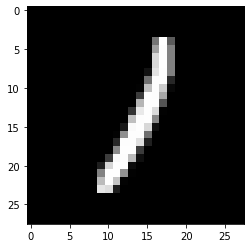

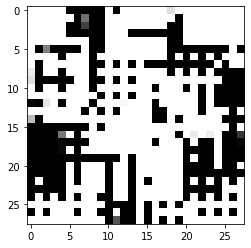

'epoch:  1501 ' [discriminator loss:  4.222181  and acc:  0.5 ] [generator loss:  0.0020937864  and acc:  1.0 ]
'epoch:  1502 ' [discriminator loss:  4.224719  and acc:  0.5 ] [generator loss:  0.0022869376  and acc:  1.0 ]
'epoch:  1503 ' [discriminator loss:  4.3009815  and acc:  0.5 ] [generator loss:  0.0021812343  and acc:  1.0 ]
'epoch:  1504 ' [discriminator loss:  4.2973347  and acc:  0.5 ] [generator loss:  0.0021516667  and acc:  1.0 ]
'epoch:  1505 ' [discriminator loss:  4.177413  and acc:  0.5 ] [generator loss:  0.0023312955  and acc:  1.0 ]
'epoch:  1506 ' [discriminator loss:  4.3069863  and acc:  0.5 ] [generator loss:  0.0022434383  and acc:  1.0 ]
'epoch:  1507 ' [discriminator loss:  4.3219633  and acc:  0.5 ] [generator loss:  0.0018054689  and acc:  1.0 ]
'epoch:  1508 ' [discriminator loss:  4.1241035  and acc:  0.5 ] [generator loss:  0.0025840295  and acc:  1.0 ]
'epoch:  1509 ' [discriminator loss:  4.316268  and acc:  0.5 ] [generator loss:  0.0019268112  and

'epoch:  1574 ' [discriminator loss:  4.3245945  and acc:  0.5 ] [generator loss:  0.0018262304  and acc:  1.0 ]
'epoch:  1575 ' [discriminator loss:  4.3302183  and acc:  0.5 ] [generator loss:  0.0017327382  and acc:  1.0 ]
'epoch:  1576 ' [discriminator loss:  4.3496504  and acc:  0.5 ] [generator loss:  0.0020790615  and acc:  1.0 ]
'epoch:  1577 ' [discriminator loss:  4.4249115  and acc:  0.5 ] [generator loss:  0.0016836454  and acc:  1.0 ]
'epoch:  1578 ' [discriminator loss:  4.3240023  and acc:  0.5 ] [generator loss:  0.0019557346  and acc:  1.0 ]
'epoch:  1579 ' [discriminator loss:  4.446746  and acc:  0.5 ] [generator loss:  0.0015400865  and acc:  1.0 ]
'epoch:  1580 ' [discriminator loss:  4.2550983  and acc:  0.5 ] [generator loss:  0.0020184559  and acc:  1.0 ]
'epoch:  1581 ' [discriminator loss:  4.3613415  and acc:  0.5 ] [generator loss:  0.0017349286  and acc:  1.0 ]
'epoch:  1582 ' [discriminator loss:  4.3942766  and acc:  0.5 ] [generator loss:  0.0020806547  

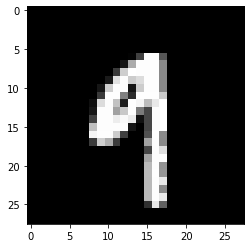

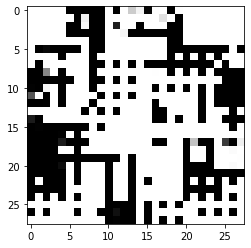

'epoch:  1601 ' [discriminator loss:  4.599407  and acc:  0.5 ] [generator loss:  0.0010946179  and acc:  1.0 ]
'epoch:  1602 ' [discriminator loss:  4.3462934  and acc:  0.5 ] [generator loss:  0.0024226909  and acc:  1.0 ]
'epoch:  1603 ' [discriminator loss:  4.7223277  and acc:  0.5 ] [generator loss:  0.0011130673  and acc:  1.0 ]
'epoch:  1604 ' [discriminator loss:  4.316497  and acc:  0.5 ] [generator loss:  0.00203114  and acc:  1.0 ]
'epoch:  1605 ' [discriminator loss:  4.5439315  and acc:  0.5 ] [generator loss:  0.0013998395  and acc:  1.0 ]
'epoch:  1606 ' [discriminator loss:  4.360379  and acc:  0.5 ] [generator loss:  0.0018959511  and acc:  1.0 ]
'epoch:  1607 ' [discriminator loss:  4.4718885  and acc:  0.5 ] [generator loss:  0.0014708395  and acc:  1.0 ]
'epoch:  1608 ' [discriminator loss:  4.401595  and acc:  0.5 ] [generator loss:  0.001652417  and acc:  1.0 ]
'epoch:  1609 ' [discriminator loss:  4.4411073  and acc:  0.5 ] [generator loss:  0.0018184343  and ac

'epoch:  1674 ' [discriminator loss:  4.616471  and acc:  0.5 ] [generator loss:  0.0015006028  and acc:  1.0 ]
'epoch:  1675 ' [discriminator loss:  4.6074653  and acc:  0.5 ] [generator loss:  0.0014013904  and acc:  1.0 ]
'epoch:  1676 ' [discriminator loss:  4.572749  and acc:  0.5 ] [generator loss:  0.001774004  and acc:  1.0 ]
'epoch:  1677 ' [discriminator loss:  4.7391777  and acc:  0.5 ] [generator loss:  0.0011494947  and acc:  1.0 ]
'epoch:  1678 ' [discriminator loss:  4.5292068  and acc:  0.5 ] [generator loss:  0.001850677  and acc:  1.0 ]
'epoch:  1679 ' [discriminator loss:  4.559519  and acc:  0.5 ] [generator loss:  0.0012908377  and acc:  1.0 ]
'epoch:  1680 ' [discriminator loss:  4.409437  and acc:  0.5 ] [generator loss:  0.0015818407  and acc:  1.0 ]
'epoch:  1681 ' [discriminator loss:  4.487262  and acc:  0.5 ] [generator loss:  0.0014638349  and acc:  1.0 ]
'epoch:  1682 ' [discriminator loss:  4.4485874  and acc:  0.5 ] [generator loss:  0.0014966349  and ac

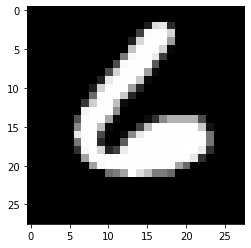

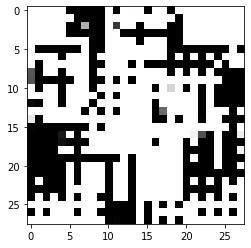

'epoch:  1701 ' [discriminator loss:  4.569254  and acc:  0.49804688 ] [generator loss:  0.00090517744  and acc:  1.0 ]
'epoch:  1702 ' [discriminator loss:  4.490267  and acc:  0.5 ] [generator loss:  0.0019365216  and acc:  1.0 ]
'epoch:  1703 ' [discriminator loss:  4.740586  and acc:  0.5 ] [generator loss:  0.0010425237  and acc:  1.0 ]
'epoch:  1704 ' [discriminator loss:  4.4218636  and acc:  0.5 ] [generator loss:  0.0019215192  and acc:  1.0 ]
'epoch:  1705 ' [discriminator loss:  4.712156  and acc:  0.5 ] [generator loss:  0.0010370894  and acc:  1.0 ]
'epoch:  1706 ' [discriminator loss:  4.354142  and acc:  0.5 ] [generator loss:  0.0017078303  and acc:  1.0 ]
'epoch:  1707 ' [discriminator loss:  4.5902348  and acc:  0.5 ] [generator loss:  0.001332759  and acc:  1.0 ]
'epoch:  1708 ' [discriminator loss:  4.5338144  and acc:  0.5 ] [generator loss:  0.0015063318  and acc:  1.0 ]
'epoch:  1709 ' [discriminator loss:  4.5894866  and acc:  0.5 ] [generator loss:  0.001374042

'epoch:  1779 ' [discriminator loss:  4.4465094  and acc:  0.5 ] [generator loss:  0.001525814  and acc:  1.0 ]
'epoch:  1780 ' [discriminator loss:  4.6624117  and acc:  0.5 ] [generator loss:  0.0011273171  and acc:  1.0 ]
'epoch:  1781 ' [discriminator loss:  4.4205112  and acc:  0.5 ] [generator loss:  0.0015784344  and acc:  1.0 ]
'epoch:  1782 ' [discriminator loss:  4.658214  and acc:  0.5 ] [generator loss:  0.0012147933  and acc:  1.0 ]
'epoch:  1783 ' [discriminator loss:  4.5393615  and acc:  0.5 ] [generator loss:  0.0015434711  and acc:  1.0 ]
'epoch:  1784 ' [discriminator loss:  4.7045813  and acc:  0.5 ] [generator loss:  0.0011052295  and acc:  1.0 ]
'epoch:  1785 ' [discriminator loss:  4.51543  and acc:  0.5 ] [generator loss:  0.0014762178  and acc:  1.0 ]
'epoch:  1786 ' [discriminator loss:  4.6315994  and acc:  0.5 ] [generator loss:  0.0012320406  and acc:  1.0 ]
'epoch:  1787 ' [discriminator loss:  4.6117144  and acc:  0.5 ] [generator loss:  0.0013185651  and

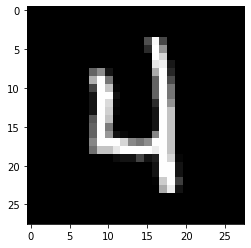

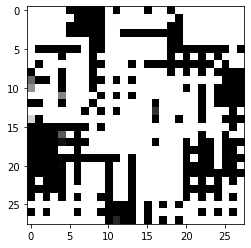

'epoch:  1801 ' [discriminator loss:  4.5569906  and acc:  0.5 ] [generator loss:  0.0013294942  and acc:  1.0 ]
'epoch:  1802 ' [discriminator loss:  4.5989795  and acc:  0.5 ] [generator loss:  0.0014123362  and acc:  1.0 ]
'epoch:  1803 ' [discriminator loss:  4.796804  and acc:  0.5 ] [generator loss:  0.0010638837  and acc:  1.0 ]
'epoch:  1804 ' [discriminator loss:  4.60757  and acc:  0.5 ] [generator loss:  0.0013064598  and acc:  1.0 ]
'epoch:  1805 ' [discriminator loss:  4.6972356  and acc:  0.5 ] [generator loss:  0.0014210589  and acc:  1.0 ]
'epoch:  1806 ' [discriminator loss:  4.7724314  and acc:  0.5 ] [generator loss:  0.0011189829  and acc:  1.0 ]
'epoch:  1807 ' [discriminator loss:  4.6111107  and acc:  0.5 ] [generator loss:  0.0013678032  and acc:  1.0 ]
'epoch:  1808 ' [discriminator loss:  4.6862764  and acc:  0.5 ] [generator loss:  0.0011325225  and acc:  1.0 ]
'epoch:  1809 ' [discriminator loss:  4.633932  and acc:  0.5 ] [generator loss:  0.0014501575  and

'epoch:  1874 ' [discriminator loss:  4.7494917  and acc:  0.5 ] [generator loss:  0.0014729553  and acc:  1.0 ]
'epoch:  1875 ' [discriminator loss:  4.742993  and acc:  0.5 ] [generator loss:  0.0011915358  and acc:  1.0 ]
'epoch:  1876 ' [discriminator loss:  4.62439  and acc:  0.5 ] [generator loss:  0.0012607572  and acc:  1.0 ]
'epoch:  1877 ' [discriminator loss:  4.5965867  and acc:  0.49804688 ] [generator loss:  0.0008985385  and acc:  1.0 ]
'epoch:  1878 ' [discriminator loss:  4.5367584  and acc:  0.5 ] [generator loss:  0.0015396504  and acc:  1.0 ]
'epoch:  1879 ' [discriminator loss:  4.759647  and acc:  0.5 ] [generator loss:  0.0010649291  and acc:  1.0 ]
'epoch:  1880 ' [discriminator loss:  4.559107  and acc:  0.5 ] [generator loss:  0.0014309963  and acc:  1.0 ]
'epoch:  1881 ' [discriminator loss:  4.729249  and acc:  0.5 ] [generator loss:  0.0010857815  and acc:  1.0 ]
'epoch:  1882 ' [discriminator loss:  4.5673227  and acc:  0.5 ] [generator loss:  0.0012470046

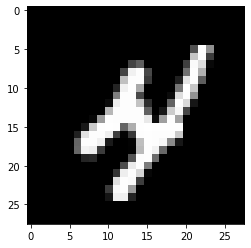

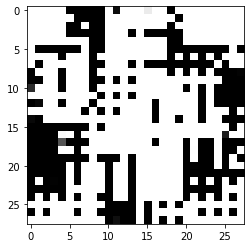

'epoch:  1901 ' [discriminator loss:  4.7155533  and acc:  0.5 ] [generator loss:  0.0016165248  and acc:  1.0 ]
'epoch:  1902 ' [discriminator loss:  4.769438  and acc:  0.5 ] [generator loss:  0.0009571931  and acc:  1.0 ]
'epoch:  1903 ' [discriminator loss:  4.558777  and acc:  0.5 ] [generator loss:  0.0013546017  and acc:  1.0 ]
'epoch:  1904 ' [discriminator loss:  4.6596656  and acc:  0.5 ] [generator loss:  0.0012543399  and acc:  1.0 ]
'epoch:  1905 ' [discriminator loss:  4.71898  and acc:  0.5 ] [generator loss:  0.0012344171  and acc:  1.0 ]
'epoch:  1906 ' [discriminator loss:  4.6684713  and acc:  0.5 ] [generator loss:  0.0011564234  and acc:  1.0 ]
'epoch:  1907 ' [discriminator loss:  4.6874027  and acc:  0.5 ] [generator loss:  0.0015050443  and acc:  1.0 ]
'epoch:  1908 ' [discriminator loss:  4.768548  and acc:  0.5 ] [generator loss:  0.001424512  and acc:  1.0 ]
'epoch:  1909 ' [discriminator loss:  4.84497  and acc:  0.5 ] [generator loss:  0.0011122992  and acc

'epoch:  1974 ' [discriminator loss:  4.9318686  and acc:  0.5 ] [generator loss:  0.0011356105  and acc:  1.0 ]
'epoch:  1975 ' [discriminator loss:  5.0529456  and acc:  0.5 ] [generator loss:  0.00090240315  and acc:  1.0 ]
'epoch:  1976 ' [discriminator loss:  4.914265  and acc:  0.5 ] [generator loss:  0.0011766658  and acc:  1.0 ]
'epoch:  1977 ' [discriminator loss:  5.0862646  and acc:  0.5 ] [generator loss:  0.00084842683  and acc:  1.0 ]
'epoch:  1978 ' [discriminator loss:  4.861865  and acc:  0.5 ] [generator loss:  0.0012100007  and acc:  1.0 ]
'epoch:  1979 ' [discriminator loss:  5.077188  and acc:  0.5 ] [generator loss:  0.00089349324  and acc:  1.0 ]
'epoch:  1980 ' [discriminator loss:  4.8539734  and acc:  0.5 ] [generator loss:  0.0010632098  and acc:  1.0 ]
'epoch:  1981 ' [discriminator loss:  4.959367  and acc:  0.5 ] [generator loss:  0.0010151545  and acc:  1.0 ]
'epoch:  1982 ' [discriminator loss:  4.9102564  and acc:  0.5 ] [generator loss:  0.0011055467  

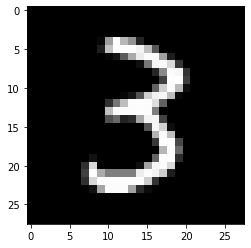

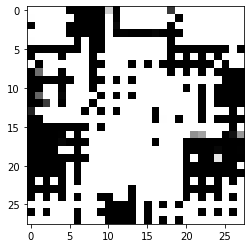

'epoch:  2001 ' [discriminator loss:  5.077382  and acc:  0.5 ] [generator loss:  0.0008172329  and acc:  1.0 ]
'epoch:  2002 ' [discriminator loss:  4.793929  and acc:  0.49804688 ] [generator loss:  0.00092950155  and acc:  1.0 ]
'epoch:  2003 ' [discriminator loss:  5.054097  and acc:  0.5 ] [generator loss:  0.00090301497  and acc:  1.0 ]
'epoch:  2004 ' [discriminator loss:  4.853141  and acc:  0.5 ] [generator loss:  0.001113514  and acc:  1.0 ]
'epoch:  2005 ' [discriminator loss:  5.0252833  and acc:  0.5 ] [generator loss:  0.000791375  and acc:  1.0 ]
'epoch:  2006 ' [discriminator loss:  4.7447724  and acc:  0.5 ] [generator loss:  0.0012032331  and acc:  1.0 ]
'epoch:  2007 ' [discriminator loss:  4.9883103  and acc:  0.5 ] [generator loss:  0.00073371024  and acc:  1.0 ]
'epoch:  2008 ' [discriminator loss:  4.675384  and acc:  0.5 ] [generator loss:  0.0010806662  and acc:  1.0 ]
'epoch:  2009 ' [discriminator loss:  4.8625536  and acc:  0.5 ] [generator loss:  0.00089073

'epoch:  2074 ' [discriminator loss:  4.8545003  and acc:  0.5 ] [generator loss:  0.0010402333  and acc:  1.0 ]
'epoch:  2075 ' [discriminator loss:  4.79652  and acc:  0.5 ] [generator loss:  0.0012144762  and acc:  1.0 ]
'epoch:  2076 ' [discriminator loss:  4.869599  and acc:  0.5 ] [generator loss:  0.000925733  and acc:  1.0 ]
'epoch:  2077 ' [discriminator loss:  4.725134  and acc:  0.5 ] [generator loss:  0.0011945534  and acc:  1.0 ]
'epoch:  2078 ' [discriminator loss:  4.8520756  and acc:  0.5 ] [generator loss:  0.0009757608  and acc:  1.0 ]
'epoch:  2079 ' [discriminator loss:  4.7957067  and acc:  0.5 ] [generator loss:  0.0013084364  and acc:  1.0 ]
'epoch:  2080 ' [discriminator loss:  5.078495  and acc:  0.5 ] [generator loss:  0.0009117081  and acc:  1.0 ]
'epoch:  2081 ' [discriminator loss:  5.0222516  and acc:  0.5 ] [generator loss:  0.0012892018  and acc:  1.0 ]
'epoch:  2082 ' [discriminator loss:  4.887117  and acc:  0.5 ] [generator loss:  0.0010377471  and ac

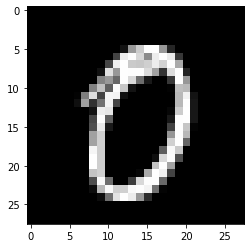

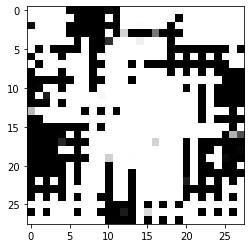

'epoch:  2101 ' [discriminator loss:  4.830741  and acc:  0.5 ] [generator loss:  0.0011033281  and acc:  1.0 ]
'epoch:  2102 ' [discriminator loss:  4.809108  and acc:  0.5 ] [generator loss:  0.001151125  and acc:  1.0 ]
'epoch:  2103 ' [discriminator loss:  4.862148  and acc:  0.5 ] [generator loss:  0.0010649557  and acc:  1.0 ]
'epoch:  2104 ' [discriminator loss:  4.8478956  and acc:  0.5 ] [generator loss:  0.0010711764  and acc:  1.0 ]
'epoch:  2105 ' [discriminator loss:  4.7358217  and acc:  0.5 ] [generator loss:  0.0013000806  and acc:  1.0 ]
'epoch:  2106 ' [discriminator loss:  5.013327  and acc:  0.5 ] [generator loss:  0.0010857279  and acc:  1.0 ]
'epoch:  2107 ' [discriminator loss:  4.8735447  and acc:  0.5 ] [generator loss:  0.0010240765  and acc:  1.0 ]
'epoch:  2108 ' [discriminator loss:  4.7755985  and acc:  0.5 ] [generator loss:  0.0010972926  and acc:  1.0 ]
'epoch:  2109 ' [discriminator loss:  4.7514896  and acc:  0.5 ] [generator loss:  0.001188751  and a

'epoch:  2174 ' [discriminator loss:  4.9423203  and acc:  0.5 ] [generator loss:  0.0009843195  and acc:  1.0 ]
'epoch:  2175 ' [discriminator loss:  4.9474115  and acc:  0.5 ] [generator loss:  0.00085107936  and acc:  1.0 ]
'epoch:  2176 ' [discriminator loss:  4.86055  and acc:  0.5 ] [generator loss:  0.0010575353  and acc:  1.0 ]
'epoch:  2177 ' [discriminator loss:  5.116976  and acc:  0.5 ] [generator loss:  0.00080305757  and acc:  1.0 ]
'epoch:  2178 ' [discriminator loss:  4.9002066  and acc:  0.5 ] [generator loss:  0.0010298572  and acc:  1.0 ]
'epoch:  2179 ' [discriminator loss:  5.083964  and acc:  0.5 ] [generator loss:  0.0008400732  and acc:  1.0 ]
'epoch:  2180 ' [discriminator loss:  4.9286375  and acc:  0.5 ] [generator loss:  0.00089856744  and acc:  1.0 ]
'epoch:  2181 ' [discriminator loss:  4.8544207  and acc:  0.5 ] [generator loss:  0.0010640325  and acc:  1.0 ]
'epoch:  2182 ' [discriminator loss:  5.0006056  and acc:  0.5 ] [generator loss:  0.00094557635 

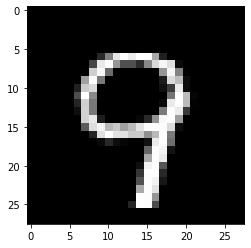

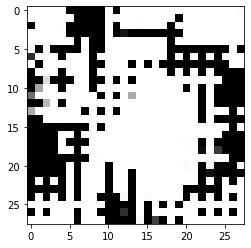

'epoch:  2201 ' [discriminator loss:  5.3382063  and acc:  0.5 ] [generator loss:  0.0005387844  and acc:  1.0 ]
'epoch:  2202 ' [discriminator loss:  4.831995  and acc:  0.5 ] [generator loss:  0.0013819451  and acc:  1.0 ]
'epoch:  2203 ' [discriminator loss:  5.2661014  and acc:  0.5 ] [generator loss:  0.0005316806  and acc:  1.0 ]
'epoch:  2204 ' [discriminator loss:  4.7202272  and acc:  0.5 ] [generator loss:  0.0013575074  and acc:  1.0 ]
'epoch:  2205 ' [discriminator loss:  5.238858  and acc:  0.5 ] [generator loss:  0.00054673944  and acc:  1.0 ]
'epoch:  2206 ' [discriminator loss:  4.761614  and acc:  0.5 ] [generator loss:  0.0013587273  and acc:  1.0 ]
'epoch:  2207 ' [discriminator loss:  5.314311  and acc:  0.5 ] [generator loss:  0.00054083834  and acc:  1.0 ]
'epoch:  2208 ' [discriminator loss:  4.807271  and acc:  0.5 ] [generator loss:  0.0015065513  and acc:  1.0 ]
'epoch:  2209 ' [discriminator loss:  5.2865868  and acc:  0.5 ] [generator loss:  0.00059202407  a

'epoch:  2274 ' [discriminator loss:  4.945282  and acc:  0.5 ] [generator loss:  0.0010576224  and acc:  1.0 ]
'epoch:  2275 ' [discriminator loss:  5.010049  and acc:  0.5 ] [generator loss:  0.0011238141  and acc:  1.0 ]
'epoch:  2276 ' [discriminator loss:  4.9564075  and acc:  0.5 ] [generator loss:  0.0009279026  and acc:  1.0 ]
'epoch:  2277 ' [discriminator loss:  4.8843007  and acc:  0.5 ] [generator loss:  0.0010605566  and acc:  1.0 ]
'epoch:  2278 ' [discriminator loss:  4.849859  and acc:  0.5 ] [generator loss:  0.0010484374  and acc:  1.0 ]
'epoch:  2279 ' [discriminator loss:  4.942415  and acc:  0.5 ] [generator loss:  0.0010879652  and acc:  1.0 ]
'epoch:  2280 ' [discriminator loss:  4.9084845  and acc:  0.5 ] [generator loss:  0.0012512023  and acc:  1.0 ]
'epoch:  2281 ' [discriminator loss:  5.0972633  and acc:  0.5 ] [generator loss:  0.00081120303  and acc:  1.0 ]
'epoch:  2282 ' [discriminator loss:  4.7163754  and acc:  0.5 ] [generator loss:  0.0012918073  an

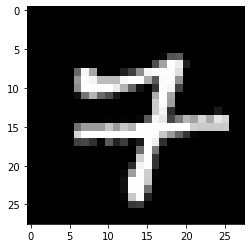

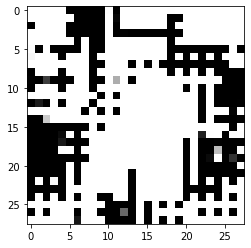

'epoch:  2301 ' [discriminator loss:  4.9046926  and acc:  0.5 ] [generator loss:  0.0010261124  and acc:  1.0 ]
'epoch:  2302 ' [discriminator loss:  5.0074487  and acc:  0.5 ] [generator loss:  0.0007826864  and acc:  1.0 ]
'epoch:  2303 ' [discriminator loss:  4.868436  and acc:  0.5 ] [generator loss:  0.0010869208  and acc:  1.0 ]
'epoch:  2304 ' [discriminator loss:  5.1613493  and acc:  0.5 ] [generator loss:  0.0008460304  and acc:  1.0 ]
'epoch:  2305 ' [discriminator loss:  4.9445734  and acc:  0.5 ] [generator loss:  0.0010243077  and acc:  1.0 ]
'epoch:  2306 ' [discriminator loss:  5.047386  and acc:  0.5 ] [generator loss:  0.000795786  and acc:  1.0 ]
'epoch:  2307 ' [discriminator loss:  4.8868914  and acc:  0.5 ] [generator loss:  0.001186918  and acc:  1.0 ]
'epoch:  2308 ' [discriminator loss:  5.2374306  and acc:  0.5 ] [generator loss:  0.00071841944  and acc:  1.0 ]
'epoch:  2309 ' [discriminator loss:  4.818449  and acc:  0.5 ] [generator loss:  0.0011215035  and

'epoch:  2374 ' [discriminator loss:  5.153588  and acc:  0.5 ] [generator loss:  0.0008674355  and acc:  1.0 ]
'epoch:  2375 ' [discriminator loss:  5.003936  and acc:  0.5 ] [generator loss:  0.0010064743  and acc:  1.0 ]
'epoch:  2376 ' [discriminator loss:  5.0041146  and acc:  0.5 ] [generator loss:  0.0010622726  and acc:  1.0 ]
'epoch:  2377 ' [discriminator loss:  5.1008277  and acc:  0.5 ] [generator loss:  0.0008379532  and acc:  1.0 ]
'epoch:  2378 ' [discriminator loss:  4.9214487  and acc:  0.5 ] [generator loss:  0.0011557505  and acc:  1.0 ]
'epoch:  2379 ' [discriminator loss:  5.1810474  and acc:  0.5 ] [generator loss:  0.00082656834  and acc:  1.0 ]
'epoch:  2380 ' [discriminator loss:  5.1006384  and acc:  0.5 ] [generator loss:  0.0013762234  and acc:  1.0 ]
'epoch:  2381 ' [discriminator loss:  5.1918597  and acc:  0.5 ] [generator loss:  0.00070229836  and acc:  1.0 ]
'epoch:  2382 ' [discriminator loss:  4.9204426  and acc:  0.5 ] [generator loss:  0.0012695133 

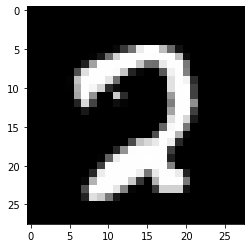

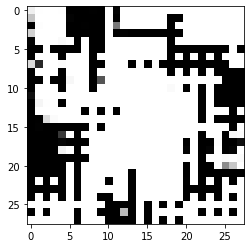

'epoch:  2401 ' [discriminator loss:  5.0412664  and acc:  0.5 ] [generator loss:  0.0008579496  and acc:  1.0 ]
'epoch:  2402 ' [discriminator loss:  4.8697205  and acc:  0.5 ] [generator loss:  0.0011655248  and acc:  1.0 ]
'epoch:  2403 ' [discriminator loss:  4.978611  and acc:  0.5 ] [generator loss:  0.000901566  and acc:  1.0 ]
'epoch:  2404 ' [discriminator loss:  4.9258723  and acc:  0.5 ] [generator loss:  0.0011218534  and acc:  1.0 ]
'epoch:  2405 ' [discriminator loss:  5.0666714  and acc:  0.5 ] [generator loss:  0.0009686804  and acc:  1.0 ]
'epoch:  2406 ' [discriminator loss:  4.9287424  and acc:  0.5 ] [generator loss:  0.0010212664  and acc:  1.0 ]
'epoch:  2407 ' [discriminator loss:  5.0232377  and acc:  0.5 ] [generator loss:  0.0010409637  and acc:  1.0 ]
'epoch:  2408 ' [discriminator loss:  5.204178  and acc:  0.5 ] [generator loss:  0.0010640292  and acc:  1.0 ]
'epoch:  2409 ' [discriminator loss:  5.092456  and acc:  0.5 ] [generator loss:  0.0008534754  and

'epoch:  2474 ' [discriminator loss:  4.8093715  and acc:  0.5 ] [generator loss:  0.001164523  and acc:  1.0 ]
'epoch:  2475 ' [discriminator loss:  4.956781  and acc:  0.5 ] [generator loss:  0.00085067993  and acc:  1.0 ]
'epoch:  2476 ' [discriminator loss:  4.805187  and acc:  0.5 ] [generator loss:  0.0013986228  and acc:  1.0 ]
'epoch:  2477 ' [discriminator loss:  5.309403  and acc:  0.5 ] [generator loss:  0.0007297868  and acc:  1.0 ]
'epoch:  2478 ' [discriminator loss:  4.804983  and acc:  0.5 ] [generator loss:  0.0015451265  and acc:  1.0 ]
'epoch:  2479 ' [discriminator loss:  5.3619246  and acc:  0.5 ] [generator loss:  0.0006146119  and acc:  1.0 ]
'epoch:  2480 ' [discriminator loss:  4.683291  and acc:  0.5 ] [generator loss:  0.0015613115  and acc:  1.0 ]
'epoch:  2481 ' [discriminator loss:  5.22087  and acc:  0.5 ] [generator loss:  0.00073899026  and acc:  1.0 ]
'epoch:  2482 ' [discriminator loss:  4.7495675  and acc:  0.5 ] [generator loss:  0.0013149707  and a

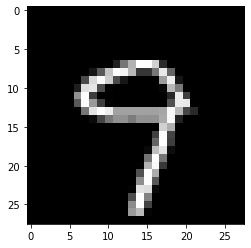

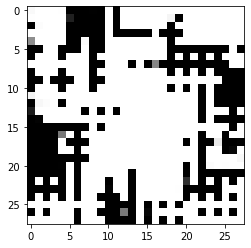

'epoch:  2501 ' [discriminator loss:  5.28544  and acc:  0.5 ] [generator loss:  0.0005938286  and acc:  1.0 ]
'epoch:  2502 ' [discriminator loss:  4.5965123  and acc:  0.5 ] [generator loss:  0.0018944095  and acc:  1.0 ]
'epoch:  2503 ' [discriminator loss:  5.2904963  and acc:  0.5 ] [generator loss:  0.0008328682  and acc:  1.0 ]
'epoch:  2504 ' [discriminator loss:  4.748726  and acc:  0.5 ] [generator loss:  0.0014762775  and acc:  1.0 ]
'epoch:  2505 ' [discriminator loss:  5.004301  and acc:  0.5 ] [generator loss:  0.0009056255  and acc:  1.0 ]
'epoch:  2506 ' [discriminator loss:  4.7167006  and acc:  0.5 ] [generator loss:  0.0016163691  and acc:  1.0 ]
'epoch:  2507 ' [discriminator loss:  5.04272  and acc:  0.5 ] [generator loss:  0.00095997634  and acc:  1.0 ]
'epoch:  2508 ' [discriminator loss:  4.7918816  and acc:  0.5 ] [generator loss:  0.0016666274  and acc:  1.0 ]
'epoch:  2509 ' [discriminator loss:  5.131523  and acc:  0.5 ] [generator loss:  0.0008384002  and a

'epoch:  2574 ' [discriminator loss:  3.8834233  and acc:  0.5 ] [generator loss:  0.014181428  and acc:  1.0 ]
'epoch:  2575 ' [discriminator loss:  5.5398607  and acc:  0.5 ] [generator loss:  0.00048170303  and acc:  1.0 ]
'epoch:  2576 ' [discriminator loss:  4.067894  and acc:  0.5 ] [generator loss:  0.011458302  and acc:  1.0 ]
'epoch:  2577 ' [discriminator loss:  5.049408  and acc:  0.5 ] [generator loss:  0.0016990518  and acc:  1.0 ]
'epoch:  2578 ' [discriminator loss:  3.842433  and acc:  0.5 ] [generator loss:  0.014371224  and acc:  1.0 ]
'epoch:  2579 ' [discriminator loss:  5.0456944  and acc:  0.5 ] [generator loss:  0.0013803613  and acc:  1.0 ]
'epoch:  2580 ' [discriminator loss:  3.7769885  and acc:  0.5 ] [generator loss:  0.014313176  and acc:  1.0 ]
'epoch:  2581 ' [discriminator loss:  4.7649736  and acc:  0.5 ] [generator loss:  0.0027149448  and acc:  1.0 ]
'epoch:  2582 ' [discriminator loss:  3.7016373  and acc:  0.5 ] [generator loss:  0.014752899  and ac

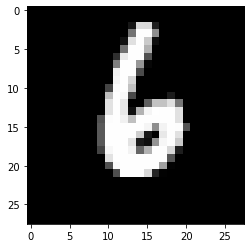

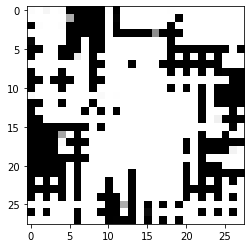

'epoch:  2601 ' [discriminator loss:  3.7271912  and acc:  0.5 ] [generator loss:  0.032916278  and acc:  1.0 ]
'epoch:  2602 ' [discriminator loss:  4.697377  and acc:  0.5 ] [generator loss:  0.003940195  and acc:  1.0 ]
'epoch:  2603 ' [discriminator loss:  3.3222609  and acc:  0.5 ] [generator loss:  0.028519152  and acc:  1.0 ]
'epoch:  2604 ' [discriminator loss:  4.169319  and acc:  0.5 ] [generator loss:  0.0065284614  and acc:  1.0 ]
'epoch:  2605 ' [discriminator loss:  3.1988053  and acc:  0.5 ] [generator loss:  0.032454405  and acc:  1.0 ]
'epoch:  2606 ' [discriminator loss:  4.251122  and acc:  0.5 ] [generator loss:  0.0058626775  and acc:  1.0 ]
'epoch:  2607 ' [discriminator loss:  3.209527  and acc:  0.5 ] [generator loss:  0.03480246  and acc:  1.0 ]
'epoch:  2608 ' [discriminator loss:  4.3867607  and acc:  0.5 ] [generator loss:  0.006461925  and acc:  1.0 ]
'epoch:  2609 ' [discriminator loss:  3.268261  and acc:  0.5 ] [generator loss:  0.036775433  and acc:  1.

'epoch:  2675 ' [discriminator loss:  3.7329144  and acc:  0.5 ] [generator loss:  0.019841343  and acc:  1.0 ]
'epoch:  2676 ' [discriminator loss:  3.0314891  and acc:  0.5 ] [generator loss:  0.05975312  and acc:  1.0 ]
'epoch:  2677 ' [discriminator loss:  3.86969  and acc:  0.5 ] [generator loss:  0.015363086  and acc:  1.0 ]
'epoch:  2678 ' [discriminator loss:  2.8791494  and acc:  0.5 ] [generator loss:  0.06430892  and acc:  1.0 ]
'epoch:  2679 ' [discriminator loss:  3.8655868  and acc:  0.5 ] [generator loss:  0.014490009  and acc:  1.0 ]
'epoch:  2680 ' [discriminator loss:  2.9160435  and acc:  0.5 ] [generator loss:  0.06213723  and acc:  1.0 ]
'epoch:  2681 ' [discriminator loss:  3.7013588  and acc:  0.5 ] [generator loss:  0.016402941  and acc:  1.0 ]
'epoch:  2682 ' [discriminator loss:  2.8441048  and acc:  0.5 ] [generator loss:  0.06509567  and acc:  1.0 ]
'epoch:  2683 ' [discriminator loss:  3.687615  and acc:  0.5 ] [generator loss:  0.01752016  and acc:  1.0 ]


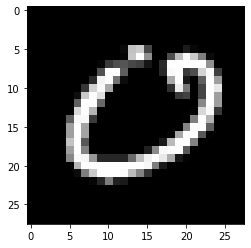

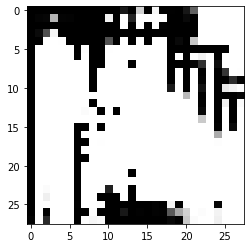

'epoch:  2701 ' [discriminator loss:  3.3076296  and acc:  0.5 ] [generator loss:  0.027791275  and acc:  1.0 ]
'epoch:  2702 ' [discriminator loss:  3.147065  and acc:  0.5 ] [generator loss:  0.04172048  and acc:  1.0 ]
'epoch:  2703 ' [discriminator loss:  3.6209087  and acc:  0.5 ] [generator loss:  0.01740188  and acc:  1.0 ]
'epoch:  2704 ' [discriminator loss:  2.9871042  and acc:  0.5 ] [generator loss:  0.05251778  and acc:  1.0 ]
'epoch:  2705 ' [discriminator loss:  3.8716853  and acc:  0.5 ] [generator loss:  0.01351638  and acc:  1.0 ]
'epoch:  2706 ' [discriminator loss:  2.884676  and acc:  0.5 ] [generator loss:  0.051797863  and acc:  1.0 ]
'epoch:  2707 ' [discriminator loss:  3.827589  and acc:  0.5 ] [generator loss:  0.014368506  and acc:  1.0 ]
'epoch:  2708 ' [discriminator loss:  2.8878374  and acc:  0.5 ] [generator loss:  0.060034882  and acc:  1.0 ]
'epoch:  2709 ' [discriminator loss:  3.9987693  and acc:  0.49804688 ] [generator loss:  0.007778717  and acc:

'epoch:  2774 ' [discriminator loss:  3.3794365  and acc:  0.5 ] [generator loss:  0.023006264  and acc:  1.0 ]
'epoch:  2775 ' [discriminator loss:  4.157224  and acc:  0.49804688 ] [generator loss:  0.005167311  and acc:  1.0 ]
'epoch:  2776 ' [discriminator loss:  3.3529084  and acc:  0.5 ] [generator loss:  0.023377037  and acc:  1.0 ]
'epoch:  2777 ' [discriminator loss:  4.196701  and acc:  0.5 ] [generator loss:  0.0058087697  and acc:  1.0 ]
'epoch:  2778 ' [discriminator loss:  3.2175546  and acc:  0.5 ] [generator loss:  0.021222929  and acc:  1.0 ]
'epoch:  2779 ' [discriminator loss:  3.852322  and acc:  0.5 ] [generator loss:  0.009720959  and acc:  1.0 ]
'epoch:  2780 ' [discriminator loss:  3.3587213  and acc:  0.5 ] [generator loss:  0.019632645  and acc:  1.0 ]
'epoch:  2781 ' [discriminator loss:  3.7459922  and acc:  0.5 ] [generator loss:  0.012433847  and acc:  1.0 ]
'epoch:  2782 ' [discriminator loss:  3.502893  and acc:  0.5 ] [generator loss:  0.015967336  and 

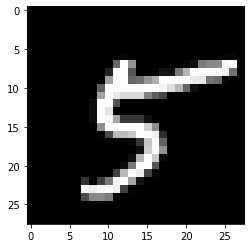

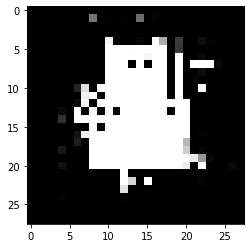

'epoch:  2801 ' [discriminator loss:  3.3709092  and acc:  0.5 ] [generator loss:  0.01745084  and acc:  1.0 ]
'epoch:  2802 ' [discriminator loss:  3.610691  and acc:  0.5 ] [generator loss:  0.0114456285  and acc:  1.0 ]
'epoch:  2803 ' [discriminator loss:  3.3686576  and acc:  0.5 ] [generator loss:  0.016661923  and acc:  1.0 ]
'epoch:  2804 ' [discriminator loss:  3.57257  and acc:  0.5 ] [generator loss:  0.010981066  and acc:  1.0 ]
'epoch:  2805 ' [discriminator loss:  3.3568106  and acc:  0.5 ] [generator loss:  0.018086713  and acc:  1.0 ]
'epoch:  2806 ' [discriminator loss:  4.0993967  and acc:  0.49609375 ] [generator loss:  0.0040698624  and acc:  1.0 ]
'epoch:  2807 ' [discriminator loss:  3.4335356  and acc:  0.5 ] [generator loss:  0.015263566  and acc:  1.0 ]
'epoch:  2808 ' [discriminator loss:  3.8965378  and acc:  0.5 ] [generator loss:  0.0067209043  and acc:  1.0 ]
'epoch:  2809 ' [discriminator loss:  3.347805  and acc:  0.5 ] [generator loss:  0.016888542  and

'epoch:  2874 ' [discriminator loss:  4.0385857  and acc:  0.5 ] [generator loss:  0.005959917  and acc:  1.0 ]
'epoch:  2875 ' [discriminator loss:  3.7859592  and acc:  0.5 ] [generator loss:  0.00803456  and acc:  1.0 ]
'epoch:  2876 ' [discriminator loss:  3.97772  and acc:  0.5 ] [generator loss:  0.005786878  and acc:  1.0 ]
'epoch:  2877 ' [discriminator loss:  3.7941298  and acc:  0.5 ] [generator loss:  0.008076351  and acc:  1.0 ]
'epoch:  2878 ' [discriminator loss:  4.0078216  and acc:  0.5 ] [generator loss:  0.0055404278  and acc:  1.0 ]
'epoch:  2879 ' [discriminator loss:  3.7307029  and acc:  0.5 ] [generator loss:  0.008619328  and acc:  1.0 ]
'epoch:  2880 ' [discriminator loss:  4.063286  and acc:  0.5 ] [generator loss:  0.005445447  and acc:  1.0 ]
'epoch:  2881 ' [discriminator loss:  3.7315977  and acc:  0.5 ] [generator loss:  0.008039836  and acc:  1.0 ]
'epoch:  2882 ' [discriminator loss:  3.9342875  and acc:  0.5 ] [generator loss:  0.006313009  and acc:  1

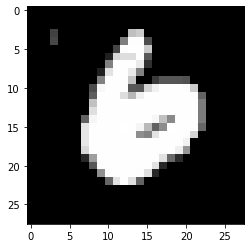

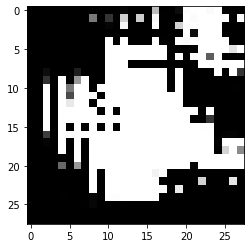

'epoch:  2901 ' [discriminator loss:  3.946621  and acc:  0.49804688 ] [generator loss:  0.0039519556  and acc:  1.0 ]
'epoch:  2902 ' [discriminator loss:  3.6777093  and acc:  0.5 ] [generator loss:  0.009186501  and acc:  1.0 ]
'epoch:  2903 ' [discriminator loss:  4.1852665  and acc:  0.49804688 ] [generator loss:  0.0031522773  and acc:  1.0 ]
'epoch:  2904 ' [discriminator loss:  3.7068357  and acc:  0.5 ] [generator loss:  0.008365015  and acc:  1.0 ]
'epoch:  2905 ' [discriminator loss:  4.1346297  and acc:  0.5 ] [generator loss:  0.003997468  and acc:  1.0 ]
'epoch:  2906 ' [discriminator loss:  3.6443405  and acc:  0.5 ] [generator loss:  0.007638524  and acc:  1.0 ]
'epoch:  2907 ' [discriminator loss:  3.993793  and acc:  0.5 ] [generator loss:  0.004885033  and acc:  1.0 ]
'epoch:  2908 ' [discriminator loss:  3.6943598  and acc:  0.5 ] [generator loss:  0.007446945  and acc:  1.0 ]
'epoch:  2909 ' [discriminator loss:  3.9803395  and acc:  0.5 ] [generator loss:  0.00459

'epoch:  2974 ' [discriminator loss:  3.9860482  and acc:  0.5 ] [generator loss:  0.004775702  and acc:  1.0 ]
'epoch:  2975 ' [discriminator loss:  4.5753508  and acc:  0.5 ] [generator loss:  0.0017859752  and acc:  1.0 ]
'epoch:  2976 ' [discriminator loss:  4.0295486  and acc:  0.5 ] [generator loss:  0.00487718  and acc:  1.0 ]
'epoch:  2977 ' [discriminator loss:  4.6869106  and acc:  0.5 ] [generator loss:  0.0015639752  and acc:  1.0 ]
'epoch:  2978 ' [discriminator loss:  4.017125  and acc:  0.5 ] [generator loss:  0.0044117887  and acc:  1.0 ]
'epoch:  2979 ' [discriminator loss:  4.528722  and acc:  0.5 ] [generator loss:  0.0023041326  and acc:  1.0 ]
'epoch:  2980 ' [discriminator loss:  4.1132784  and acc:  0.5 ] [generator loss:  0.0040246756  and acc:  1.0 ]
'epoch:  2981 ' [discriminator loss:  4.4372897  and acc:  0.5 ] [generator loss:  0.0024744282  and acc:  1.0 ]
'epoch:  2982 ' [discriminator loss:  4.1363125  and acc:  0.5 ] [generator loss:  0.0040721847  and 

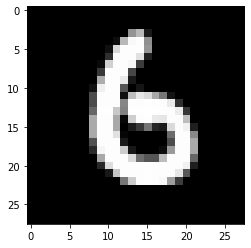

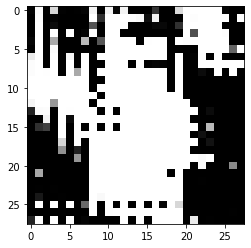

'epoch:  3001 ' [discriminator loss:  4.7072153  and acc:  0.5 ] [generator loss:  0.0015694366  and acc:  1.0 ]
'epoch:  3002 ' [discriminator loss:  4.0416036  and acc:  0.5 ] [generator loss:  0.004016744  and acc:  1.0 ]
'epoch:  3003 ' [discriminator loss:  4.5919113  and acc:  0.5 ] [generator loss:  0.0018278993  and acc:  1.0 ]
'epoch:  3004 ' [discriminator loss:  4.0995193  and acc:  0.5 ] [generator loss:  0.0036559156  and acc:  1.0 ]
'epoch:  3005 ' [discriminator loss:  4.6020336  and acc:  0.5 ] [generator loss:  0.002591906  and acc:  1.0 ]
'epoch:  3006 ' [discriminator loss:  4.326668  and acc:  0.5 ] [generator loss:  0.0027918303  and acc:  1.0 ]
'epoch:  3007 ' [discriminator loss:  4.338848  and acc:  0.5 ] [generator loss:  0.0027574678  and acc:  1.0 ]
'epoch:  3008 ' [discriminator loss:  4.3126144  and acc:  0.5 ] [generator loss:  0.0031007777  and acc:  1.0 ]
'epoch:  3009 ' [discriminator loss:  4.4533663  and acc:  0.5 ] [generator loss:  0.0024589943  and

'epoch:  3074 ' [discriminator loss:  4.510515  and acc:  0.5 ] [generator loss:  0.0019126637  and acc:  1.0 ]
'epoch:  3075 ' [discriminator loss:  4.419129  and acc:  0.5 ] [generator loss:  0.002136527  and acc:  1.0 ]
'epoch:  3076 ' [discriminator loss:  4.5468216  and acc:  0.5 ] [generator loss:  0.0018452437  and acc:  1.0 ]
'epoch:  3077 ' [discriminator loss:  4.4344606  and acc:  0.5 ] [generator loss:  0.0021055012  and acc:  1.0 ]
'epoch:  3078 ' [discriminator loss:  4.5352  and acc:  0.5 ] [generator loss:  0.0019237971  and acc:  1.0 ]
'epoch:  3079 ' [discriminator loss:  4.51334  and acc:  0.5 ] [generator loss:  0.002224838  and acc:  1.0 ]
'epoch:  3080 ' [discriminator loss:  4.637384  and acc:  0.5 ] [generator loss:  0.001652888  and acc:  1.0 ]
'epoch:  3081 ' [discriminator loss:  4.4414616  and acc:  0.5 ] [generator loss:  0.0024789735  and acc:  1.0 ]
'epoch:  3082 ' [discriminator loss:  4.7209325  and acc:  0.5 ] [generator loss:  0.0015236159  and acc:  

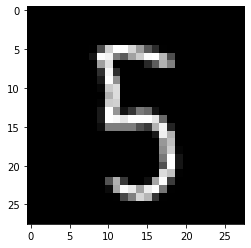

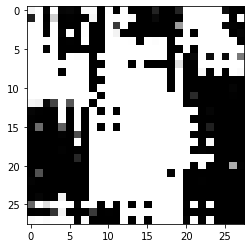

'epoch:  3101 ' [discriminator loss:  4.571478  and acc:  0.5 ] [generator loss:  0.0018602263  and acc:  1.0 ]
'epoch:  3102 ' [discriminator loss:  4.5155764  and acc:  0.5 ] [generator loss:  0.0019277283  and acc:  1.0 ]
'epoch:  3103 ' [discriminator loss:  4.560109  and acc:  0.5 ] [generator loss:  0.0017151855  and acc:  1.0 ]
'epoch:  3104 ' [discriminator loss:  4.45903  and acc:  0.5 ] [generator loss:  0.0019886405  and acc:  1.0 ]
'epoch:  3105 ' [discriminator loss:  4.6145763  and acc:  0.5 ] [generator loss:  0.001709654  and acc:  1.0 ]
'epoch:  3106 ' [discriminator loss:  4.495281  and acc:  0.5 ] [generator loss:  0.0020616623  and acc:  1.0 ]
'epoch:  3107 ' [discriminator loss:  4.658746  and acc:  0.5 ] [generator loss:  0.0016870322  and acc:  1.0 ]
'epoch:  3108 ' [discriminator loss:  4.5741444  and acc:  0.5 ] [generator loss:  0.0021105788  and acc:  1.0 ]
'epoch:  3109 ' [discriminator loss:  4.7243414  and acc:  0.5 ] [generator loss:  0.001478055  and acc

'epoch:  3174 ' [discriminator loss:  4.5094714  and acc:  0.5 ] [generator loss:  0.0017054176  and acc:  1.0 ]
'epoch:  3175 ' [discriminator loss:  4.583644  and acc:  0.5 ] [generator loss:  0.0016059855  and acc:  1.0 ]
'epoch:  3176 ' [discriminator loss:  4.667013  and acc:  0.49804688 ] [generator loss:  0.0009919966  and acc:  1.0 ]
'epoch:  3177 ' [discriminator loss:  4.5813527  and acc:  0.5 ] [generator loss:  0.002147249  and acc:  1.0 ]
'epoch:  3178 ' [discriminator loss:  4.8822875  and acc:  0.5 ] [generator loss:  0.00093105505  and acc:  1.0 ]
'epoch:  3179 ' [discriminator loss:  4.3136883  and acc:  0.5 ] [generator loss:  0.0019838843  and acc:  1.0 ]
'epoch:  3180 ' [discriminator loss:  4.714921  and acc:  0.5 ] [generator loss:  0.0011601255  and acc:  1.0 ]
'epoch:  3181 ' [discriminator loss:  4.4121275  and acc:  0.5 ] [generator loss:  0.0019101072  and acc:  1.0 ]
'epoch:  3182 ' [discriminator loss:  4.6948404  and acc:  0.5 ] [generator loss:  0.0012678

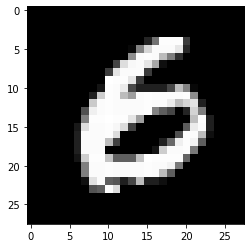

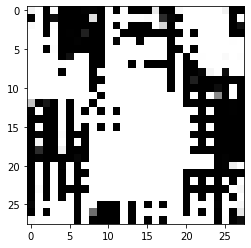

'epoch:  3201 ' [discriminator loss:  4.944188  and acc:  0.5 ] [generator loss:  0.0009280781  and acc:  1.0 ]
'epoch:  3202 ' [discriminator loss:  4.435533  and acc:  0.5 ] [generator loss:  0.0017702866  and acc:  1.0 ]
'epoch:  3203 ' [discriminator loss:  4.736988  and acc:  0.5 ] [generator loss:  0.0012100574  and acc:  1.0 ]
'epoch:  3204 ' [discriminator loss:  4.467278  and acc:  0.5 ] [generator loss:  0.0015623523  and acc:  1.0 ]
'epoch:  3205 ' [discriminator loss:  4.6236324  and acc:  0.5 ] [generator loss:  0.0013393646  and acc:  1.0 ]
'epoch:  3206 ' [discriminator loss:  4.578516  and acc:  0.5 ] [generator loss:  0.0016644128  and acc:  1.0 ]
'epoch:  3207 ' [discriminator loss:  4.7266073  and acc:  0.5 ] [generator loss:  0.0011933388  and acc:  1.0 ]
'epoch:  3208 ' [discriminator loss:  4.5406723  and acc:  0.5 ] [generator loss:  0.0018173143  and acc:  1.0 ]
'epoch:  3209 ' [discriminator loss:  4.7891994  and acc:  0.5 ] [generator loss:  0.0013067644  and 

'epoch:  3274 ' [discriminator loss:  4.7739162  and acc:  0.5 ] [generator loss:  0.0011282518  and acc:  1.0 ]
'epoch:  3275 ' [discriminator loss:  4.51945  and acc:  0.5 ] [generator loss:  0.0016687217  and acc:  1.0 ]
'epoch:  3276 ' [discriminator loss:  4.6952324  and acc:  0.5 ] [generator loss:  0.001224222  and acc:  1.0 ]
'epoch:  3277 ' [discriminator loss:  4.537348  and acc:  0.5 ] [generator loss:  0.0015303952  and acc:  1.0 ]
'epoch:  3278 ' [discriminator loss:  4.616228  and acc:  0.5 ] [generator loss:  0.001377446  and acc:  1.0 ]
'epoch:  3279 ' [discriminator loss:  4.5514135  and acc:  0.5 ] [generator loss:  0.0017076937  and acc:  1.0 ]
'epoch:  3280 ' [discriminator loss:  4.72958  and acc:  0.5 ] [generator loss:  0.0011094026  and acc:  1.0 ]
'epoch:  3281 ' [discriminator loss:  4.5020204  and acc:  0.5 ] [generator loss:  0.0016294252  and acc:  1.0 ]
'epoch:  3282 ' [discriminator loss:  4.581607  and acc:  0.5 ] [generator loss:  0.001193075  and acc: 

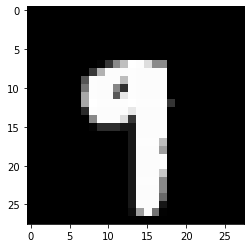

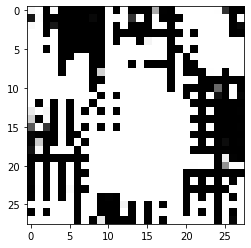

'epoch:  3301 ' [discriminator loss:  4.3020163  and acc:  0.5 ] [generator loss:  0.001610799  and acc:  1.0 ]
'epoch:  3302 ' [discriminator loss:  4.325712  and acc:  0.5 ] [generator loss:  0.0018083137  and acc:  1.0 ]
'epoch:  3303 ' [discriminator loss:  4.433541  and acc:  0.5 ] [generator loss:  0.0015516543  and acc:  1.0 ]
'epoch:  3304 ' [discriminator loss:  4.3738375  and acc:  0.5 ] [generator loss:  0.0015814118  and acc:  1.0 ]
'epoch:  3305 ' [discriminator loss:  4.3779497  and acc:  0.5 ] [generator loss:  0.0017155596  and acc:  1.0 ]
'epoch:  3306 ' [discriminator loss:  4.417226  and acc:  0.5 ] [generator loss:  0.0014902023  and acc:  1.0 ]
'epoch:  3307 ' [discriminator loss:  4.412961  and acc:  0.5 ] [generator loss:  0.0019087333  and acc:  1.0 ]
'epoch:  3308 ' [discriminator loss:  4.4517393  and acc:  0.5 ] [generator loss:  0.0015141625  and acc:  1.0 ]
'epoch:  3309 ' [discriminator loss:  4.402295  and acc:  0.5 ] [generator loss:  0.0017873899  and a

'epoch:  3374 ' [discriminator loss:  4.2943745  and acc:  0.5 ] [generator loss:  0.0017052558  and acc:  1.0 ]
'epoch:  3375 ' [discriminator loss:  4.3339562  and acc:  0.5 ] [generator loss:  0.0016212743  and acc:  1.0 ]
'epoch:  3376 ' [discriminator loss:  4.3547015  and acc:  0.5 ] [generator loss:  0.00160511  and acc:  1.0 ]
'epoch:  3377 ' [discriminator loss:  4.380493  and acc:  0.5 ] [generator loss:  0.0016585917  and acc:  1.0 ]
'epoch:  3378 ' [discriminator loss:  4.267538  and acc:  0.5 ] [generator loss:  0.0014989253  and acc:  1.0 ]
'epoch:  3379 ' [discriminator loss:  4.2025323  and acc:  0.5 ] [generator loss:  0.0018485577  and acc:  1.0 ]
'epoch:  3380 ' [discriminator loss:  4.3117886  and acc:  0.5 ] [generator loss:  0.0015185697  and acc:  1.0 ]
'epoch:  3381 ' [discriminator loss:  4.206574  and acc:  0.5 ] [generator loss:  0.0018594011  and acc:  1.0 ]
'epoch:  3382 ' [discriminator loss:  4.277355  and acc:  0.5 ] [generator loss:  0.0020281114  and a

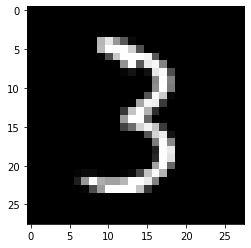

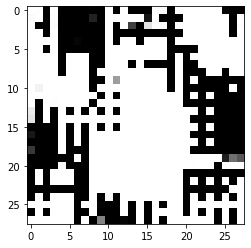

'epoch:  3401 ' [discriminator loss:  4.1556535  and acc:  0.5 ] [generator loss:  0.0021293447  and acc:  1.0 ]
'epoch:  3402 ' [discriminator loss:  4.1913204  and acc:  0.5 ] [generator loss:  0.0019610422  and acc:  1.0 ]
'epoch:  3403 ' [discriminator loss:  4.1587105  and acc:  0.5 ] [generator loss:  0.0026313805  and acc:  1.0 ]
'epoch:  3404 ' [discriminator loss:  4.395089  and acc:  0.5 ] [generator loss:  0.0012873595  and acc:  1.0 ]
'epoch:  3405 ' [discriminator loss:  4.0711823  and acc:  0.5 ] [generator loss:  0.0019231301  and acc:  1.0 ]
'epoch:  3406 ' [discriminator loss:  4.0381804  and acc:  0.5 ] [generator loss:  0.0019954725  and acc:  1.0 ]
'epoch:  3407 ' [discriminator loss:  4.123465  and acc:  0.5 ] [generator loss:  0.00206909  and acc:  1.0 ]
'epoch:  3408 ' [discriminator loss:  4.1195836  and acc:  0.5 ] [generator loss:  0.0019071713  and acc:  1.0 ]
'epoch:  3409 ' [discriminator loss:  4.074185  and acc:  0.5 ] [generator loss:  0.0021386603  and 

'epoch:  3474 ' [discriminator loss:  4.099292  and acc:  0.5 ] [generator loss:  0.0017266308  and acc:  1.0 ]
'epoch:  3475 ' [discriminator loss:  3.9890084  and acc:  0.5 ] [generator loss:  0.0018527986  and acc:  1.0 ]
'epoch:  3476 ' [discriminator loss:  3.9888887  and acc:  0.5 ] [generator loss:  0.0017880385  and acc:  1.0 ]
'epoch:  3477 ' [discriminator loss:  3.906222  and acc:  0.5 ] [generator loss:  0.0020656227  and acc:  1.0 ]
'epoch:  3478 ' [discriminator loss:  4.0024233  and acc:  0.5 ] [generator loss:  0.0018587572  and acc:  1.0 ]
'epoch:  3479 ' [discriminator loss:  3.989623  and acc:  0.5 ] [generator loss:  0.0019280191  and acc:  1.0 ]
'epoch:  3480 ' [discriminator loss:  4.0185637  and acc:  0.5 ] [generator loss:  0.0020308974  and acc:  1.0 ]
'epoch:  3481 ' [discriminator loss:  4.0387726  and acc:  0.5 ] [generator loss:  0.0020382996  and acc:  1.0 ]
'epoch:  3482 ' [discriminator loss:  4.0912476  and acc:  0.5 ] [generator loss:  0.0022580717  an

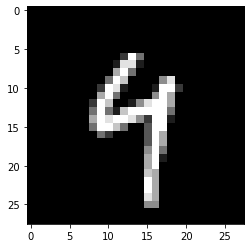

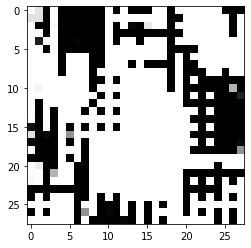

'epoch:  3501 ' [discriminator loss:  4.0265393  and acc:  0.5 ] [generator loss:  0.0019097817  and acc:  1.0 ]
'epoch:  3502 ' [discriminator loss:  4.1285076  and acc:  0.5 ] [generator loss:  0.0017419779  and acc:  1.0 ]
'epoch:  3503 ' [discriminator loss:  4.0612116  and acc:  0.5 ] [generator loss:  0.002253235  and acc:  1.0 ]
'epoch:  3504 ' [discriminator loss:  4.057502  and acc:  0.5 ] [generator loss:  0.0050125825  and acc:  1.0 ]
'epoch:  3505 ' [discriminator loss:  4.9954224  and acc:  0.5 ] [generator loss:  0.00049672625  and acc:  1.0 ]
'epoch:  3506 ' [discriminator loss:  4.179731  and acc:  0.5 ] [generator loss:  0.002300554  and acc:  1.0 ]
'epoch:  3507 ' [discriminator loss:  4.228639  and acc:  0.5 ] [generator loss:  0.0015084158  and acc:  1.0 ]
'epoch:  3508 ' [discriminator loss:  3.898095  and acc:  0.5 ] [generator loss:  0.002356701  and acc:  1.0 ]
'epoch:  3509 ' [discriminator loss:  3.9371924  and acc:  0.5 ] [generator loss:  0.002039679  and ac

'epoch:  3574 ' [discriminator loss:  3.864469  and acc:  0.5 ] [generator loss:  0.0023290713  and acc:  1.0 ]
'epoch:  3575 ' [discriminator loss:  3.8643456  and acc:  0.5 ] [generator loss:  0.0027135746  and acc:  1.0 ]
'epoch:  3576 ' [discriminator loss:  3.9333062  and acc:  0.5 ] [generator loss:  0.0022078203  and acc:  1.0 ]
'epoch:  3577 ' [discriminator loss:  3.8766303  and acc:  0.5 ] [generator loss:  0.002469346  and acc:  1.0 ]
'epoch:  3578 ' [discriminator loss:  3.8807998  and acc:  0.5 ] [generator loss:  0.00240198  and acc:  1.0 ]
'epoch:  3579 ' [discriminator loss:  3.9159687  and acc:  0.5 ] [generator loss:  0.0024500047  and acc:  1.0 ]
'epoch:  3580 ' [discriminator loss:  3.869461  and acc:  0.5 ] [generator loss:  0.0023988183  and acc:  1.0 ]
'epoch:  3581 ' [discriminator loss:  3.8726602  and acc:  0.5 ] [generator loss:  0.0024091797  and acc:  1.0 ]
'epoch:  3582 ' [discriminator loss:  3.8138108  and acc:  0.5 ] [generator loss:  0.0024795923  and 

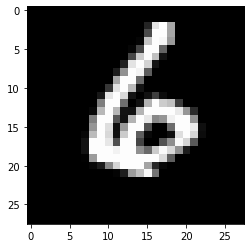

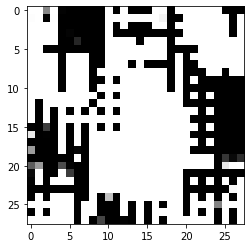

'epoch:  3601 ' [discriminator loss:  3.7999916  and acc:  0.5 ] [generator loss:  0.00238332  and acc:  1.0 ]
'epoch:  3602 ' [discriminator loss:  3.8150554  and acc:  0.5 ] [generator loss:  0.0025696312  and acc:  1.0 ]
'epoch:  3603 ' [discriminator loss:  3.8619406  and acc:  0.5 ] [generator loss:  0.0022906843  and acc:  1.0 ]
'epoch:  3604 ' [discriminator loss:  3.7996986  and acc:  0.5 ] [generator loss:  0.002586466  and acc:  1.0 ]
'epoch:  3605 ' [discriminator loss:  3.877677  and acc:  0.5 ] [generator loss:  0.0024198117  and acc:  1.0 ]
'epoch:  3606 ' [discriminator loss:  3.8247356  and acc:  0.5 ] [generator loss:  0.0030186367  and acc:  1.0 ]
'epoch:  3607 ' [discriminator loss:  3.9809556  and acc:  0.5 ] [generator loss:  0.0029346198  and acc:  1.0 ]
'epoch:  3608 ' [discriminator loss:  3.8700767  and acc:  0.5 ] [generator loss:  0.004409286  and acc:  1.0 ]
'epoch:  3609 ' [discriminator loss:  4.354297  and acc:  0.5 ] [generator loss:  0.0010349413  and a

'epoch:  3675 ' [discriminator loss:  3.5847206  and acc:  0.5 ] [generator loss:  0.0035965904  and acc:  1.0 ]
'epoch:  3676 ' [discriminator loss:  3.5190282  and acc:  0.5 ] [generator loss:  0.00438507  and acc:  1.0 ]
'epoch:  3677 ' [discriminator loss:  3.5960164  and acc:  0.5 ] [generator loss:  0.0032351853  and acc:  1.0 ]
'epoch:  3678 ' [discriminator loss:  3.441714  and acc:  0.5 ] [generator loss:  0.0041174595  and acc:  1.0 ]
'epoch:  3679 ' [discriminator loss:  3.4928956  and acc:  0.5 ] [generator loss:  0.0040262816  and acc:  1.0 ]
'epoch:  3680 ' [discriminator loss:  3.4694405  and acc:  0.5 ] [generator loss:  0.0045108115  and acc:  1.0 ]
'epoch:  3681 ' [discriminator loss:  3.5503907  and acc:  0.5 ] [generator loss:  0.005083633  and acc:  1.0 ]
'epoch:  3682 ' [discriminator loss:  3.4744182  and acc:  0.5 ] [generator loss:  0.006824325  and acc:  1.0 ]
'epoch:  3683 ' [discriminator loss:  3.8333383  and acc:  0.5 ] [generator loss:  0.002104697  and a

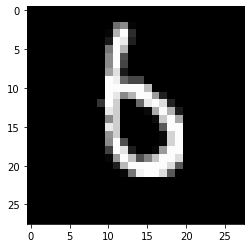

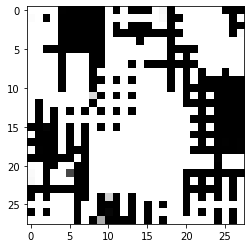

'epoch:  3701 ' [discriminator loss:  3.3563619  and acc:  0.5 ] [generator loss:  0.0048129056  and acc:  1.0 ]
'epoch:  3702 ' [discriminator loss:  3.3675995  and acc:  0.5 ] [generator loss:  0.0047625387  and acc:  1.0 ]
'epoch:  3703 ' [discriminator loss:  3.3621788  and acc:  0.5 ] [generator loss:  0.00459228  and acc:  1.0 ]
'epoch:  3704 ' [discriminator loss:  3.3805037  and acc:  0.5 ] [generator loss:  0.0048660766  and acc:  1.0 ]
'epoch:  3705 ' [discriminator loss:  3.3407342  and acc:  0.5 ] [generator loss:  0.005063841  and acc:  1.0 ]
'epoch:  3706 ' [discriminator loss:  3.3684535  and acc:  0.5 ] [generator loss:  0.0054335753  and acc:  1.0 ]
'epoch:  3707 ' [discriminator loss:  3.3165061  and acc:  0.5 ] [generator loss:  0.008096438  and acc:  1.0 ]
'epoch:  3708 ' [discriminator loss:  3.7036443  and acc:  0.5 ] [generator loss:  0.0026279804  and acc:  1.0 ]
'epoch:  3709 ' [discriminator loss:  3.3481903  and acc:  0.5 ] [generator loss:  0.0043527745  and

'epoch:  3774 ' [discriminator loss:  3.1045876  and acc:  0.5 ] [generator loss:  0.006074937  and acc:  1.0 ]
'epoch:  3775 ' [discriminator loss:  3.0857115  and acc:  0.5 ] [generator loss:  0.006738482  and acc:  1.0 ]
'epoch:  3776 ' [discriminator loss:  3.093008  and acc:  0.5 ] [generator loss:  0.007110245  and acc:  1.0 ]
'epoch:  3777 ' [discriminator loss:  3.1477094  and acc:  0.5 ] [generator loss:  0.0062503037  and acc:  1.0 ]
'epoch:  3778 ' [discriminator loss:  3.1150036  and acc:  0.5 ] [generator loss:  0.0066461465  and acc:  1.0 ]
'epoch:  3779 ' [discriminator loss:  3.1421814  and acc:  0.5 ] [generator loss:  0.0061002094  and acc:  1.0 ]
'epoch:  3780 ' [discriminator loss:  3.0951872  and acc:  0.5 ] [generator loss:  0.0066624475  and acc:  1.0 ]
'epoch:  3781 ' [discriminator loss:  3.1222308  and acc:  0.5 ] [generator loss:  0.006553743  and acc:  1.0 ]
'epoch:  3782 ' [discriminator loss:  3.1245303  and acc:  0.5 ] [generator loss:  0.0066782245  and 

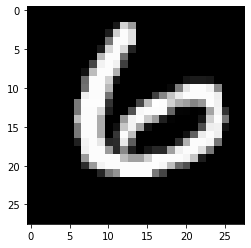

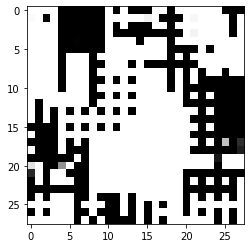

'epoch:  3801 ' [discriminator loss:  3.0826507  and acc:  0.5 ] [generator loss:  0.006147396  and acc:  1.0 ]
'epoch:  3802 ' [discriminator loss:  3.0795753  and acc:  0.5 ] [generator loss:  0.006505677  and acc:  1.0 ]
'epoch:  3803 ' [discriminator loss:  3.078157  and acc:  0.5 ] [generator loss:  0.006369689  and acc:  1.0 ]
'epoch:  3804 ' [discriminator loss:  3.0579333  and acc:  0.5 ] [generator loss:  0.007450197  and acc:  1.0 ]
'epoch:  3805 ' [discriminator loss:  3.1476493  and acc:  0.5 ] [generator loss:  0.006642339  and acc:  1.0 ]
'epoch:  3806 ' [discriminator loss:  3.123487  and acc:  0.5 ] [generator loss:  0.008367866  and acc:  1.0 ]
'epoch:  3807 ' [discriminator loss:  3.2413697  and acc:  0.5 ] [generator loss:  0.005059466  and acc:  1.0 ]
'epoch:  3808 ' [discriminator loss:  3.1154428  and acc:  0.5 ] [generator loss:  0.005866355  and acc:  1.0 ]
'epoch:  3809 ' [discriminator loss:  3.0525005  and acc:  0.5 ] [generator loss:  0.0061291945  and acc: 

'epoch:  3875 ' [discriminator loss:  2.8302615  and acc:  0.5 ] [generator loss:  0.010389868  and acc:  1.0 ]
'epoch:  3876 ' [discriminator loss:  2.8243284  and acc:  0.5 ] [generator loss:  0.010733827  and acc:  1.0 ]
'epoch:  3877 ' [discriminator loss:  2.8090422  and acc:  0.5 ] [generator loss:  0.010633994  and acc:  1.0 ]
'epoch:  3878 ' [discriminator loss:  2.8282235  and acc:  0.5 ] [generator loss:  0.010125257  and acc:  1.0 ]
'epoch:  3879 ' [discriminator loss:  2.8446374  and acc:  0.5 ] [generator loss:  0.0111788865  and acc:  1.0 ]
'epoch:  3880 ' [discriminator loss:  2.8298213  and acc:  0.5 ] [generator loss:  0.010515663  and acc:  1.0 ]
'epoch:  3881 ' [discriminator loss:  2.818541  and acc:  0.5 ] [generator loss:  0.010726479  and acc:  1.0 ]
'epoch:  3882 ' [discriminator loss:  2.7951727  and acc:  0.5 ] [generator loss:  0.010128412  and acc:  1.0 ]
'epoch:  3883 ' [discriminator loss:  2.8160388  and acc:  0.5 ] [generator loss:  0.010455506  and acc:

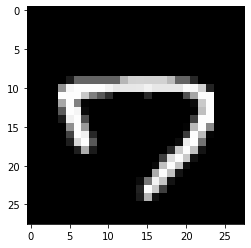

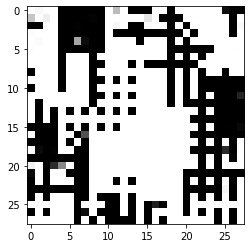

'epoch:  3901 ' [discriminator loss:  2.8884013  and acc:  0.5 ] [generator loss:  0.008842738  and acc:  1.0 ]
'epoch:  3902 ' [discriminator loss:  2.8200493  and acc:  0.5 ] [generator loss:  0.009430994  and acc:  1.0 ]
'epoch:  3903 ' [discriminator loss:  2.7510366  and acc:  0.5 ] [generator loss:  0.010482988  and acc:  1.0 ]
'epoch:  3904 ' [discriminator loss:  2.7856264  and acc:  0.5 ] [generator loss:  0.010314861  and acc:  1.0 ]
'epoch:  3905 ' [discriminator loss:  2.782092  and acc:  0.5 ] [generator loss:  0.010546707  and acc:  1.0 ]
'epoch:  3906 ' [discriminator loss:  2.805415  and acc:  0.5 ] [generator loss:  0.010151835  and acc:  1.0 ]
'epoch:  3907 ' [discriminator loss:  2.82273  and acc:  0.5 ] [generator loss:  0.010694882  and acc:  1.0 ]
'epoch:  3908 ' [discriminator loss:  2.861041  and acc:  0.5 ] [generator loss:  0.011092958  and acc:  1.0 ]
'epoch:  3909 ' [discriminator loss:  2.8149805  and acc:  0.5 ] [generator loss:  0.011228229  and acc:  1.0

'epoch:  3975 ' [discriminator loss:  2.8418293  and acc:  0.5 ] [generator loss:  0.009432885  and acc:  1.0 ]
'epoch:  3976 ' [discriminator loss:  2.77487  and acc:  0.5 ] [generator loss:  0.009571829  and acc:  1.0 ]
'epoch:  3977 ' [discriminator loss:  2.7643814  and acc:  0.5 ] [generator loss:  0.010249386  and acc:  1.0 ]
'epoch:  3978 ' [discriminator loss:  2.7597613  and acc:  0.5 ] [generator loss:  0.010196276  and acc:  1.0 ]
'epoch:  3979 ' [discriminator loss:  2.7741404  and acc:  0.5 ] [generator loss:  0.010659771  and acc:  1.0 ]
'epoch:  3980 ' [discriminator loss:  2.727295  and acc:  0.5 ] [generator loss:  0.010397017  and acc:  1.0 ]
'epoch:  3981 ' [discriminator loss:  2.770136  and acc:  0.5 ] [generator loss:  0.010195909  and acc:  1.0 ]
'epoch:  3982 ' [discriminator loss:  2.750835  and acc:  0.5 ] [generator loss:  0.0102673415  and acc:  1.0 ]
'epoch:  3983 ' [discriminator loss:  2.7602322  and acc:  0.5 ] [generator loss:  0.010725385  and acc:  1.

In [25]:
for epoch in range(4000):
    noise_input = np.random.uniform(-1, 1, size = [batch_size, 100])
    fake_images = generator_model.predict(noise_input)

    for discriminator_epochs in range(1):
        genuine_images = X_train[np.random.randint(
            0, X_train.shape[0], size = batch_size), :, :, :]
        
        X_input = np.concatenate((genuine_images, fake_images))
        Y_label = np.ones([2 * batch_size, 1])
        Y_label[batch_size : , : ] = 0 

        d_loss = discriminator_compilation.train_on_batch(X_input, Y_label)
    
    Y_label = np.ones([batch_size, 1])
    g_loss = generator_compilation.train_on_batch(noise_input, Y_label)
    print("\'epoch: ", epoch,"\' [discriminator loss: ", d_loss[0], " and acc: ", d_loss[1],"] [generator loss: ",
          g_loss[0]," and acc: ", g_loss[1],"]")

    d_loss_tracker.append(d_loss[0])
    g_loss_tracker.append(g_loss[0])
    d_acc_tracker.append(d_loss[1])
    g_acc_tracker.append(g_loss[1])

    
    if epoch % 100 == 0:
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(genuine_images[0, :, :, 0], cmap='gray')
        plt.show()
        plt.imshow(fake_images[0, :, :, 0], cmap='gray')
        plt.show()